## Imports

In [28]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


---

In [29]:
import os
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
from itertools import product

In [30]:
fp_local = '/home/jovyan/docker/src/python/temp_test/DJGrad'
fp_data = os.path.join(fp_local, 'data')

In [31]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow import keras
from copy import deepcopy

num_classes = 3

In [32]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [332]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

In [333]:
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [271]:
# x_test.reshape(-1,28**2).shape

In [287]:
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices((x_train.reshape(60000,28,28,1),y_train)).shuffle(100).batch(batch_size,True)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test.reshape(10000,28,28,1),y_test)).shuffle(100).batch(batch_size,True)

In [288]:
class CWAcc1(tf.keras.metrics.Metric):
    def __init__(self, class_idx, name='classwise_accuracy1', num_classes=10, **kwargs):
        super(CWAcc1, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.class_idx = class_idx
        self.num_correct = self.add_weight(name='num_correct',initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples',initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(tf.cast(y_true, tf.int16),(1,-1))
        y_pred = tf.reshape(tf.cast(tf.argmax(y_pred,axis=1), tf.int16),(1,-1))
                
        count_correct = tf.math.reduce_sum(tf.cast(tf.math.logical_and(
            tf.equal(y_true,y_pred),
            tf.equal(y_true,tf.math.multiply(tf.ones_like(y_true),self.class_idx))
        ),dtype=tf.float32))
        
        count_class = tf.math.reduce_sum(tf.cast(
            tf.equal(y_true,tf.math.multiply(tf.ones_like(y_true),self.class_idx)),
            dtype=tf.float32
        ))
        
        self.num_correct.assign_add(count_correct)
        self.num_samples.assign_add(count_class)

    def result(self):
        return tf.math.divide_no_nan(self.num_correct,self.num_samples)

In [289]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [301]:
fp_datamodel = Sequential([
    layers.Conv2D(2, 3, activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(4, 3, activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(8, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, 'softmax')
])

fp_datamodel.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc1(n,name=f'cl{n}') for n in range(10)]
)

In [302]:
%%time

history = fp_datamodel.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'normal.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
468/468 [==============================] - 3s 6ms/step - loss: 7.0140 - cl0: 0.6579 - cl1: 0.8047 - cl2: 0.4644 - cl3: 0.5420 - cl4: 0.5188 - cl5: 0.3150 - cl6: 0.5439 - cl7: 0.5968 - cl8: 0.3736 - cl9: 0.4853 - val_loss: 1.3133 - val_cl0: 0.6905 - val_cl1: 0.9506 - val_cl2: 0.6631 - val_cl3: 0.6875 - val_cl4: 0.7469 - val_cl5: 0.6435 - val_cl6: 0.7071 - val_cl7: 0.7018 - val_cl8: 0.4419 - val_cl9: 0.6740
Epoch 2/300
468/468 [==============================] - 3s 5ms/step - loss: 0.9223 - cl0: 0.8324 - cl1: 0.9344 - cl2: 0.7133 - cl3: 0.7324 - cl4: 0.7565 - cl5: 0.6827 - cl6: 0.8107 - cl7: 0.7552 - cl8: 0.6624 - cl9: 0.7275 - val_loss: 0.7161 - val_cl0: 0.8528 - val_cl1: 0.9620 - val_cl2: 0.7252 - val_cl3: 0.8117 - val_cl4: 0.8226 - val_cl5: 0.8049 - val_cl6: 0.7816 - val_cl7: 0.8066 - val_cl8: 0.6512 - val_cl9: 0.8097
Epoch 3/300
468/468 [==============================] - 3s 6ms/step - loss: 0.5922 - cl0: 0.8953 - cl1: 0.9502 - cl2: 0.7831 - cl3: 0.7981 - cl4: 0.8200 - cl5:

468/468 [==============================] - 3s 5ms/step - loss: 0.1081 - cl0: 0.9821 - cl1: 0.9860 - cl2: 0.9608 - cl3: 0.9560 - cl4: 0.9673 - cl5: 0.9618 - cl6: 0.9804 - cl7: 0.9674 - cl8: 0.9497 - cl9: 0.9502 - val_loss: 0.1046 - val_cl0: 0.9867 - val_cl1: 0.9885 - val_cl2: 0.9515 - val_cl3: 0.9643 - val_cl4: 0.9724 - val_cl5: 0.9664 - val_cl6: 0.9426 - val_cl7: 0.9717 - val_cl8: 0.9619 - val_cl9: 0.9692
Epoch 21/300
468/468 [==============================] - 3s 6ms/step - loss: 0.1043 - cl0: 0.9836 - cl1: 0.9869 - cl2: 0.9632 - cl3: 0.9573 - cl4: 0.9678 - cl5: 0.9621 - cl6: 0.9810 - cl7: 0.9709 - cl8: 0.9498 - cl9: 0.9525 - val_loss: 0.1015 - val_cl0: 0.9867 - val_cl1: 0.9894 - val_cl2: 0.9564 - val_cl3: 0.9643 - val_cl4: 0.9683 - val_cl5: 0.9686 - val_cl6: 0.9520 - val_cl7: 0.9629 - val_cl8: 0.9640 - val_cl9: 0.9772
Epoch 22/300
468/468 [==============================] - 3s 6ms/step - loss: 0.0995 - cl0: 0.9848 - cl1: 0.9878 - cl2: 0.9652 - cl3: 0.9582 - cl4: 0.9688 - cl5: 0.9640 - 

468/468 [==============================] - 3s 6ms/step - loss: 0.0672 - cl0: 0.9890 - cl1: 0.9914 - cl2: 0.9785 - cl3: 0.9703 - cl4: 0.9780 - cl5: 0.9741 - cl6: 0.9880 - cl7: 0.9819 - cl8: 0.9661 - cl9: 0.9680 - val_loss: 0.0872 - val_cl0: 0.9888 - val_cl1: 0.9947 - val_cl2: 0.9621 - val_cl3: 0.9613 - val_cl4: 0.9817 - val_cl5: 0.9764 - val_cl6: 0.9707 - val_cl7: 0.9805 - val_cl8: 0.9743 - val_cl9: 0.9623
Epoch 40/300
468/468 [==============================] - 3s 6ms/step - loss: 0.0664 - cl0: 0.9880 - cl1: 0.9917 - cl2: 0.9792 - cl3: 0.9704 - cl4: 0.9810 - cl5: 0.9732 - cl6: 0.9878 - cl7: 0.9823 - cl8: 0.9664 - cl9: 0.9683 - val_loss: 0.0880 - val_cl0: 0.9867 - val_cl1: 0.9938 - val_cl2: 0.9583 - val_cl3: 0.9623 - val_cl4: 0.9745 - val_cl5: 0.9742 - val_cl6: 0.9675 - val_cl7: 0.9834 - val_cl8: 0.9794 - val_cl9: 0.9602
Epoch 41/300
468/468 [==============================] - 3s 6ms/step - loss: 0.0650 - cl0: 0.9880 - cl1: 0.9918 - cl2: 0.9792 - cl3: 0.9719 - cl4: 0.9806 - cl5: 0.9747 - 

468/468 [==============================] - 3s 6ms/step - loss: 0.0567 - cl0: 0.9892 - cl1: 0.9924 - cl2: 0.9847 - cl3: 0.9752 - cl4: 0.9829 - cl5: 0.9769 - cl6: 0.9885 - cl7: 0.9858 - cl8: 0.9712 - cl9: 0.9724 - val_loss: 0.0882 - val_cl0: 0.9888 - val_cl1: 0.9929 - val_cl2: 0.9728 - val_cl3: 0.9604 - val_cl4: 0.9836 - val_cl5: 0.9753 - val_cl6: 0.9801 - val_cl7: 0.9874 - val_cl8: 0.9774 - val_cl9: 0.9435
Epoch 59/300
468/468 [==============================] - 3s 6ms/step - loss: 0.0562 - cl0: 0.9904 - cl1: 0.9927 - cl2: 0.9839 - cl3: 0.9753 - cl4: 0.9827 - cl5: 0.9769 - cl6: 0.9887 - cl7: 0.9853 - cl8: 0.9719 - cl9: 0.9707 - val_loss: 0.0889 - val_cl0: 0.9846 - val_cl1: 0.9938 - val_cl2: 0.9680 - val_cl3: 0.9613 - val_cl4: 0.9827 - val_cl5: 0.9820 - val_cl6: 0.9780 - val_cl7: 0.9854 - val_cl8: 0.9784 - val_cl9: 0.9435
Epoch 60/300
468/468 [==============================] - 3s 5ms/step - loss: 0.0556 - cl0: 0.9909 - cl1: 0.9918 - cl2: 0.9840 - cl3: 0.9748 - cl4: 0.9832 - cl5: 0.9773 - 

468/468 [==============================] - 3s 6ms/step - loss: 0.0504 - cl0: 0.9924 - cl1: 0.9930 - cl2: 0.9849 - cl3: 0.9763 - cl4: 0.9840 - cl5: 0.9784 - cl6: 0.9905 - cl7: 0.9845 - cl8: 0.9767 - cl9: 0.9742 - val_loss: 0.0836 - val_cl0: 0.9888 - val_cl1: 0.9965 - val_cl2: 0.9757 - val_cl3: 0.9643 - val_cl4: 0.9817 - val_cl5: 0.9820 - val_cl6: 0.9812 - val_cl7: 0.9815 - val_cl8: 0.9743 - val_cl9: 0.9494
Epoch 78/300
468/468 [==============================] - 3s 6ms/step - loss: 0.0506 - cl0: 0.9919 - cl1: 0.9932 - cl2: 0.9840 - cl3: 0.9768 - cl4: 0.9832 - cl5: 0.9786 - cl6: 0.9897 - cl7: 0.9848 - cl8: 0.9772 - cl9: 0.9748 - val_loss: 0.0848 - val_cl0: 0.9898 - val_cl1: 0.9965 - val_cl2: 0.9758 - val_cl3: 0.9663 - val_cl4: 0.9857 - val_cl5: 0.9765 - val_cl6: 0.9780 - val_cl7: 0.9805 - val_cl8: 0.9691 - val_cl9: 0.9484
Epoch 79/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0503 - cl0: 0.9914 - cl1: 0.9936 - cl2: 0.9855 - cl3: 0.9761 - cl4: 0.9810 - cl5: 0.9775 - 

468/468 [==============================] - 2s 5ms/step - loss: 0.0449 - cl0: 0.9927 - cl1: 0.9933 - cl2: 0.9861 - cl3: 0.9789 - cl4: 0.9844 - cl5: 0.9788 - cl6: 0.9924 - cl7: 0.9872 - cl8: 0.9777 - cl9: 0.9778 - val_loss: 0.0845 - val_cl0: 0.9888 - val_cl1: 0.9938 - val_cl2: 0.9747 - val_cl3: 0.9722 - val_cl4: 0.9877 - val_cl5: 0.9764 - val_cl6: 0.9791 - val_cl7: 0.9815 - val_cl8: 0.9722 - val_cl9: 0.9405
Epoch 97/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0452 - cl0: 0.9922 - cl1: 0.9938 - cl2: 0.9877 - cl3: 0.9786 - cl4: 0.9851 - cl5: 0.9797 - cl6: 0.9912 - cl7: 0.9851 - cl8: 0.9788 - cl9: 0.9781 - val_loss: 0.0939 - val_cl0: 0.9898 - val_cl1: 0.9921 - val_cl2: 0.9709 - val_cl3: 0.9663 - val_cl4: 0.9898 - val_cl5: 0.9776 - val_cl6: 0.9801 - val_cl7: 0.9815 - val_cl8: 0.9681 - val_cl9: 0.9354
Epoch 98/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0451 - cl0: 0.9931 - cl1: 0.9929 - cl2: 0.9855 - cl3: 0.9786 - cl4: 0.9842 - cl5: 0.9799 - 

468/468 [==============================] - 2s 5ms/step - loss: 0.0423 - cl0: 0.9939 - cl1: 0.9938 - cl2: 0.9869 - cl3: 0.9791 - cl4: 0.9866 - cl5: 0.9799 - cl6: 0.9927 - cl7: 0.9882 - cl8: 0.9771 - cl9: 0.9788 - val_loss: 0.0921 - val_cl0: 0.9877 - val_cl1: 0.9938 - val_cl2: 0.9708 - val_cl3: 0.9653 - val_cl4: 0.9847 - val_cl5: 0.9776 - val_cl6: 0.9864 - val_cl7: 0.9873 - val_cl8: 0.9681 - val_cl9: 0.9315
Epoch 116/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0426 - cl0: 0.9931 - cl1: 0.9935 - cl2: 0.9867 - cl3: 0.9802 - cl4: 0.9858 - cl5: 0.9804 - cl6: 0.9924 - cl7: 0.9883 - cl8: 0.9779 - cl9: 0.9788 - val_loss: 0.0946 - val_cl0: 0.9908 - val_cl1: 0.9921 - val_cl2: 0.9757 - val_cl3: 0.9603 - val_cl4: 0.9857 - val_cl5: 0.9832 - val_cl6: 0.9801 - val_cl7: 0.9795 - val_cl8: 0.9723 - val_cl9: 0.9366
Epoch 117/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0430 - cl0: 0.9926 - cl1: 0.9941 - cl2: 0.9867 - cl3: 0.9806 - cl4: 0.9852 - cl5: 0.9821 

468/468 [==============================] - 3s 5ms/step - loss: 0.0405 - cl0: 0.9927 - cl1: 0.9933 - cl2: 0.9887 - cl3: 0.9824 - cl4: 0.9868 - cl5: 0.9780 - cl6: 0.9922 - cl7: 0.9878 - cl8: 0.9805 - cl9: 0.9795 - val_loss: 0.0884 - val_cl0: 0.9918 - val_cl1: 0.9912 - val_cl2: 0.9845 - val_cl3: 0.9604 - val_cl4: 0.9806 - val_cl5: 0.9843 - val_cl6: 0.9759 - val_cl7: 0.9873 - val_cl8: 0.9670 - val_cl9: 0.9445
Epoch 135/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0396 - cl0: 0.9932 - cl1: 0.9941 - cl2: 0.9886 - cl3: 0.9812 - cl4: 0.9863 - cl5: 0.9821 - cl6: 0.9932 - cl7: 0.9877 - cl8: 0.9795 - cl9: 0.9805 - val_loss: 0.0899 - val_cl0: 0.9928 - val_cl1: 0.9920 - val_cl2: 0.9845 - val_cl3: 0.9594 - val_cl4: 0.9775 - val_cl5: 0.9832 - val_cl6: 0.9729 - val_cl7: 0.9883 - val_cl8: 0.9702 - val_cl9: 0.9553
Epoch 136/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0407 - cl0: 0.9927 - cl1: 0.9939 - cl2: 0.9882 - cl3: 0.9810 - cl4: 0.9853 - cl5: 0.9806 

468/468 [==============================] - 2s 5ms/step - loss: 0.0384 - cl0: 0.9921 - cl1: 0.9948 - cl2: 0.9882 - cl3: 0.9811 - cl4: 0.9866 - cl5: 0.9813 - cl6: 0.9937 - cl7: 0.9890 - cl8: 0.9807 - cl9: 0.9790 - val_loss: 0.0965 - val_cl0: 0.9949 - val_cl1: 0.9921 - val_cl2: 0.9845 - val_cl3: 0.9554 - val_cl4: 0.9837 - val_cl5: 0.9832 - val_cl6: 0.9749 - val_cl7: 0.9844 - val_cl8: 0.9743 - val_cl9: 0.9524
Epoch 154/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0385 - cl0: 0.9934 - cl1: 0.9944 - cl2: 0.9894 - cl3: 0.9827 - cl4: 0.9878 - cl5: 0.9790 - cl6: 0.9927 - cl7: 0.9896 - cl8: 0.9808 - cl9: 0.9810 - val_loss: 0.0942 - val_cl0: 0.9928 - val_cl1: 0.9912 - val_cl2: 0.9835 - val_cl3: 0.9624 - val_cl4: 0.9826 - val_cl5: 0.9865 - val_cl6: 0.9749 - val_cl7: 0.9844 - val_cl8: 0.9713 - val_cl9: 0.9514
Epoch 155/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0394 - cl0: 0.9929 - cl1: 0.9935 - cl2: 0.9909 - cl3: 0.9817 - cl4: 0.9868 - cl5: 0.9821 

468/468 [==============================] - 2s 5ms/step - loss: 0.0368 - cl0: 0.9939 - cl1: 0.9936 - cl2: 0.9901 - cl3: 0.9820 - cl4: 0.9859 - cl5: 0.9812 - cl6: 0.9934 - cl7: 0.9888 - cl8: 0.9810 - cl9: 0.9801 - val_loss: 0.0984 - val_cl0: 0.9918 - val_cl1: 0.9894 - val_cl2: 0.9855 - val_cl3: 0.9653 - val_cl4: 0.9837 - val_cl5: 0.9787 - val_cl6: 0.9738 - val_cl7: 0.9786 - val_cl8: 0.9723 - val_cl9: 0.9543
Epoch 173/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0349 - cl0: 0.9942 - cl1: 0.9951 - cl2: 0.9897 - cl3: 0.9846 - cl4: 0.9877 - cl5: 0.9826 - cl6: 0.9937 - cl7: 0.9890 - cl8: 0.9810 - cl9: 0.9813 - val_loss: 0.1036 - val_cl0: 0.9928 - val_cl1: 0.9885 - val_cl2: 0.9845 - val_cl3: 0.9693 - val_cl4: 0.9816 - val_cl5: 0.9753 - val_cl6: 0.9770 - val_cl7: 0.9746 - val_cl8: 0.9764 - val_cl9: 0.9533
Epoch 174/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0356 - cl0: 0.9936 - cl1: 0.9952 - cl2: 0.9903 - cl3: 0.9824 - cl4: 0.9875 - cl5: 0.9841 

468/468 [==============================] - 2s 5ms/step - loss: 0.0354 - cl0: 0.9931 - cl1: 0.9947 - cl2: 0.9901 - cl3: 0.9832 - cl4: 0.9876 - cl5: 0.9850 - cl6: 0.9939 - cl7: 0.9893 - cl8: 0.9822 - cl9: 0.9806 - val_loss: 0.1077 - val_cl0: 0.9918 - val_cl1: 0.9877 - val_cl2: 0.9845 - val_cl3: 0.9643 - val_cl4: 0.9806 - val_cl5: 0.9718 - val_cl6: 0.9738 - val_cl7: 0.9844 - val_cl8: 0.9774 - val_cl9: 0.9583
Epoch 192/300
468/468 [==============================] - 3s 5ms/step - loss: 0.0353 - cl0: 0.9944 - cl1: 0.9955 - cl2: 0.9904 - cl3: 0.9835 - cl4: 0.9878 - cl5: 0.9850 - cl6: 0.9939 - cl7: 0.9901 - cl8: 0.9834 - cl9: 0.9827 - val_loss: 0.1078 - val_cl0: 0.9898 - val_cl1: 0.9903 - val_cl2: 0.9806 - val_cl3: 0.9673 - val_cl4: 0.9847 - val_cl5: 0.9697 - val_cl6: 0.9760 - val_cl7: 0.9864 - val_cl8: 0.9753 - val_cl9: 0.9485
Epoch 193/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0342 - cl0: 0.9937 - cl1: 0.9952 - cl2: 0.9889 - cl3: 0.9840 - cl4: 0.9875 - cl5: 0.9837 

468/468 [==============================] - 2s 5ms/step - loss: 0.0335 - cl0: 0.9943 - cl1: 0.9939 - cl2: 0.9918 - cl3: 0.9841 - cl4: 0.9877 - cl5: 0.9852 - cl6: 0.9941 - cl7: 0.9904 - cl8: 0.9832 - cl9: 0.9832 - val_loss: 0.1087 - val_cl0: 0.9928 - val_cl1: 0.9885 - val_cl2: 0.9855 - val_cl3: 0.9663 - val_cl4: 0.9765 - val_cl5: 0.9753 - val_cl6: 0.9738 - val_cl7: 0.9786 - val_cl8: 0.9733 - val_cl9: 0.9593
Epoch 211/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0350 - cl0: 0.9936 - cl1: 0.9930 - cl2: 0.9914 - cl3: 0.9850 - cl4: 0.9885 - cl5: 0.9841 - cl6: 0.9949 - cl7: 0.9888 - cl8: 0.9836 - cl9: 0.9827 - val_loss: 0.1071 - val_cl0: 0.9918 - val_cl1: 0.9885 - val_cl2: 0.9777 - val_cl3: 0.9673 - val_cl4: 0.9857 - val_cl5: 0.9765 - val_cl6: 0.9791 - val_cl7: 0.9854 - val_cl8: 0.9630 - val_cl9: 0.9544
Epoch 212/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0344 - cl0: 0.9946 - cl1: 0.9944 - cl2: 0.9884 - cl3: 0.9843 - cl4: 0.9880 - cl5: 0.9849 

468/468 [==============================] - 3s 5ms/step - loss: 0.0334 - cl0: 0.9944 - cl1: 0.9949 - cl2: 0.9904 - cl3: 0.9848 - cl4: 0.9877 - cl5: 0.9860 - cl6: 0.9942 - cl7: 0.9886 - cl8: 0.9825 - cl9: 0.9859 - val_loss: 0.1081 - val_cl0: 0.9929 - val_cl1: 0.9885 - val_cl2: 0.9825 - val_cl3: 0.9662 - val_cl4: 0.9786 - val_cl5: 0.9742 - val_cl6: 0.9759 - val_cl7: 0.9902 - val_cl8: 0.9723 - val_cl9: 0.9603
Epoch 230/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0322 - cl0: 0.9946 - cl1: 0.9955 - cl2: 0.9903 - cl3: 0.9855 - cl4: 0.9892 - cl5: 0.9847 - cl6: 0.9944 - cl7: 0.9899 - cl8: 0.9848 - cl9: 0.9833 - val_loss: 0.1087 - val_cl0: 0.9918 - val_cl1: 0.9885 - val_cl2: 0.9806 - val_cl3: 0.9653 - val_cl4: 0.9735 - val_cl5: 0.9742 - val_cl6: 0.9738 - val_cl7: 0.9893 - val_cl8: 0.9763 - val_cl9: 0.9563
Epoch 231/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0315 - cl0: 0.9941 - cl1: 0.9954 - cl2: 0.9913 - cl3: 0.9848 - cl4: 0.9897 - cl5: 0.9852 

468/468 [==============================] - 2s 5ms/step - loss: 0.0329 - cl0: 0.9954 - cl1: 0.9952 - cl2: 0.9916 - cl3: 0.9838 - cl4: 0.9885 - cl5: 0.9849 - cl6: 0.9951 - cl7: 0.9891 - cl8: 0.9837 - cl9: 0.9827 - val_loss: 0.1234 - val_cl0: 0.9939 - val_cl1: 0.9903 - val_cl2: 0.9835 - val_cl3: 0.9722 - val_cl4: 0.9807 - val_cl5: 0.9708 - val_cl6: 0.9696 - val_cl7: 0.9873 - val_cl8: 0.9598 - val_cl9: 0.9524
Epoch 249/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0310 - cl0: 0.9961 - cl1: 0.9952 - cl2: 0.9901 - cl3: 0.9850 - cl4: 0.9894 - cl5: 0.9848 - cl6: 0.9946 - cl7: 0.9898 - cl8: 0.9854 - cl9: 0.9852 - val_loss: 0.1125 - val_cl0: 0.9928 - val_cl1: 0.9885 - val_cl2: 0.9855 - val_cl3: 0.9703 - val_cl4: 0.9786 - val_cl5: 0.9742 - val_cl6: 0.9759 - val_cl7: 0.9873 - val_cl8: 0.9712 - val_cl9: 0.9633
Epoch 250/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0324 - cl0: 0.9937 - cl1: 0.9945 - cl2: 0.9889 - cl3: 0.9850 - cl4: 0.9899 - cl5: 0.9848 

468/468 [==============================] - 2s 5ms/step - loss: 0.0334 - cl0: 0.9949 - cl1: 0.9947 - cl2: 0.9891 - cl3: 0.9842 - cl4: 0.9878 - cl5: 0.9850 - cl6: 0.9944 - cl7: 0.9906 - cl8: 0.9829 - cl9: 0.9838 - val_loss: 0.1176 - val_cl0: 0.9918 - val_cl1: 0.9885 - val_cl2: 0.9786 - val_cl3: 0.9663 - val_cl4: 0.9785 - val_cl5: 0.9742 - val_cl6: 0.9728 - val_cl7: 0.9854 - val_cl8: 0.9743 - val_cl9: 0.9682
Epoch 268/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0290 - cl0: 0.9954 - cl1: 0.9958 - cl2: 0.9913 - cl3: 0.9860 - cl4: 0.9907 - cl5: 0.9869 - cl6: 0.9968 - cl7: 0.9911 - cl8: 0.9854 - cl9: 0.9867 - val_loss: 0.1198 - val_cl0: 0.9939 - val_cl1: 0.9877 - val_cl2: 0.9796 - val_cl3: 0.9723 - val_cl4: 0.9785 - val_cl5: 0.9730 - val_cl6: 0.9749 - val_cl7: 0.9864 - val_cl8: 0.9681 - val_cl9: 0.9604
Epoch 269/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0301 - cl0: 0.9954 - cl1: 0.9952 - cl2: 0.9924 - cl3: 0.9846 - cl4: 0.9904 - cl5: 0.9848 

468/468 [==============================] - 2s 5ms/step - loss: 0.0309 - cl0: 0.9954 - cl1: 0.9954 - cl2: 0.9908 - cl3: 0.9850 - cl4: 0.9907 - cl5: 0.9863 - cl6: 0.9953 - cl7: 0.9898 - cl8: 0.9834 - cl9: 0.9848 - val_loss: 0.1345 - val_cl0: 0.9939 - val_cl1: 0.9876 - val_cl2: 0.9806 - val_cl3: 0.9683 - val_cl4: 0.9888 - val_cl5: 0.9742 - val_cl6: 0.9718 - val_cl7: 0.9786 - val_cl8: 0.9753 - val_cl9: 0.9534
Epoch 287/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0322 - cl0: 0.9946 - cl1: 0.9955 - cl2: 0.9909 - cl3: 0.9835 - cl4: 0.9902 - cl5: 0.9836 - cl6: 0.9941 - cl7: 0.9896 - cl8: 0.9839 - cl9: 0.9857 - val_loss: 0.1220 - val_cl0: 0.9918 - val_cl1: 0.9832 - val_cl2: 0.9786 - val_cl3: 0.9663 - val_cl4: 0.9704 - val_cl5: 0.9764 - val_cl6: 0.9791 - val_cl7: 0.9815 - val_cl8: 0.9743 - val_cl9: 0.9662
Epoch 288/300
468/468 [==============================] - 2s 5ms/step - loss: 0.0306 - cl0: 0.9954 - cl1: 0.9955 - cl2: 0.9913 - cl3: 0.9848 - cl4: 0.9890 - cl5: 0.9856 

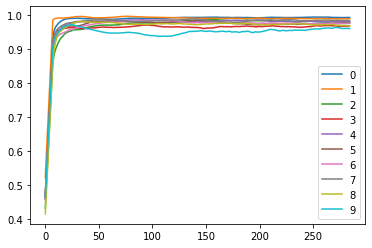

In [303]:
with open(os.path.join(fp_local,'normal.pickle'), 'rb') as handle:
    history = pickle.load(handle)

for k in history:
    if 'val_cl' in k:
        tmp = smooth(history[k],15)[:-15]
        plt.plot(tmp,label=k[-1])
        
plt.legend()

plt.show()

---

## Custom model

In [343]:
from sklearn.utils import shuffle

split_by_type = [x_train[np.where(y_train==x)] for x in range(10)]
split_by_type = [x[:x.shape[0]//4*4].reshape(4,-1,28,28) for x in split_by_type]

ds1  = [split_by_type[0][0:2], split_by_type[1][0:2]]
ds2  = [split_by_type[2][0:2], split_by_type[3][0:2]]
ds3  = [split_by_type[4][0:2], split_by_type[5][0:2]]
ds4  = [split_by_type[6][0:2], split_by_type[7][0:2]]

y1   = [0 for _ in range(np.multiply(*split_by_type[0][0:2].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][0:2].shape[:2]))]
y2   = [2 for _ in range(np.multiply(*split_by_type[2][0:2].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][0:2].shape[:2]))]
y3   = [4 for _ in range(np.multiply(*split_by_type[4][0:2].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][0:2].shape[:2]))]
y4   = [6 for _ in range(np.multiply(*split_by_type[6][0:2].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][0:2].shape[:2]))]

##

ds1 += [split_by_type[2][2:3], split_by_type[3][2:3]]
ds2 += [split_by_type[4][2:3], split_by_type[5][2:3]]
ds3 += [split_by_type[6][2:3], split_by_type[7][2:3]]
ds4 += [split_by_type[0][2:3], split_by_type[1][2:3]]

y1  += [2 for _ in range(np.multiply(*split_by_type[2][2:3].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][2:3].shape[:2]))]
y2  += [4 for _ in range(np.multiply(*split_by_type[4][2:3].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][2:3].shape[:2]))]
y3  += [6 for _ in range(np.multiply(*split_by_type[6][2:3].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][2:3].shape[:2]))]
y4  += [0 for _ in range(np.multiply(*split_by_type[0][2:3].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][2:3].shape[:2]))]

##

ds1 += [split_by_type[4][3:4], split_by_type[5][3:4]]
ds2 += [split_by_type[6][3:4], split_by_type[7][3:4]]
ds3 += [split_by_type[0][3:4], split_by_type[1][3:4]]
ds4 += [split_by_type[2][3:4], split_by_type[3][3:4]]

y1  += [4 for _ in range(np.multiply(*split_by_type[4][3:4].shape[:2]))] + [5 for _ in range(np.multiply(*split_by_type[5][3:4].shape[:2]))]
y2  += [6 for _ in range(np.multiply(*split_by_type[6][3:4].shape[:2]))] + [7 for _ in range(np.multiply(*split_by_type[7][3:4].shape[:2]))]
y3  += [0 for _ in range(np.multiply(*split_by_type[0][3:4].shape[:2]))] + [1 for _ in range(np.multiply(*split_by_type[1][3:4].shape[:2]))]
y4  += [2 for _ in range(np.multiply(*split_by_type[2][3:4].shape[:2]))] + [3 for _ in range(np.multiply(*split_by_type[3][3:4].shape[:2]))]

##

ds1 += [split_by_type[8][0:1], split_by_type[9][0:1]]
ds2 += [split_by_type[8][1:2], split_by_type[9][1:2]]
ds3 += [split_by_type[8][2:3], split_by_type[9][2:3]]
ds4 += [split_by_type[8][3:4], split_by_type[9][3:4]]

y1  += [8 for _ in range(np.multiply(*split_by_type[8][0:1].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][0:1].shape[:2]))]
y2  += [8 for _ in range(np.multiply(*split_by_type[8][1:2].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][1:2].shape[:2]))]
y3  += [8 for _ in range(np.multiply(*split_by_type[8][2:3].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][2:3].shape[:2]))]
y4  += [8 for _ in range(np.multiply(*split_by_type[8][3:4].shape[:2]))] + [9 for _ in range(np.multiply(*split_by_type[9][3:4].shape[:2]))]

##

ds1 = [list(x.reshape(-1,28,28)) for x in ds1]
ds2 = [list(x.reshape(-1,28,28)) for x in ds2]
ds3 = [list(x.reshape(-1,28,28)) for x in ds3]
ds4 = [list(x.reshape(-1,28,28)) for x in ds4]

##

ds1 = np.array([item for sublist in ds1 for item in sublist])
ds2 = np.array([item for sublist in ds2 for item in sublist])
ds3 = np.array([item for sublist in ds3 for item in sublist])
ds4 = np.array([item for sublist in ds4 for item in sublist])

y1 = np.array(y1)
y2 = np.array(y2)
y3 = np.array(y3)
y4 = np.array(y4)

##

ds1,y1 = shuffle(ds1,y1)
ds2,y2 = shuffle(ds2,y2)
ds3,y3 = shuffle(ds3,y3)
ds4,y4 = shuffle(ds4,y4)

##

m = min([x.shape[0] for x in [ds1,ds2,ds3,ds4]])

ds1,y1 = ds1[:m].reshape(-1,28,28,1),y1[:m]
ds2,y2 = ds2[:m].reshape(-1,28,28,1),y2[:m]
ds3,y3 = ds3[:m].reshape(-1,28,28,1),y3[:m]
ds4,y4 = ds4[:m].reshape(-1,28,28,1),y4[:m]

##

# x_test = x_test.reshape(-1,28**2)
train_dataset = tf.data.Dataset.from_tensor_slices((ds1,y1,ds2,y2,ds3,y3,ds4,y4)).shuffle(100).batch(batch_size,True)
validation_dataset= tf.data.Dataset.from_tensor_slices((x_test,y_test,x_test,y_test,x_test,y_test,x_test,y_test)).shuffle(100).batch(batch_size,True)

In [381]:
ds1.shape,y1.shape

((14789, 28, 28, 1), (14789,))

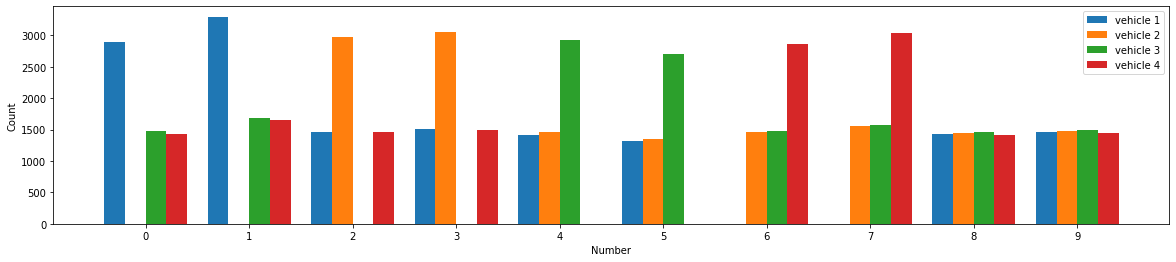

In [344]:
delta = 0.2

plt.figure(figsize=(20, 4))

for n,yt in enumerate([y1,y2,y3,y4]):
    plt.bar(*np.add(np.unique(yt, return_counts=True),np.multiply(np.array([[(n-1.5)*delta],[0]]),np.ones((2,8)))), delta)
    
plt.legend([f'vehicle {x}' for x in range(1,5)])

plt.xticks(list(range(10)))
plt.ylabel('Count')
plt.xlabel('Number')

plt.show()

In [345]:
def gen_mask(grads):
    mask = []
    for g in grads:
        size = g.shape[0]
        m = 2
        assert m%1==0

        split = tf.concat([tf.ones(size//m)*i for i in range(m)],0)
        split = tf.random.shuffle(split)
        mask.append(tf.reshape(split,(1,-1)))

    return mask

grads = [tf.random.uniform(((x+1)*2,)) for x in range(10)]

res = gen_mask(grads)
tf.math.multiply(res[2],grads[2])

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.        , 0.        , 0.31587875, 0.37846518, 0.51013184,
        0.        ]], dtype=float32)>

In [346]:
import hashlib
import random

class Car():
    def __init__(self,neighbors,p=1.0):
        self.neighbors = neighbors
        self.fwd_q = []
        self.rec_grad = set()
        self.new_grad = []
        self.p = p
        
    def forward(self,lst_cars,):
        for n,c in enumerate(lst_cars):
            if n in self.neighbors:
                for grad in self.fwd_q:
                    if self.p < random.random():
                        c.receive(grad)
                    
    def _hash(self,data):
        bts = str(data).encode('utf-8')#tf.io.serialize_tensor(grad)
        return hashlib.sha256(bts).digest()
    
    def _mark_seen(self,data,hash=False):
        tmp = self._hash(data) if hash else data
        self.rec_grad.add(tmp)
        
    def already_rec(self,grad,):
        hashed = self._hash(grad)
        
        if hashed in self.rec_grad:
            return (True,hashed)
        else:
            return (False,hashed)
        
    def apply_grad(self,grad,hashed,target,):
        self._mark_seen(hashed)
        return [tf.math.add(t,g) for t,g in zip(target,grad)]
    
    def apply_grads(self,target,):
        self.fwd_q=[]
        for g in self.new_grad:
            bl,hashed = self.already_rec(g)
            if not bl:
                target = self.apply_grad(g,hashed,target)
                self.fwd_q.append(g)
        self.new_grad=[]
        return target
    
    def receive(self,grad,):
        self.new_grad.append(grad)
        
    def load(self,grad,):
        self.fwd_q.append(grad)

In [347]:
lst_cars = [
    Car([1]),
    Car([0])
]

lst_cars[0].receive([tf.ones(10)*2])
lst_cars[1].receive([tf.ones(10)*3])
lst_cars[1].receive([tf.ones(10)*5])

lst_cars[0].apply_grads([tf.ones(10)*7])
lst_cars[0].forward(lst_cars)

lst_cars[1].apply_grads([tf.ones(10)*11])

[<tf.Tensor: shape=(10,), dtype=float32, numpy=array([19., 19., 19., 19., 19., 19., 19., 19., 19., 19.], dtype=float32)>]

In [348]:
lst_cars[1].fwd_q

[[<tf.Tensor: shape=(10,), dtype=float32, numpy=array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], dtype=float32)>],
 [<tf.Tensor: shape=(10,), dtype=float32, numpy=array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], dtype=float32)>]]

In [379]:
from tensorflow import keras
from copy import deepcopy
import tensorflow.experimental.numpy as tnp
from sklearn.metrics import confusion_matrix

def cw_acc(y_true,y_pred):
    y_pred = np.argmax(y_pred,axis=1)
    matrix = confusion_matrix(y_true, y_pred)
    return matrix.diagonal()/matrix.sum(axis=1)

def gen_mask(grads,m=2):
    mask = []
    for g in grads:
        size = g.shape[-1]
        assert m%1==0

        split = tf.concat([tf.ones(size//m)*i for i in range(m)],0)
        split = tf.random.shuffle(split)
        mask.append(tf.reshape(split,(1,-1)))

    return mask

class DistMLP(keras.Model):
    def __init__(self,mode='none',p=1.0):
        super(DistMLP, self).__init__()
        self.mod1 = Sequential([
            layers.Conv2D(2, 3, activation='relu', input_shape=(28,28,1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(4, 3, activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(8, 3, activation='relu'),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            layers.Dense(10, 'softmax'),
#             layers.Dense(1024, activation='relu', input_shape=(28**2,)),
#             layers.Dense(32, activation='relu'),
#             layers.Dense(16, activation='relu'),
#             layers.Dropout(0.3),
#             layers.Dense(10, 'softmax')
        ])
        
        self.mod2 = tf.keras.models.clone_model(self.mod1)
        self.mod3 = tf.keras.models.clone_model(self.mod1)
        self.mod4 = tf.keras.models.clone_model(self.mod1)
        
        self.mode=mode
        
#         self.edges = [(0,1),(1,2),(2,3),(3,0),]
        self.cars = [Car([i%2,],p=p) for i in range(1,5)]
        self.gradients = []
#         self.seen_gradients = [set(),set(),set(),set()]

    def call(self, data):
        return self.mod1(data)

    def train_step(self, data):
        x1,y1,x2,y2,x3,y3,x4,y4, = data
        with tf.GradientTape() as tape:
            y_pred1 = self.mod1(x1,training=True)
            y_pred2 = self.mod2(x2,training=True)
            y_pred3 = self.mod3(x3,training=True)
            y_pred4 = self.mod4(x4,training=True)
            loss1 = self.compiled_loss(y1,y_pred1)
            loss2 = self.compiled_loss(y2,y_pred2)
            loss3 = self.compiled_loss(y3,y_pred3)
            loss4 = self.compiled_loss(y4,y_pred4)

        grads = tape.gradient([loss1,loss2,loss3,loss4], self.trainable_weights)
        
        if self.mode=='none':
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        elif self.mode=='simple_add':
            temp = [tf.math.add_n([grads[n+i*(len(grads)//4)] for i in range(4)]) for n in range(len(grads)//4)]
            self.optimizer.apply_gradients(zip([*temp,*temp,*temp,*temp], self.trainable_weights))
        elif self.mode=='djgrad':
            grad_mask = [tf.reshape(m,(-1,)) if len(g.shape)==1 else m for m,g in zip(gen_mask(grads),grads)]
            masked_grads = [tf.math.multiply(g,m) for m,g in zip(grad_mask,grads)]
            new_grads = []
            
            for n,c in enumerate(self.cars):
                i1,i2 = (len(grads)//4)*n,(len(grads)//4)*(n+1)
                new_grads+=c.apply_grads(grads[i1:i2])
                c.load(masked_grads[i1:i2])
                c._mark_seen(masked_grads[i1:i2],True)
                c.forward(self.cars)
                 
            self.optimizer.apply_gradients(zip(
                [tf.math.add(g,n) for g,n in zip(grads,new_grads)],
                self.trainable_weights))
        
        # Need a metric that gives accuracy for each model individually
        self.compiled_metrics.update_state(tf.concat([y1,y2,y3,y4],0), tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        
        y_pred1 = self.mod1(x,training=False)
        y_pred2 = self.mod2(x,training=False)
        y_pred3 = self.mod3(x,training=False)
        y_pred4 = self.mod4(x,training=False)
        
#         print(1)
#         return {f'model_{n+1}':cw_acc(y,y_pred) for n,y_pred in enumerate([y_pred1,y_pred2,y_pred3,y_pred4])}
        
        self.compiled_loss(tf.concat([y,y,y,y,],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))
        self.compiled_metrics.update_state(tf.concat([y,y,y,y],0),tf.concat([y_pred1,y_pred2,y_pred3,y_pred4],0))

        return {m.name: m.result() for m in self.metrics}

In [368]:
class CWAcc(tf.keras.metrics.Metric):
    def __init__(self, car_idx, class_idx, name='classwise_accuracy', num_cars=4, num_classes=10, **kwargs):
        super(CWAcc, self).__init__(name=name, **kwargs)
        self.num_cars = num_cars
        self.num_classes = num_classes
        self.car_idx = car_idx
        self.class_idx = class_idx
        self.num_correct = self.add_weight(name='num_correct',initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples',initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(tf.cast(y_true, tf.int16),(self.num_cars,-1,))[self.car_idx]
        y_pred = tf.reshape(tf.cast(np.argmax(y_pred,axis=1), tf.int16),(self.num_cars,-1,))[self.car_idx]
        
        count_correct = tf.math.reduce_sum(tf.cast(tf.math.logical_and(
            tf.equal(y_true,y_pred),
            tf.equal(y_true,tf.math.multiply(tf.ones_like(y_true),self.class_idx))
        ),dtype=tf.float32))
        
        count_class = tf.math.reduce_sum(tf.cast(
            tf.equal(y_true,tf.math.multiply(tf.ones_like(y_true),self.class_idx)),
            dtype=tf.float32
        ))
        
        self.num_correct.assign_add(count_correct)
        self.num_samples.assign_add(count_class)

    def result(self):
        return tf.math.divide_no_nan(self.num_correct,self.num_samples)

In [358]:
%%time
tf.random.set_seed(0)

m = DistMLP('none')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'no_sharing.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
115/115 [==============================] - 17s 148ms/step - loss: 8.3806 - ca1-cl0: 0.5946 - ca1-cl1: 0.6029 - ca1-cl2: 0.2140 - ca1-cl3: 0.1977 - ca1-cl4: 0.2691 - ca1-cl5: 0.1512 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.1944 - ca1-cl9: 0.2601 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.5078 - ca2-cl3: 0.4740 - ca2-cl4: 0.2133 - ca2-cl5: 0.1211 - ca2-cl6: 0.5709 - ca2-cl7: 0.3877 - ca2-cl8: 0.1149 - ca2-cl9: 0.2920 - ca3-cl0: 0.5390 - ca3-cl1: 0.6740 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.3640 - ca3-cl5: 0.2486 - ca3-cl6: 0.1628 - ca3-cl7: 0.2370 - ca3-cl8: 0.2094 - ca3-cl9: 0.0513 - ca4-cl0: 0.4195 - ca4-cl1: 0.5470 - ca4-cl2: 0.3574 - ca4-cl3: 0.4637 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.4856 - ca4-cl7: 0.6408 - ca4-cl8: 0.3996 - ca4-cl9: 0.4036 - val_loss: 3.9675 - val_ca1-cl0: 0.7853 - val_ca1-cl1: 0.8294 - val_ca1-cl2: 0.4433 - val_ca1-cl3: 0.3980 - val_ca1-cl4: 0.5015 - val_ca1-cl5: 0.2652 - val_ca1-cl6

Epoch 6/10
115/115 [==============================] - 17s 148ms/step - loss: 0.4580 - ca1-cl0: 0.9267 - ca1-cl1: 0.9668 - ca1-cl2: 0.8376 - ca1-cl3: 0.7490 - ca1-cl4: 0.8132 - ca1-cl5: 0.7171 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7761 - ca1-cl9: 0.7588 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9002 - ca2-cl3: 0.8974 - ca2-cl4: 0.8490 - ca2-cl5: 0.8494 - ca2-cl6: 0.9167 - ca2-cl7: 0.8479 - ca2-cl8: 0.7571 - ca2-cl9: 0.8242 - ca3-cl0: 0.8835 - ca3-cl1: 0.9587 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8526 - ca3-cl5: 0.8012 - ca3-cl6: 0.8579 - ca3-cl7: 0.8358 - ca3-cl8: 0.7128 - ca3-cl9: 0.7117 - ca4-cl0: 0.9242 - ca4-cl1: 0.9524 - ca4-cl2: 0.8828 - ca4-cl3: 0.8529 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9530 - ca4-cl7: 0.9198 - ca4-cl8: 0.8307 - ca4-cl9: 0.8572 - val_loss: 3.1437 - val_ca1-cl0: 0.9540 - val_ca1-cl1: 0.9647 - val_ca1-cl2: 0.8322 - val_ca1-cl3: 0.7909 - val_ca1-cl4: 0.7653 - val_ca1-cl5: 0.7258 - val_ca1-cl6

CPU times: user 4min 46s, sys: 3.98 s, total: 4min 50s
Wall time: 2min 50s


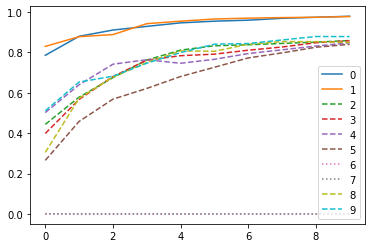

In [361]:
# No gradient sharing

with open(os.path.join(fp_local,'no_sharing.pickle'), 'rb') as handle:
    history = pickle.load(handle)

line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
#     tmp = smooth(history[k],15)
    plt.plot(history[k],label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [372]:
%%time
tf.random.set_seed(0)

m = DistMLP('simple_add')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'simple_add.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
115/115 [==============================] - 17s 146ms/step - loss: 10.2048 - ca1-cl0: 0.3025 - ca1-cl1: 0.2045 - ca1-cl2: 0.0055 - ca1-cl3: 0.0899 - ca1-cl4: 0.1756 - ca1-cl5: 0.1437 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.2277 - ca1-cl9: 0.1924 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.3561 - ca2-cl3: 0.3103 - ca2-cl4: 0.1498 - ca2-cl5: 0.0352 - ca2-cl6: 0.2883 - ca2-cl7: 0.2624 - ca2-cl8: 0.1093 - ca2-cl9: 0.1762 - ca3-cl0: 0.4874 - ca3-cl1: 0.4979 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.2358 - ca3-cl5: 0.1210 - ca3-cl6: 0.0715 - ca3-cl7: 0.0378 - ca3-cl8: 0.1312 - ca3-cl9: 0.0061 - ca4-cl0: 0.1084 - ca4-cl1: 0.2712 - ca4-cl2: 0.0922 - ca4-cl3: 0.1972 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.1170 - ca4-cl7: 0.1219 - ca4-cl8: 0.1264 - ca4-cl9: 0.2498 - val_loss: 4.0566 - val_ca1-cl0: 0.3924 - val_ca1-cl1: 0.4048 - val_ca1-cl2: 0.0185 - val_ca1-cl3: 0.1506 - val_ca1-cl4: 0.2153 - val_ca1-cl5: 0.1987 - val_ca1-c

Epoch 6/300
115/115 [==============================] - 17s 150ms/step - loss: 1.1502 - ca1-cl0: 0.7853 - ca1-cl1: 0.8603 - ca1-cl2: 0.2261 - ca1-cl3: 0.4258 - ca1-cl4: 0.2768 - ca1-cl5: 0.2572 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4443 - ca1-cl9: 0.4893 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.6796 - ca2-cl3: 0.7018 - ca2-cl4: 0.4686 - ca2-cl5: 0.3708 - ca2-cl6: 0.6966 - ca2-cl7: 0.7089 - ca2-cl8: 0.3729 - ca2-cl9: 0.6926 - ca3-cl0: 0.8053 - ca3-cl1: 0.9350 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.6250 - ca3-cl5: 0.6609 - ca3-cl6: 0.5667 - ca3-cl7: 0.6699 - ca3-cl8: 0.3671 - ca3-cl9: 0.4622 - ca4-cl0: 0.8074 - ca4-cl1: 0.8571 - ca4-cl2: 0.6051 - ca4-cl3: 0.5858 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8116 - ca4-cl7: 0.8255 - ca4-cl8: 0.4975 - ca4-cl9: 0.6517 - val_loss: 2.3892 - val_ca1-cl0: 0.8458 - val_ca1-cl1: 0.8804 - val_ca1-cl2: 0.2430 - val_ca1-cl3: 0.4020 - val_ca1-cl4: 0.3068 - val_ca1-cl5: 0.2907 - val_ca1-cl

Epoch 11/300
115/115 [==============================] - 17s 147ms/step - loss: 0.7682 - ca1-cl0: 0.8603 - ca1-cl1: 0.9090 - ca1-cl2: 0.5737 - ca1-cl3: 0.5783 - ca1-cl4: 0.4632 - ca1-cl5: 0.4382 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5820 - ca1-cl9: 0.6008 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8025 - ca2-cl3: 0.8065 - ca2-cl4: 0.6584 - ca2-cl5: 0.6507 - ca2-cl6: 0.7867 - ca2-cl7: 0.8232 - ca2-cl8: 0.6028 - ca2-cl9: 0.7973 - ca3-cl0: 0.8692 - ca3-cl1: 0.9522 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.7603 - ca3-cl5: 0.7748 - ca3-cl6: 0.7587 - ca3-cl7: 0.7849 - ca3-cl8: 0.5466 - ca3-cl9: 0.6321 - ca4-cl0: 0.8539 - ca4-cl1: 0.9147 - ca4-cl2: 0.7048 - ca4-cl3: 0.7062 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8933 - ca4-cl7: 0.8529 - ca4-cl8: 0.6847 - ca4-cl9: 0.7346 - val_loss: 2.4917 - val_ca1-cl0: 0.9048 - val_ca1-cl1: 0.9356 - val_ca1-cl2: 0.6066 - val_ca1-cl3: 0.5829 - val_ca1-cl4: 0.4832 - val_ca1-cl5: 0.4989 - val_ca1-c

Epoch 16/300
115/115 [==============================] - 17s 149ms/step - loss: 0.5602 - ca1-cl0: 0.9010 - ca1-cl1: 0.9509 - ca1-cl2: 0.8019 - ca1-cl3: 0.6922 - ca1-cl4: 0.6882 - ca1-cl5: 0.5809 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6709 - ca1-cl9: 0.6692 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8708 - ca2-cl3: 0.8676 - ca2-cl4: 0.7609 - ca2-cl5: 0.7311 - ca2-cl6: 0.8588 - ca2-cl7: 0.8766 - ca2-cl8: 0.7142 - ca2-cl9: 0.8307 - ca3-cl0: 0.8967 - ca3-cl1: 0.9582 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8373 - ca3-cl5: 0.8430 - ca3-cl6: 0.8572 - ca3-cl7: 0.8277 - ca3-cl8: 0.6768 - ca3-cl9: 0.7193 - ca4-cl0: 0.8806 - ca4-cl1: 0.9250 - ca4-cl2: 0.7734 - ca4-cl3: 0.7657 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9285 - ca4-cl7: 0.8889 - ca4-cl8: 0.7440 - ca4-cl9: 0.7801 - val_loss: 2.7393 - val_ca1-cl0: 0.9295 - val_ca1-cl1: 0.9629 - val_ca1-cl2: 0.8278 - val_ca1-cl3: 0.7113 - val_ca1-cl4: 0.6809 - val_ca1-cl5: 0.6326 - val_ca1-c

Epoch 21/300
115/115 [==============================] - 17s 147ms/step - loss: 0.4435 - ca1-cl0: 0.9295 - ca1-cl1: 0.9616 - ca1-cl2: 0.8528 - ca1-cl3: 0.7573 - ca1-cl4: 0.7841 - ca1-cl5: 0.6778 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7474 - ca1-cl9: 0.7682 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9014 - ca2-cl3: 0.8955 - ca2-cl4: 0.8242 - ca2-cl5: 0.8099 - ca2-cl6: 0.9057 - ca2-cl7: 0.9004 - ca2-cl8: 0.7801 - ca2-cl9: 0.8649 - ca3-cl0: 0.9024 - ca3-cl1: 0.9630 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8669 - ca3-cl5: 0.8862 - ca3-cl6: 0.8912 - ca3-cl7: 0.8545 - ca3-cl8: 0.7558 - ca3-cl9: 0.7709 - ca4-cl0: 0.9010 - ca4-cl1: 0.9427 - ca4-cl2: 0.8184 - ca4-cl3: 0.8176 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9439 - ca4-cl7: 0.9064 - ca4-cl8: 0.7790 - ca4-cl9: 0.8077 - val_loss: 2.8739 - val_ca1-cl0: 0.9479 - val_ca1-cl1: 0.9726 - val_ca1-cl2: 0.8556 - val_ca1-cl3: 0.7857 - val_ca1-cl4: 0.7635 - val_ca1-cl5: 0.7295 - val_ca1-c

Epoch 26/300
115/115 [==============================] - 17s 146ms/step - loss: 0.3746 - ca1-cl0: 0.9459 - ca1-cl1: 0.9644 - ca1-cl2: 0.8781 - ca1-cl3: 0.7820 - ca1-cl4: 0.8393 - ca1-cl5: 0.7570 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7978 - ca1-cl9: 0.8294 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9116 - ca2-cl3: 0.9091 - ca2-cl4: 0.8640 - ca2-cl5: 0.8416 - ca2-cl6: 0.9227 - ca2-cl7: 0.9094 - ca2-cl8: 0.8086 - ca2-cl9: 0.8778 - ca3-cl0: 0.9124 - ca3-cl1: 0.9708 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8888 - ca3-cl5: 0.9121 - ca3-cl6: 0.9103 - ca3-cl7: 0.8784 - ca3-cl8: 0.8037 - ca3-cl9: 0.7972 - ca4-cl0: 0.9213 - ca4-cl1: 0.9487 - ca4-cl2: 0.8369 - ca4-cl3: 0.8450 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9569 - ca4-cl7: 0.9190 - ca4-cl8: 0.7987 - ca4-cl9: 0.8211 - val_loss: 2.9082 - val_ca1-cl0: 0.9622 - val_ca1-cl1: 0.9753 - val_ca1-cl2: 0.8817 - val_ca1-cl3: 0.7899 - val_ca1-cl4: 0.7857 - val_ca1-cl5: 0.8180 - val_ca1-c

Epoch 31/300
115/115 [==============================] - 17s 146ms/step - loss: 0.3305 - ca1-cl0: 0.9505 - ca1-cl1: 0.9690 - ca1-cl2: 0.8844 - ca1-cl3: 0.8096 - ca1-cl4: 0.8621 - ca1-cl5: 0.7998 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8301 - ca1-cl9: 0.8523 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9262 - ca2-cl3: 0.9150 - ca2-cl4: 0.8834 - ca2-cl5: 0.8743 - ca2-cl6: 0.9316 - ca2-cl7: 0.9204 - ca2-cl8: 0.8348 - ca2-cl9: 0.8830 - ca3-cl0: 0.9329 - ca3-cl1: 0.9713 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8999 - ca3-cl5: 0.9199 - ca3-cl6: 0.9143 - ca3-cl7: 0.8987 - ca3-cl8: 0.8278 - ca3-cl9: 0.8200 - ca4-cl0: 0.9319 - ca4-cl1: 0.9475 - ca4-cl2: 0.8594 - ca4-cl3: 0.8635 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9646 - ca4-cl7: 0.9233 - ca4-cl8: 0.8088 - ca4-cl9: 0.8349 - val_loss: 2.9318 - val_ca1-cl0: 0.9622 - val_ca1-cl1: 0.9797 - val_ca1-cl2: 0.9039 - val_ca1-cl3: 0.8315 - val_ca1-cl4: 0.8043 - val_ca1-cl5: 0.8599 - val_ca1-c

Epoch 36/300
115/115 [==============================] - 17s 147ms/step - loss: 0.3000 - ca1-cl0: 0.9508 - ca1-cl1: 0.9701 - ca1-cl2: 0.9014 - ca1-cl3: 0.8313 - ca1-cl4: 0.8699 - ca1-cl5: 0.8333 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8387 - ca1-cl9: 0.8636 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9344 - ca2-cl3: 0.9217 - ca2-cl4: 0.8999 - ca2-cl5: 0.8915 - ca2-cl6: 0.9370 - ca2-cl7: 0.9227 - ca2-cl8: 0.8507 - ca2-cl9: 0.8924 - ca3-cl0: 0.9438 - ca3-cl1: 0.9731 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9082 - ca3-cl5: 0.9299 - ca3-cl6: 0.9151 - ca3-cl7: 0.9091 - ca3-cl8: 0.8497 - ca3-cl9: 0.8256 - ca4-cl0: 0.9353 - ca4-cl1: 0.9505 - ca4-cl2: 0.8814 - ca4-cl3: 0.8799 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9695 - ca4-cl7: 0.9287 - ca4-cl8: 0.8280 - ca4-cl9: 0.8506 - val_loss: 2.9833 - val_ca1-cl0: 0.9642 - val_ca1-cl1: 0.9771 - val_ca1-cl2: 0.9253 - val_ca1-cl3: 0.8404 - val_ca1-cl4: 0.8279 - val_ca1-cl5: 0.8833 - val_ca1-c

Epoch 41/300
115/115 [==============================] - 17s 147ms/step - loss: 0.2758 - ca1-cl0: 0.9571 - ca1-cl1: 0.9723 - ca1-cl2: 0.9029 - ca1-cl3: 0.8500 - ca1-cl4: 0.8887 - ca1-cl5: 0.8668 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8546 - ca1-cl9: 0.8747 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9391 - ca2-cl3: 0.9280 - ca2-cl4: 0.9090 - ca2-cl5: 0.8996 - ca2-cl6: 0.9473 - ca2-cl7: 0.9307 - ca2-cl8: 0.8631 - ca2-cl9: 0.8963 - ca3-cl0: 0.9463 - ca3-cl1: 0.9761 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9161 - ca3-cl5: 0.9348 - ca3-cl6: 0.9224 - ca3-cl7: 0.9219 - ca3-cl8: 0.8601 - ca3-cl9: 0.8395 - ca4-cl0: 0.9396 - ca4-cl1: 0.9524 - ca4-cl2: 0.8865 - ca4-cl3: 0.8855 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9716 - ca4-cl7: 0.9299 - ca4-cl8: 0.8318 - ca4-cl9: 0.8613 - val_loss: 2.9952 - val_ca1-cl0: 0.9724 - val_ca1-cl1: 0.9771 - val_ca1-cl2: 0.9243 - val_ca1-cl3: 0.8580 - val_ca1-cl4: 0.8471 - val_ca1-cl5: 0.9090 - val_ca1-c

Epoch 46/300
115/115 [==============================] - 17s 149ms/step - loss: 0.2565 - ca1-cl0: 0.9613 - ca1-cl1: 0.9738 - ca1-cl2: 0.9021 - ca1-cl3: 0.8512 - ca1-cl4: 0.8979 - ca1-cl5: 0.8783 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8643 - ca1-cl9: 0.8830 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9435 - ca2-cl3: 0.9338 - ca2-cl4: 0.9131 - ca2-cl5: 0.9071 - ca2-cl6: 0.9555 - ca2-cl7: 0.9325 - ca2-cl8: 0.8768 - ca2-cl9: 0.9054 - ca3-cl0: 0.9518 - ca3-cl1: 0.9767 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9236 - ca3-cl5: 0.9344 - ca3-cl6: 0.9272 - ca3-cl7: 0.9309 - ca3-cl8: 0.8753 - ca3-cl9: 0.8503 - ca4-cl0: 0.9431 - ca4-cl1: 0.9525 - ca4-cl2: 0.8872 - ca4-cl3: 0.8936 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9747 - ca4-cl7: 0.9300 - ca4-cl8: 0.8320 - ca4-cl9: 0.8623 - val_loss: 3.0170 - val_ca1-cl0: 0.9755 - val_ca1-cl1: 0.9779 - val_ca1-cl2: 0.9370 - val_ca1-cl3: 0.8771 - val_ca1-cl4: 0.8532 - val_ca1-cl5: 0.9070 - val_ca1-c

Epoch 51/300
115/115 [==============================] - 17s 147ms/step - loss: 0.2417 - ca1-cl0: 0.9630 - ca1-cl1: 0.9756 - ca1-cl2: 0.9147 - ca1-cl3: 0.8610 - ca1-cl4: 0.9007 - ca1-cl5: 0.8964 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8770 - ca1-cl9: 0.8905 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9463 - ca2-cl3: 0.9338 - ca2-cl4: 0.9171 - ca2-cl5: 0.9055 - ca2-cl6: 0.9542 - ca2-cl7: 0.9363 - ca2-cl8: 0.8837 - ca2-cl9: 0.9074 - ca3-cl0: 0.9592 - ca3-cl1: 0.9761 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9223 - ca3-cl5: 0.9441 - ca3-cl6: 0.9321 - ca3-cl7: 0.9346 - ca3-cl8: 0.8794 - ca3-cl9: 0.8595 - ca4-cl0: 0.9509 - ca4-cl1: 0.9585 - ca4-cl2: 0.8926 - ca4-cl3: 0.8956 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9758 - ca4-cl7: 0.9318 - ca4-cl8: 0.8493 - ca4-cl9: 0.8654 - val_loss: 3.0299 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9788 - val_ca1-cl2: 0.9282 - val_ca1-cl3: 0.8741 - val_ca1-cl4: 0.8663 - val_ca1-cl5: 0.9226 - val_ca1-c

Epoch 56/300
115/115 [==============================] - 17s 147ms/step - loss: 0.2295 - ca1-cl0: 0.9646 - ca1-cl1: 0.9762 - ca1-cl2: 0.9159 - ca1-cl3: 0.8709 - ca1-cl4: 0.9102 - ca1-cl5: 0.9074 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8753 - ca1-cl9: 0.8933 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9482 - ca2-cl3: 0.9365 - ca2-cl4: 0.9233 - ca2-cl5: 0.9084 - ca2-cl6: 0.9597 - ca2-cl7: 0.9344 - ca2-cl8: 0.8923 - ca2-cl9: 0.9128 - ca3-cl0: 0.9648 - ca3-cl1: 0.9772 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9318 - ca3-cl5: 0.9449 - ca3-cl6: 0.9355 - ca3-cl7: 0.9391 - ca3-cl8: 0.8892 - ca3-cl9: 0.8657 - ca4-cl0: 0.9543 - ca4-cl1: 0.9598 - ca4-cl2: 0.9010 - ca4-cl3: 0.9017 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9783 - ca4-cl7: 0.9355 - ca4-cl8: 0.8592 - ca4-cl9: 0.8774 - val_loss: 3.0712 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9780 - val_ca1-cl2: 0.9243 - val_ca1-cl3: 0.8801 - val_ca1-cl4: 0.8773 - val_ca1-cl5: 0.9259 - val_ca1-c

Epoch 61/300
115/115 [==============================] - 17s 145ms/step - loss: 0.2191 - ca1-cl0: 0.9671 - ca1-cl1: 0.9775 - ca1-cl2: 0.9161 - ca1-cl3: 0.8762 - ca1-cl4: 0.9134 - ca1-cl5: 0.9093 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8794 - ca1-cl9: 0.9019 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9483 - ca2-cl3: 0.9358 - ca2-cl4: 0.9295 - ca2-cl5: 0.9103 - ca2-cl6: 0.9631 - ca2-cl7: 0.9356 - ca2-cl8: 0.9052 - ca2-cl9: 0.9155 - ca3-cl0: 0.9620 - ca3-cl1: 0.9784 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9346 - ca3-cl5: 0.9457 - ca3-cl6: 0.9429 - ca3-cl7: 0.9428 - ca3-cl8: 0.8897 - ca3-cl9: 0.8652 - ca4-cl0: 0.9558 - ca4-cl1: 0.9610 - ca4-cl2: 0.9071 - ca4-cl3: 0.9112 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9789 - ca4-cl7: 0.9401 - ca4-cl8: 0.8671 - ca4-cl9: 0.8804 - val_loss: 3.1064 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9762 - val_ca1-cl2: 0.9282 - val_ca1-cl3: 0.8669 - val_ca1-cl4: 0.8847 - val_ca1-cl5: 0.9248 - val_ca1-c

Epoch 66/300
115/115 [==============================] - 17s 147ms/step - loss: 0.2093 - ca1-cl0: 0.9671 - ca1-cl1: 0.9796 - ca1-cl2: 0.9121 - ca1-cl3: 0.8778 - ca1-cl4: 0.9197 - ca1-cl5: 0.9105 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8737 - ca1-cl9: 0.9054 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9493 - ca2-cl3: 0.9377 - ca2-cl4: 0.9331 - ca2-cl5: 0.9110 - ca2-cl6: 0.9645 - ca2-cl7: 0.9396 - ca2-cl8: 0.9100 - ca2-cl9: 0.9114 - ca3-cl0: 0.9695 - ca3-cl1: 0.9809 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9382 - ca3-cl5: 0.9497 - ca3-cl6: 0.9475 - ca3-cl7: 0.9441 - ca3-cl8: 0.9001 - ca3-cl9: 0.8715 - ca4-cl0: 0.9572 - ca4-cl1: 0.9640 - ca4-cl2: 0.9139 - ca4-cl3: 0.9153 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9786 - ca4-cl7: 0.9425 - ca4-cl8: 0.8671 - ca4-cl9: 0.8865 - val_loss: 3.1494 - val_ca1-cl0: 0.9806 - val_ca1-cl1: 0.9797 - val_ca1-cl2: 0.9273 - val_ca1-cl3: 0.8651 - val_ca1-cl4: 0.8970 - val_ca1-cl5: 0.9350 - val_ca1-c

Epoch 71/300
115/115 [==============================] - 17s 147ms/step - loss: 0.2020 - ca1-cl0: 0.9699 - ca1-cl1: 0.9805 - ca1-cl2: 0.9195 - ca1-cl3: 0.8821 - ca1-cl4: 0.9249 - ca1-cl5: 0.9132 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8774 - ca1-cl9: 0.9081 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9551 - ca2-cl3: 0.9399 - ca2-cl4: 0.9365 - ca2-cl5: 0.9138 - ca2-cl6: 0.9672 - ca2-cl7: 0.9432 - ca2-cl8: 0.9121 - ca2-cl9: 0.9181 - ca3-cl0: 0.9701 - ca3-cl1: 0.9820 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9395 - ca3-cl5: 0.9511 - ca3-cl6: 0.9463 - ca3-cl7: 0.9455 - ca3-cl8: 0.9002 - ca3-cl9: 0.8758 - ca4-cl0: 0.9579 - ca4-cl1: 0.9647 - ca4-cl2: 0.9200 - ca4-cl3: 0.9162 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9796 - ca4-cl7: 0.9431 - ca4-cl8: 0.8695 - ca4-cl9: 0.8909 - val_loss: 3.1788 - val_ca1-cl0: 0.9805 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.9233 - val_ca1-cl3: 0.8772 - val_ca1-cl4: 0.8949 - val_ca1-cl5: 0.9405 - val_ca1-c

Epoch 76/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1948 - ca1-cl0: 0.9684 - ca1-cl1: 0.9808 - ca1-cl2: 0.9220 - ca1-cl3: 0.8881 - ca1-cl4: 0.9249 - ca1-cl5: 0.9195 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8863 - ca1-cl9: 0.9148 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9554 - ca2-cl3: 0.9414 - ca2-cl4: 0.9379 - ca2-cl5: 0.9162 - ca2-cl6: 0.9665 - ca2-cl7: 0.9473 - ca2-cl8: 0.9177 - ca2-cl9: 0.9188 - ca3-cl0: 0.9736 - ca3-cl1: 0.9839 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9415 - ca3-cl5: 0.9523 - ca3-cl6: 0.9504 - ca3-cl7: 0.9441 - ca3-cl8: 0.8981 - ca3-cl9: 0.8757 - ca4-cl0: 0.9580 - ca4-cl1: 0.9634 - ca4-cl2: 0.9277 - ca4-cl3: 0.9215 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9782 - ca4-cl7: 0.9445 - ca4-cl8: 0.8715 - ca4-cl9: 0.8977 - val_loss: 3.1988 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.9167 - val_ca1-cl3: 0.8703 - val_ca1-cl4: 0.8938 - val_ca1-cl5: 0.9493 - val_ca1-c

Epoch 81/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1888 - ca1-cl0: 0.9705 - ca1-cl1: 0.9814 - ca1-cl2: 0.9269 - ca1-cl3: 0.8902 - ca1-cl4: 0.9264 - ca1-cl5: 0.9231 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8856 - ca1-cl9: 0.9172 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9593 - ca2-cl3: 0.9401 - ca2-cl4: 0.9385 - ca2-cl5: 0.9139 - ca2-cl6: 0.9652 - ca2-cl7: 0.9442 - ca2-cl8: 0.9149 - ca2-cl9: 0.9188 - ca3-cl0: 0.9729 - ca3-cl1: 0.9815 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9433 - ca3-cl5: 0.9530 - ca3-cl6: 0.9490 - ca3-cl7: 0.9512 - ca3-cl8: 0.9043 - ca3-cl9: 0.8793 - ca4-cl0: 0.9550 - ca4-cl1: 0.9635 - ca4-cl2: 0.9321 - ca4-cl3: 0.9268 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9793 - ca4-cl7: 0.9461 - ca4-cl8: 0.8798 - ca4-cl9: 0.8977 - val_loss: 3.2218 - val_ca1-cl0: 0.9837 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.9243 - val_ca1-cl3: 0.8731 - val_ca1-cl4: 0.8981 - val_ca1-cl5: 0.9517 - val_ca1-c

Epoch 86/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1831 - ca1-cl0: 0.9709 - ca1-cl1: 0.9830 - ca1-cl2: 0.9320 - ca1-cl3: 0.8955 - ca1-cl4: 0.9271 - ca1-cl5: 0.9278 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8925 - ca1-cl9: 0.9155 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9588 - ca2-cl3: 0.9428 - ca2-cl4: 0.9427 - ca2-cl5: 0.9174 - ca2-cl6: 0.9658 - ca2-cl7: 0.9454 - ca2-cl8: 0.9211 - ca2-cl9: 0.9181 - ca3-cl0: 0.9756 - ca3-cl1: 0.9833 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9454 - ca3-cl5: 0.9538 - ca3-cl6: 0.9538 - ca3-cl7: 0.9512 - ca3-cl8: 0.9048 - ca3-cl9: 0.8878 - ca4-cl0: 0.9592 - ca4-cl1: 0.9635 - ca4-cl2: 0.9330 - ca4-cl3: 0.9248 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9800 - ca4-cl7: 0.9464 - ca4-cl8: 0.8869 - ca4-cl9: 0.9076 - val_loss: 3.2438 - val_ca1-cl0: 0.9826 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9311 - val_ca1-cl3: 0.8869 - val_ca1-cl4: 0.8978 - val_ca1-cl5: 0.9462 - val_ca1-c

Epoch 91/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1788 - ca1-cl0: 0.9730 - ca1-cl1: 0.9832 - ca1-cl2: 0.9305 - ca1-cl3: 0.9023 - ca1-cl4: 0.9285 - ca1-cl5: 0.9276 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8912 - ca1-cl9: 0.9121 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9594 - ca2-cl3: 0.9453 - ca2-cl4: 0.9406 - ca2-cl5: 0.9216 - ca2-cl6: 0.9678 - ca2-cl7: 0.9461 - ca2-cl8: 0.9233 - ca2-cl9: 0.9193 - ca3-cl0: 0.9749 - ca3-cl1: 0.9833 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9460 - ca3-cl5: 0.9571 - ca3-cl6: 0.9497 - ca3-cl7: 0.9487 - ca3-cl8: 0.9092 - ca3-cl9: 0.8860 - ca4-cl0: 0.9614 - ca4-cl1: 0.9646 - ca4-cl2: 0.9346 - ca4-cl3: 0.9324 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9807 - ca4-cl7: 0.9488 - ca4-cl8: 0.8940 - ca4-cl9: 0.9081 - val_loss: 3.2562 - val_ca1-cl0: 0.9826 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9271 - val_ca1-cl3: 0.8848 - val_ca1-cl4: 0.8982 - val_ca1-cl5: 0.9462 - val_ca1-c

Epoch 96/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1749 - ca1-cl0: 0.9740 - ca1-cl1: 0.9842 - ca1-cl2: 0.9353 - ca1-cl3: 0.9021 - ca1-cl4: 0.9306 - ca1-cl5: 0.9307 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8920 - ca1-cl9: 0.9164 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9618 - ca2-cl3: 0.9457 - ca2-cl4: 0.9461 - ca2-cl5: 0.9213 - ca2-cl6: 0.9666 - ca2-cl7: 0.9485 - ca2-cl8: 0.9191 - ca2-cl9: 0.9254 - ca3-cl0: 0.9756 - ca3-cl1: 0.9833 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9505 - ca3-cl5: 0.9563 - ca3-cl6: 0.9537 - ca3-cl7: 0.9506 - ca3-cl8: 0.9085 - ca3-cl9: 0.8920 - ca4-cl0: 0.9607 - ca4-cl1: 0.9659 - ca4-cl2: 0.9330 - ca4-cl3: 0.9350 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9807 - ca4-cl7: 0.9513 - ca4-cl8: 0.8979 - ca4-cl9: 0.9137 - val_loss: 3.2603 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9225 - val_ca1-cl3: 0.8653 - val_ca1-cl4: 0.9022 - val_ca1-cl5: 0.9528 - val_ca1-c

Epoch 101/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1711 - ca1-cl0: 0.9744 - ca1-cl1: 0.9832 - ca1-cl2: 0.9352 - ca1-cl3: 0.9021 - ca1-cl4: 0.9321 - ca1-cl5: 0.9361 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8917 - ca1-cl9: 0.9191 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9638 - ca2-cl3: 0.9476 - ca2-cl4: 0.9482 - ca2-cl5: 0.9200 - ca2-cl6: 0.9685 - ca2-cl7: 0.9467 - ca2-cl8: 0.9211 - ca2-cl9: 0.9256 - ca3-cl0: 0.9783 - ca3-cl1: 0.9851 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9515 - ca3-cl5: 0.9608 - ca3-cl6: 0.9558 - ca3-cl7: 0.9512 - ca3-cl8: 0.9180 - ca3-cl9: 0.8952 - ca4-cl0: 0.9607 - ca4-cl1: 0.9647 - ca4-cl2: 0.9373 - ca4-cl3: 0.9349 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9821 - ca4-cl7: 0.9471 - ca4-cl8: 0.9004 - ca4-cl9: 0.9127 - val_loss: 3.2750 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9155 - val_ca1-cl3: 0.8880 - val_ca1-cl4: 0.9032 - val_ca1-cl5: 0.9528 - val_ca1-

Epoch 106/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1688 - ca1-cl0: 0.9751 - ca1-cl1: 0.9839 - ca1-cl2: 0.9367 - ca1-cl3: 0.9023 - ca1-cl4: 0.9333 - ca1-cl5: 0.9336 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8857 - ca1-cl9: 0.9196 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9648 - ca2-cl3: 0.9464 - ca2-cl4: 0.9516 - ca2-cl5: 0.9252 - ca2-cl6: 0.9672 - ca2-cl7: 0.9467 - ca2-cl8: 0.9196 - ca2-cl9: 0.9277 - ca3-cl0: 0.9763 - ca3-cl1: 0.9857 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9529 - ca3-cl5: 0.9626 - ca3-cl6: 0.9579 - ca3-cl7: 0.9558 - ca3-cl8: 0.9154 - ca3-cl9: 0.8980 - ca4-cl0: 0.9628 - ca4-cl1: 0.9670 - ca4-cl2: 0.9366 - ca4-cl3: 0.9357 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9824 - ca4-cl7: 0.9498 - ca4-cl8: 0.8984 - ca4-cl9: 0.9082 - val_loss: 3.2846 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9867 - val_ca1-cl2: 0.9283 - val_ca1-cl3: 0.8681 - val_ca1-cl4: 0.9022 - val_ca1-cl5: 0.9617 - val_ca1-

Epoch 111/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1649 - ca1-cl0: 0.9737 - ca1-cl1: 0.9842 - ca1-cl2: 0.9400 - ca1-cl3: 0.9060 - ca1-cl4: 0.9340 - ca1-cl5: 0.9369 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8904 - ca1-cl9: 0.9253 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9638 - ca2-cl3: 0.9482 - ca2-cl4: 0.9504 - ca2-cl5: 0.9255 - ca2-cl6: 0.9713 - ca2-cl7: 0.9531 - ca2-cl8: 0.9217 - ca2-cl9: 0.9296 - ca3-cl0: 0.9749 - ca3-cl1: 0.9857 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9536 - ca3-cl5: 0.9622 - ca3-cl6: 0.9585 - ca3-cl7: 0.9614 - ca3-cl8: 0.9211 - ca3-cl9: 0.8999 - ca4-cl0: 0.9642 - ca4-cl1: 0.9676 - ca4-cl2: 0.9368 - ca4-cl3: 0.9370 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9825 - ca4-cl7: 0.9498 - ca4-cl8: 0.9000 - ca4-cl9: 0.9120 - val_loss: 3.2919 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9302 - val_ca1-cl3: 0.8850 - val_ca1-cl4: 0.9173 - val_ca1-cl5: 0.9630 - val_ca1-

Epoch 116/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1616 - ca1-cl0: 0.9764 - ca1-cl1: 0.9836 - ca1-cl2: 0.9422 - ca1-cl3: 0.9081 - ca1-cl4: 0.9371 - ca1-cl5: 0.9377 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8923 - ca1-cl9: 0.9302 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9655 - ca2-cl3: 0.9480 - ca2-cl4: 0.9538 - ca2-cl5: 0.9269 - ca2-cl6: 0.9706 - ca2-cl7: 0.9511 - ca2-cl8: 0.9251 - ca2-cl9: 0.9261 - ca3-cl0: 0.9749 - ca3-cl1: 0.9863 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9564 - ca3-cl5: 0.9611 - ca3-cl6: 0.9592 - ca3-cl7: 0.9583 - ca3-cl8: 0.9284 - ca3-cl9: 0.9026 - ca4-cl0: 0.9628 - ca4-cl1: 0.9683 - ca4-cl2: 0.9361 - ca4-cl3: 0.9376 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9832 - ca4-cl7: 0.9477 - ca4-cl8: 0.9051 - ca4-cl9: 0.9159 - val_loss: 3.2942 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9320 - val_ca1-cl3: 0.8898 - val_ca1-cl4: 0.9111 - val_ca1-cl5: 0.9630 - val_ca1-

Epoch 121/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1599 - ca1-cl0: 0.9761 - ca1-cl1: 0.9848 - ca1-cl2: 0.9436 - ca1-cl3: 0.9073 - ca1-cl4: 0.9391 - ca1-cl5: 0.9392 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8946 - ca1-cl9: 0.9254 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9625 - ca2-cl3: 0.9497 - ca2-cl4: 0.9538 - ca2-cl5: 0.9242 - ca2-cl6: 0.9733 - ca2-cl7: 0.9537 - ca2-cl8: 0.9266 - ca2-cl9: 0.9264 - ca3-cl0: 0.9776 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9573 - ca3-cl5: 0.9630 - ca3-cl6: 0.9531 - ca3-cl7: 0.9589 - ca3-cl8: 0.9243 - ca3-cl9: 0.8980 - ca4-cl0: 0.9642 - ca4-cl1: 0.9695 - ca4-cl2: 0.9380 - ca4-cl3: 0.9377 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9849 - ca4-cl7: 0.9510 - ca4-cl8: 0.9055 - ca4-cl9: 0.9190 - val_loss: 3.2957 - val_ca1-cl0: 0.9826 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9302 - val_ca1-cl3: 0.8850 - val_ca1-cl4: 0.9123 - val_ca1-cl5: 0.9629 - val_ca1-

Epoch 126/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1571 - ca1-cl0: 0.9761 - ca1-cl1: 0.9854 - ca1-cl2: 0.9441 - ca1-cl3: 0.9116 - ca1-cl4: 0.9369 - ca1-cl5: 0.9431 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8968 - ca1-cl9: 0.9238 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9658 - ca2-cl3: 0.9526 - ca2-cl4: 0.9503 - ca2-cl5: 0.9230 - ca2-cl6: 0.9747 - ca2-cl7: 0.9519 - ca2-cl8: 0.9299 - ca2-cl9: 0.9248 - ca3-cl0: 0.9782 - ca3-cl1: 0.9869 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9564 - ca3-cl5: 0.9626 - ca3-cl6: 0.9593 - ca3-cl7: 0.9616 - ca3-cl8: 0.9249 - ca3-cl9: 0.9007 - ca4-cl0: 0.9635 - ca4-cl1: 0.9695 - ca4-cl2: 0.9387 - ca4-cl3: 0.9404 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9842 - ca4-cl7: 0.9524 - ca4-cl8: 0.9046 - ca4-cl9: 0.9227 - val_loss: 3.3026 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9320 - val_ca1-cl3: 0.8859 - val_ca1-cl4: 0.9084 - val_ca1-cl5: 0.9629 - val_ca1-

Epoch 131/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1547 - ca1-cl0: 0.9772 - ca1-cl1: 0.9836 - ca1-cl2: 0.9462 - ca1-cl3: 0.9122 - ca1-cl4: 0.9375 - ca1-cl5: 0.9445 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9001 - ca1-cl9: 0.9246 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9648 - ca2-cl3: 0.9532 - ca2-cl4: 0.9537 - ca2-cl5: 0.9274 - ca2-cl6: 0.9761 - ca2-cl7: 0.9524 - ca2-cl8: 0.9273 - ca2-cl9: 0.9236 - ca3-cl0: 0.9783 - ca3-cl1: 0.9869 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9567 - ca3-cl5: 0.9627 - ca3-cl6: 0.9592 - ca3-cl7: 0.9570 - ca3-cl8: 0.9228 - ca3-cl9: 0.9047 - ca4-cl0: 0.9677 - ca4-cl1: 0.9695 - ca4-cl2: 0.9416 - ca4-cl3: 0.9425 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9853 - ca4-cl7: 0.9510 - ca4-cl8: 0.9080 - ca4-cl9: 0.9191 - val_loss: 3.3037 - val_ca1-cl0: 0.9827 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9301 - val_ca1-cl3: 0.9068 - val_ca1-cl4: 0.9049 - val_ca1-cl5: 0.9607 - val_ca1-

Epoch 136/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1535 - ca1-cl0: 0.9761 - ca1-cl1: 0.9851 - ca1-cl2: 0.9476 - ca1-cl3: 0.9110 - ca1-cl4: 0.9392 - ca1-cl5: 0.9436 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8995 - ca1-cl9: 0.9264 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9652 - ca2-cl3: 0.9523 - ca2-cl4: 0.9523 - ca2-cl5: 0.9312 - ca2-cl6: 0.9781 - ca2-cl7: 0.9538 - ca2-cl8: 0.9265 - ca2-cl9: 0.9255 - ca3-cl0: 0.9776 - ca3-cl1: 0.9881 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9570 - ca3-cl5: 0.9603 - ca3-cl6: 0.9586 - ca3-cl7: 0.9558 - ca3-cl8: 0.9264 - ca3-cl9: 0.9081 - ca4-cl0: 0.9677 - ca4-cl1: 0.9720 - ca4-cl2: 0.9421 - ca4-cl3: 0.9426 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9842 - ca4-cl7: 0.9537 - ca4-cl8: 0.9082 - ca4-cl9: 0.9238 - val_loss: 3.3054 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9282 - val_ca1-cl3: 0.9078 - val_ca1-cl4: 0.9071 - val_ca1-cl5: 0.9607 - val_ca1-

Epoch 141/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1513 - ca1-cl0: 0.9775 - ca1-cl1: 0.9854 - ca1-cl2: 0.9477 - ca1-cl3: 0.9126 - ca1-cl4: 0.9356 - ca1-cl5: 0.9460 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9002 - ca1-cl9: 0.9274 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9676 - ca2-cl3: 0.9506 - ca2-cl4: 0.9523 - ca2-cl5: 0.9311 - ca2-cl6: 0.9760 - ca2-cl7: 0.9524 - ca2-cl8: 0.9274 - ca2-cl9: 0.9303 - ca3-cl0: 0.9769 - ca3-cl1: 0.9863 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9553 - ca3-cl5: 0.9622 - ca3-cl6: 0.9565 - ca3-cl7: 0.9576 - ca3-cl8: 0.9279 - ca3-cl9: 0.9062 - ca4-cl0: 0.9705 - ca4-cl1: 0.9701 - ca4-cl2: 0.9455 - ca4-cl3: 0.9412 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9846 - ca4-cl7: 0.9547 - ca4-cl8: 0.9082 - ca4-cl9: 0.9239 - val_loss: 3.3083 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9262 - val_ca1-cl3: 0.9038 - val_ca1-cl4: 0.8960 - val_ca1-cl5: 0.9641 - val_ca1-

Epoch 146/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1490 - ca1-cl0: 0.9779 - ca1-cl1: 0.9854 - ca1-cl2: 0.9511 - ca1-cl3: 0.9150 - ca1-cl4: 0.9383 - ca1-cl5: 0.9428 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9025 - ca1-cl9: 0.9272 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9658 - ca2-cl3: 0.9510 - ca2-cl4: 0.9510 - ca2-cl5: 0.9260 - ca2-cl6: 0.9761 - ca2-cl7: 0.9516 - ca2-cl8: 0.9295 - ca2-cl9: 0.9269 - ca3-cl0: 0.9763 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9587 - ca3-cl5: 0.9622 - ca3-cl6: 0.9605 - ca3-cl7: 0.9583 - ca3-cl8: 0.9257 - ca3-cl9: 0.9091 - ca4-cl0: 0.9684 - ca4-cl1: 0.9720 - ca4-cl2: 0.9476 - ca4-cl3: 0.9432 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9849 - ca4-cl7: 0.9537 - ca4-cl8: 0.9110 - ca4-cl9: 0.9191 - val_loss: 3.3131 - val_ca1-cl0: 0.9826 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9252 - val_ca1-cl3: 0.9088 - val_ca1-cl4: 0.9032 - val_ca1-cl5: 0.9596 - val_ca1-

Epoch 151/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1485 - ca1-cl0: 0.9779 - ca1-cl1: 0.9863 - ca1-cl2: 0.9462 - ca1-cl3: 0.9101 - ca1-cl4: 0.9377 - ca1-cl5: 0.9452 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9018 - ca1-cl9: 0.9320 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9696 - ca2-cl3: 0.9539 - ca2-cl4: 0.9502 - ca2-cl5: 0.9289 - ca2-cl6: 0.9768 - ca2-cl7: 0.9543 - ca2-cl8: 0.9302 - ca2-cl9: 0.9263 - ca3-cl0: 0.9783 - ca3-cl1: 0.9886 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9580 - ca3-cl5: 0.9629 - ca3-cl6: 0.9579 - ca3-cl7: 0.9589 - ca3-cl8: 0.9284 - ca3-cl9: 0.9125 - ca4-cl0: 0.9699 - ca4-cl1: 0.9707 - ca4-cl2: 0.9442 - ca4-cl3: 0.9435 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9860 - ca4-cl7: 0.9548 - ca4-cl8: 0.9059 - ca4-cl9: 0.9240 - val_loss: 3.3124 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9271 - val_ca1-cl3: 0.9089 - val_ca1-cl4: 0.9050 - val_ca1-cl5: 0.9607 - val_ca1-

Epoch 156/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1465 - ca1-cl0: 0.9782 - ca1-cl1: 0.9857 - ca1-cl2: 0.9483 - ca1-cl3: 0.9081 - ca1-cl4: 0.9398 - ca1-cl5: 0.9423 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9030 - ca1-cl9: 0.9315 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9675 - ca2-cl3: 0.9549 - ca2-cl4: 0.9509 - ca2-cl5: 0.9335 - ca2-cl6: 0.9775 - ca2-cl7: 0.9530 - ca2-cl8: 0.9337 - ca2-cl9: 0.9283 - ca3-cl0: 0.9783 - ca3-cl1: 0.9874 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9581 - ca3-cl5: 0.9623 - ca3-cl6: 0.9605 - ca3-cl7: 0.9569 - ca3-cl8: 0.9251 - ca3-cl9: 0.9096 - ca4-cl0: 0.9691 - ca4-cl1: 0.9720 - ca4-cl2: 0.9497 - ca4-cl3: 0.9452 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9846 - ca4-cl7: 0.9554 - ca4-cl8: 0.9137 - ca4-cl9: 0.9267 - val_loss: 3.3119 - val_ca1-cl0: 0.9836 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9281 - val_ca1-cl3: 0.9117 - val_ca1-cl4: 0.8968 - val_ca1-cl5: 0.9607 - val_ca1-

Epoch 161/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1457 - ca1-cl0: 0.9775 - ca1-cl1: 0.9869 - ca1-cl2: 0.9469 - ca1-cl3: 0.9141 - ca1-cl4: 0.9455 - ca1-cl5: 0.9430 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9012 - ca1-cl9: 0.9337 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9665 - ca2-cl3: 0.9533 - ca2-cl4: 0.9502 - ca2-cl5: 0.9290 - ca2-cl6: 0.9775 - ca2-cl7: 0.9538 - ca2-cl8: 0.9320 - ca2-cl9: 0.9256 - ca3-cl0: 0.9797 - ca3-cl1: 0.9868 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9552 - ca3-cl5: 0.9652 - ca3-cl6: 0.9599 - ca3-cl7: 0.9589 - ca3-cl8: 0.9242 - ca3-cl9: 0.9128 - ca4-cl0: 0.9698 - ca4-cl1: 0.9732 - ca4-cl2: 0.9470 - ca4-cl3: 0.9465 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9860 - ca4-cl7: 0.9580 - ca4-cl8: 0.9138 - ca4-cl9: 0.9268 - val_loss: 3.3271 - val_ca1-cl0: 0.9796 - val_ca1-cl1: 0.9867 - val_ca1-cl2: 0.9322 - val_ca1-cl3: 0.9058 - val_ca1-cl4: 0.8889 - val_ca1-cl5: 0.9652 - val_ca1-

Epoch 166/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1438 - ca1-cl0: 0.9806 - ca1-cl1: 0.9875 - ca1-cl2: 0.9456 - ca1-cl3: 0.9108 - ca1-cl4: 0.9434 - ca1-cl5: 0.9459 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9057 - ca1-cl9: 0.9343 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9665 - ca2-cl3: 0.9542 - ca2-cl4: 0.9552 - ca2-cl5: 0.9305 - ca2-cl6: 0.9775 - ca2-cl7: 0.9544 - ca2-cl8: 0.9363 - ca2-cl9: 0.9249 - ca3-cl0: 0.9810 - ca3-cl1: 0.9856 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9591 - ca3-cl5: 0.9619 - ca3-cl6: 0.9587 - ca3-cl7: 0.9577 - ca3-cl8: 0.9278 - ca3-cl9: 0.9106 - ca4-cl0: 0.9692 - ca4-cl1: 0.9750 - ca4-cl2: 0.9470 - ca4-cl3: 0.9431 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9863 - ca4-cl7: 0.9567 - ca4-cl8: 0.9139 - ca4-cl9: 0.9288 - val_loss: 3.3260 - val_ca1-cl0: 0.9816 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9350 - val_ca1-cl3: 0.9076 - val_ca1-cl4: 0.9001 - val_ca1-cl5: 0.9619 - val_ca1-

Epoch 171/300
115/115 [==============================] - 17s 149ms/step - loss: 0.1429 - ca1-cl0: 0.9813 - ca1-cl1: 0.9854 - ca1-cl2: 0.9524 - ca1-cl3: 0.9175 - ca1-cl4: 0.9463 - ca1-cl5: 0.9444 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9031 - ca1-cl9: 0.9337 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9655 - ca2-cl3: 0.9542 - ca2-cl4: 0.9530 - ca2-cl5: 0.9309 - ca2-cl6: 0.9808 - ca2-cl7: 0.9550 - ca2-cl8: 0.9343 - ca2-cl9: 0.9235 - ca3-cl0: 0.9797 - ca3-cl1: 0.9863 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9618 - ca3-cl5: 0.9611 - ca3-cl6: 0.9579 - ca3-cl7: 0.9556 - ca3-cl8: 0.9321 - ca3-cl9: 0.9090 - ca4-cl0: 0.9712 - ca4-cl1: 0.9743 - ca4-cl2: 0.9484 - ca4-cl3: 0.9458 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9856 - ca4-cl7: 0.9553 - ca4-cl8: 0.9182 - ca4-cl9: 0.9295 - val_loss: 3.3216 - val_ca1-cl0: 0.9795 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9291 - val_ca1-cl3: 0.9178 - val_ca1-cl4: 0.9092 - val_ca1-cl5: 0.9574 - val_ca1-

Epoch 176/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1423 - ca1-cl0: 0.9809 - ca1-cl1: 0.9869 - ca1-cl2: 0.9477 - ca1-cl3: 0.9174 - ca1-cl4: 0.9454 - ca1-cl5: 0.9452 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9015 - ca1-cl9: 0.9295 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9665 - ca2-cl3: 0.9542 - ca2-cl4: 0.9524 - ca2-cl5: 0.9296 - ca2-cl6: 0.9781 - ca2-cl7: 0.9525 - ca2-cl8: 0.9344 - ca2-cl9: 0.9269 - ca3-cl0: 0.9783 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9573 - ca3-cl5: 0.9645 - ca3-cl6: 0.9619 - ca3-cl7: 0.9596 - ca3-cl8: 0.9305 - ca3-cl9: 0.9108 - ca4-cl0: 0.9705 - ca4-cl1: 0.9768 - ca4-cl2: 0.9470 - ca4-cl3: 0.9477 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9860 - ca4-cl7: 0.9561 - ca4-cl8: 0.9204 - ca4-cl9: 0.9268 - val_loss: 3.3223 - val_ca1-cl0: 0.9775 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9320 - val_ca1-cl3: 0.9238 - val_ca1-cl4: 0.9205 - val_ca1-cl5: 0.9551 - val_ca1-

Epoch 181/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1427 - ca1-cl0: 0.9817 - ca1-cl1: 0.9860 - ca1-cl2: 0.9490 - ca1-cl3: 0.9147 - ca1-cl4: 0.9449 - ca1-cl5: 0.9437 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9081 - ca1-cl9: 0.9265 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9655 - ca2-cl3: 0.9529 - ca2-cl4: 0.9529 - ca2-cl5: 0.9319 - ca2-cl6: 0.9788 - ca2-cl7: 0.9505 - ca2-cl8: 0.9342 - ca2-cl9: 0.9242 - ca3-cl0: 0.9810 - ca3-cl1: 0.9850 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9566 - ca3-cl5: 0.9633 - ca3-cl6: 0.9613 - ca3-cl7: 0.9538 - ca3-cl8: 0.9287 - ca3-cl9: 0.9095 - ca4-cl0: 0.9705 - ca4-cl1: 0.9750 - ca4-cl2: 0.9532 - ca4-cl3: 0.9465 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9860 - ca4-cl7: 0.9560 - ca4-cl8: 0.9204 - ca4-cl9: 0.9288 - val_loss: 3.3214 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9273 - val_ca1-cl3: 0.9128 - val_ca1-cl4: 0.9121 - val_ca1-cl5: 0.9506 - val_ca1-

Epoch 186/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1409 - ca1-cl0: 0.9823 - ca1-cl1: 0.9869 - ca1-cl2: 0.9497 - ca1-cl3: 0.9167 - ca1-cl4: 0.9448 - ca1-cl5: 0.9437 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9092 - ca1-cl9: 0.9302 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9669 - ca2-cl3: 0.9542 - ca2-cl4: 0.9504 - ca2-cl5: 0.9332 - ca2-cl6: 0.9768 - ca2-cl7: 0.9555 - ca2-cl8: 0.9342 - ca2-cl9: 0.9304 - ca3-cl0: 0.9804 - ca3-cl1: 0.9868 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9587 - ca3-cl5: 0.9645 - ca3-cl6: 0.9579 - ca3-cl7: 0.9577 - ca3-cl8: 0.9320 - ca3-cl9: 0.9162 - ca4-cl0: 0.9691 - ca4-cl1: 0.9744 - ca4-cl2: 0.9497 - ca4-cl3: 0.9458 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9870 - ca4-cl7: 0.9597 - ca4-cl8: 0.9238 - ca4-cl9: 0.9265 - val_loss: 3.3334 - val_ca1-cl0: 0.9765 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9234 - val_ca1-cl3: 0.9277 - val_ca1-cl4: 0.9083 - val_ca1-cl5: 0.9573 - val_ca1-

Epoch 191/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1404 - ca1-cl0: 0.9823 - ca1-cl1: 0.9863 - ca1-cl2: 0.9478 - ca1-cl3: 0.9181 - ca1-cl4: 0.9440 - ca1-cl5: 0.9431 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9030 - ca1-cl9: 0.9288 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9669 - ca2-cl3: 0.9536 - ca2-cl4: 0.9557 - ca2-cl5: 0.9333 - ca2-cl6: 0.9754 - ca2-cl7: 0.9576 - ca2-cl8: 0.9350 - ca2-cl9: 0.9275 - ca3-cl0: 0.9782 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9601 - ca3-cl5: 0.9667 - ca3-cl6: 0.9599 - ca3-cl7: 0.9570 - ca3-cl8: 0.9352 - ca3-cl9: 0.9124 - ca4-cl0: 0.9712 - ca4-cl1: 0.9750 - ca4-cl2: 0.9469 - ca4-cl3: 0.9479 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9874 - ca4-cl7: 0.9573 - ca4-cl8: 0.9238 - ca4-cl9: 0.9268 - val_loss: 3.3268 - val_ca1-cl0: 0.9837 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9251 - val_ca1-cl3: 0.9207 - val_ca1-cl4: 0.9070 - val_ca1-cl5: 0.9585 - val_ca1-

Epoch 196/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1383 - ca1-cl0: 0.9834 - ca1-cl1: 0.9878 - ca1-cl2: 0.9504 - ca1-cl3: 0.9184 - ca1-cl4: 0.9446 - ca1-cl5: 0.9436 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9072 - ca1-cl9: 0.9308 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9682 - ca2-cl3: 0.9553 - ca2-cl4: 0.9545 - ca2-cl5: 0.9326 - ca2-cl6: 0.9788 - ca2-cl7: 0.9550 - ca2-cl8: 0.9399 - ca2-cl9: 0.9276 - ca3-cl0: 0.9783 - ca3-cl1: 0.9874 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9625 - ca3-cl5: 0.9641 - ca3-cl6: 0.9627 - ca3-cl7: 0.9577 - ca3-cl8: 0.9310 - ca3-cl9: 0.9130 - ca4-cl0: 0.9705 - ca4-cl1: 0.9756 - ca4-cl2: 0.9511 - ca4-cl3: 0.9526 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9859 - ca4-cl7: 0.9594 - ca4-cl8: 0.9268 - ca4-cl9: 0.9294 - val_loss: 3.3251 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9223 - val_ca1-cl3: 0.9257 - val_ca1-cl4: 0.9061 - val_ca1-cl5: 0.9517 - val_ca1-

Epoch 201/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1384 - ca1-cl0: 0.9827 - ca1-cl1: 0.9878 - ca1-cl2: 0.9491 - ca1-cl3: 0.9147 - ca1-cl4: 0.9469 - ca1-cl5: 0.9430 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9079 - ca1-cl9: 0.9343 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9659 - ca2-cl3: 0.9549 - ca2-cl4: 0.9501 - ca2-cl5: 0.9326 - ca2-cl6: 0.9789 - ca2-cl7: 0.9517 - ca2-cl8: 0.9356 - ca2-cl9: 0.9269 - ca3-cl0: 0.9776 - ca3-cl1: 0.9869 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9593 - ca3-cl5: 0.9660 - ca3-cl6: 0.9633 - ca3-cl7: 0.9609 - ca3-cl8: 0.9298 - ca3-cl9: 0.9162 - ca4-cl0: 0.9719 - ca4-cl1: 0.9762 - ca4-cl2: 0.9470 - ca4-cl3: 0.9491 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9874 - ca4-cl7: 0.9590 - ca4-cl8: 0.9234 - ca4-cl9: 0.9273 - val_loss: 3.3263 - val_ca1-cl0: 0.9775 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9205 - val_ca1-cl3: 0.9316 - val_ca1-cl4: 0.9071 - val_ca1-cl5: 0.9517 - val_ca1-

Epoch 206/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1369 - ca1-cl0: 0.9837 - ca1-cl1: 0.9884 - ca1-cl2: 0.9490 - ca1-cl3: 0.9189 - ca1-cl4: 0.9475 - ca1-cl5: 0.9415 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9081 - ca1-cl9: 0.9329 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9683 - ca2-cl3: 0.9578 - ca2-cl4: 0.9489 - ca2-cl5: 0.9342 - ca2-cl6: 0.9795 - ca2-cl7: 0.9556 - ca2-cl8: 0.9378 - ca2-cl9: 0.9270 - ca3-cl0: 0.9823 - ca3-cl1: 0.9857 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9597 - ca3-cl5: 0.9674 - ca3-cl6: 0.9653 - ca3-cl7: 0.9589 - ca3-cl8: 0.9348 - ca3-cl9: 0.9142 - ca4-cl0: 0.9698 - ca4-cl1: 0.9756 - ca4-cl2: 0.9491 - ca4-cl3: 0.9547 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9870 - ca4-cl7: 0.9587 - ca4-cl8: 0.9296 - ca4-cl9: 0.9288 - val_loss: 3.3229 - val_ca1-cl0: 0.9796 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9137 - val_ca1-cl3: 0.9216 - val_ca1-cl4: 0.9205 - val_ca1-cl5: 0.9539 - val_ca1-

Epoch 211/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1361 - ca1-cl0: 0.9834 - ca1-cl1: 0.9884 - ca1-cl2: 0.9531 - ca1-cl3: 0.9233 - ca1-cl4: 0.9468 - ca1-cl5: 0.9454 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9105 - ca1-cl9: 0.9351 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9692 - ca2-cl3: 0.9569 - ca2-cl4: 0.9551 - ca2-cl5: 0.9333 - ca2-cl6: 0.9774 - ca2-cl7: 0.9583 - ca2-cl8: 0.9383 - ca2-cl9: 0.9262 - ca3-cl0: 0.9796 - ca3-cl1: 0.9886 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9616 - ca3-cl5: 0.9666 - ca3-cl6: 0.9633 - ca3-cl7: 0.9647 - ca3-cl8: 0.9367 - ca3-cl9: 0.9137 - ca4-cl0: 0.9691 - ca4-cl1: 0.9750 - ca4-cl2: 0.9537 - ca4-cl3: 0.9512 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9884 - ca4-cl7: 0.9574 - ca4-cl8: 0.9261 - ca4-cl9: 0.9300 - val_loss: 3.3179 - val_ca1-cl0: 0.9816 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9243 - val_ca1-cl3: 0.9177 - val_ca1-cl4: 0.9174 - val_ca1-cl5: 0.9550 - val_ca1-

Epoch 216/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1357 - ca1-cl0: 0.9841 - ca1-cl1: 0.9896 - ca1-cl2: 0.9511 - ca1-cl3: 0.9208 - ca1-cl4: 0.9448 - ca1-cl5: 0.9475 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9089 - ca1-cl9: 0.9300 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9682 - ca2-cl3: 0.9579 - ca2-cl4: 0.9557 - ca2-cl5: 0.9326 - ca2-cl6: 0.9808 - ca2-cl7: 0.9576 - ca2-cl8: 0.9357 - ca2-cl9: 0.9296 - ca3-cl0: 0.9810 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9608 - ca3-cl5: 0.9689 - ca3-cl6: 0.9674 - ca3-cl7: 0.9634 - ca3-cl8: 0.9353 - ca3-cl9: 0.9171 - ca4-cl0: 0.9677 - ca4-cl1: 0.9744 - ca4-cl2: 0.9526 - ca4-cl3: 0.9519 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9881 - ca4-cl7: 0.9580 - ca4-cl8: 0.9198 - ca4-cl9: 0.9337 - val_loss: 3.3262 - val_ca1-cl0: 0.9745 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9195 - val_ca1-cl3: 0.9275 - val_ca1-cl4: 0.9134 - val_ca1-cl5: 0.9528 - val_ca1-

Epoch 221/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1349 - ca1-cl0: 0.9837 - ca1-cl1: 0.9899 - ca1-cl2: 0.9525 - ca1-cl3: 0.9194 - ca1-cl4: 0.9483 - ca1-cl5: 0.9429 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9138 - ca1-cl9: 0.9317 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9692 - ca2-cl3: 0.9536 - ca2-cl4: 0.9599 - ca2-cl5: 0.9304 - ca2-cl6: 0.9781 - ca2-cl7: 0.9575 - ca2-cl8: 0.9378 - ca2-cl9: 0.9270 - ca3-cl0: 0.9796 - ca3-cl1: 0.9863 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9646 - ca3-cl5: 0.9667 - ca3-cl6: 0.9660 - ca3-cl7: 0.9608 - ca3-cl8: 0.9346 - ca3-cl9: 0.9149 - ca4-cl0: 0.9712 - ca4-cl1: 0.9732 - ca4-cl2: 0.9518 - ca4-cl3: 0.9566 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9891 - ca4-cl7: 0.9577 - ca4-cl8: 0.9259 - ca4-cl9: 0.9323 - val_loss: 3.3210 - val_ca1-cl0: 0.9775 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9254 - val_ca1-cl3: 0.9196 - val_ca1-cl4: 0.9132 - val_ca1-cl5: 0.9518 - val_ca1-

Epoch 226/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1340 - ca1-cl0: 0.9834 - ca1-cl1: 0.9893 - ca1-cl2: 0.9524 - ca1-cl3: 0.9207 - ca1-cl4: 0.9468 - ca1-cl5: 0.9415 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9109 - ca1-cl9: 0.9370 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9675 - ca2-cl3: 0.9556 - ca2-cl4: 0.9619 - ca2-cl5: 0.9342 - ca2-cl6: 0.9788 - ca2-cl7: 0.9550 - ca2-cl8: 0.9371 - ca2-cl9: 0.9310 - ca3-cl0: 0.9803 - ca3-cl1: 0.9851 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9645 - ca3-cl5: 0.9671 - ca3-cl6: 0.9666 - ca3-cl7: 0.9614 - ca3-cl8: 0.9348 - ca3-cl9: 0.9103 - ca4-cl0: 0.9691 - ca4-cl1: 0.9750 - ca4-cl2: 0.9485 - ca4-cl3: 0.9533 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9895 - ca4-cl7: 0.9606 - ca4-cl8: 0.9276 - ca4-cl9: 0.9321 - val_loss: 3.3144 - val_ca1-cl0: 0.9837 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9204 - val_ca1-cl3: 0.9187 - val_ca1-cl4: 0.9121 - val_ca1-cl5: 0.9450 - val_ca1-

Epoch 231/300
115/115 [==============================] - 17s 145ms/step - loss: 0.1334 - ca1-cl0: 0.9834 - ca1-cl1: 0.9884 - ca1-cl2: 0.9519 - ca1-cl3: 0.9201 - ca1-cl4: 0.9468 - ca1-cl5: 0.9430 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9127 - ca1-cl9: 0.9343 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9689 - ca2-cl3: 0.9568 - ca2-cl4: 0.9593 - ca2-cl5: 0.9341 - ca2-cl6: 0.9815 - ca2-cl7: 0.9576 - ca2-cl8: 0.9398 - ca2-cl9: 0.9262 - ca3-cl0: 0.9790 - ca3-cl1: 0.9881 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9595 - ca3-cl5: 0.9666 - ca3-cl6: 0.9687 - ca3-cl7: 0.9601 - ca3-cl8: 0.9339 - ca3-cl9: 0.9158 - ca4-cl0: 0.9705 - ca4-cl1: 0.9732 - ca4-cl2: 0.9538 - ca4-cl3: 0.9553 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9898 - ca4-cl7: 0.9613 - ca4-cl8: 0.9260 - ca4-cl9: 0.9294 - val_loss: 3.3183 - val_ca1-cl0: 0.9826 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9108 - val_ca1-cl3: 0.9276 - val_ca1-cl4: 0.9143 - val_ca1-cl5: 0.9451 - val_ca1-

Epoch 236/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1340 - ca1-cl0: 0.9831 - ca1-cl1: 0.9896 - ca1-cl2: 0.9511 - ca1-cl3: 0.9148 - ca1-cl4: 0.9497 - ca1-cl5: 0.9468 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9135 - ca1-cl9: 0.9274 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9675 - ca2-cl3: 0.9572 - ca2-cl4: 0.9607 - ca2-cl5: 0.9343 - ca2-cl6: 0.9781 - ca2-cl7: 0.9596 - ca2-cl8: 0.9376 - ca2-cl9: 0.9284 - ca3-cl0: 0.9823 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9625 - ca3-cl5: 0.9637 - ca3-cl6: 0.9598 - ca3-cl7: 0.9615 - ca3-cl8: 0.9341 - ca3-cl9: 0.9160 - ca4-cl0: 0.9677 - ca4-cl1: 0.9768 - ca4-cl2: 0.9553 - ca4-cl3: 0.9540 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9877 - ca4-cl7: 0.9626 - ca4-cl8: 0.9296 - ca4-cl9: 0.9343 - val_loss: 3.3149 - val_ca1-cl0: 0.9836 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9167 - val_ca1-cl3: 0.9198 - val_ca1-cl4: 0.9113 - val_ca1-cl5: 0.9495 - val_ca1-

Epoch 241/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1333 - ca1-cl0: 0.9834 - ca1-cl1: 0.9896 - ca1-cl2: 0.9552 - ca1-cl3: 0.9215 - ca1-cl4: 0.9469 - ca1-cl5: 0.9446 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9130 - ca1-cl9: 0.9322 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9658 - ca2-cl3: 0.9539 - ca2-cl4: 0.9579 - ca2-cl5: 0.9341 - ca2-cl6: 0.9795 - ca2-cl7: 0.9595 - ca2-cl8: 0.9336 - ca2-cl9: 0.9269 - ca3-cl0: 0.9789 - ca3-cl1: 0.9893 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9618 - ca3-cl5: 0.9670 - ca3-cl6: 0.9687 - ca3-cl7: 0.9608 - ca3-cl8: 0.9321 - ca3-cl9: 0.9102 - ca4-cl0: 0.9698 - ca4-cl1: 0.9786 - ca4-cl2: 0.9574 - ca4-cl3: 0.9527 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9884 - ca4-cl7: 0.9596 - ca4-cl8: 0.9303 - ca4-cl9: 0.9337 - val_loss: 3.3122 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9155 - val_ca1-cl3: 0.9227 - val_ca1-cl4: 0.8992 - val_ca1-cl5: 0.9495 - val_ca1-

Epoch 246/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1317 - ca1-cl0: 0.9841 - ca1-cl1: 0.9887 - ca1-cl2: 0.9533 - ca1-cl3: 0.9207 - ca1-cl4: 0.9484 - ca1-cl5: 0.9452 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9137 - ca1-cl9: 0.9334 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9689 - ca2-cl3: 0.9562 - ca2-cl4: 0.9593 - ca2-cl5: 0.9377 - ca2-cl6: 0.9782 - ca2-cl7: 0.9589 - ca2-cl8: 0.9363 - ca2-cl9: 0.9242 - ca3-cl0: 0.9823 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9618 - ca3-cl5: 0.9656 - ca3-cl6: 0.9667 - ca3-cl7: 0.9608 - ca3-cl8: 0.9359 - ca3-cl9: 0.9157 - ca4-cl0: 0.9670 - ca4-cl1: 0.9775 - ca4-cl2: 0.9573 - ca4-cl3: 0.9491 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9888 - ca4-cl7: 0.9600 - ca4-cl8: 0.9260 - ca4-cl9: 0.9330 - val_loss: 3.3122 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9251 - val_ca1-cl3: 0.9198 - val_ca1-cl4: 0.9112 - val_ca1-cl5: 0.9528 - val_ca1-

Epoch 251/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1317 - ca1-cl0: 0.9837 - ca1-cl1: 0.9890 - ca1-cl2: 0.9539 - ca1-cl3: 0.9195 - ca1-cl4: 0.9434 - ca1-cl5: 0.9469 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9163 - ca1-cl9: 0.9266 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9686 - ca2-cl3: 0.9545 - ca2-cl4: 0.9572 - ca2-cl5: 0.9349 - ca2-cl6: 0.9802 - ca2-cl7: 0.9575 - ca2-cl8: 0.9336 - ca2-cl9: 0.9297 - ca3-cl0: 0.9796 - ca3-cl1: 0.9893 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9628 - ca3-cl5: 0.9674 - ca3-cl6: 0.9660 - ca3-cl7: 0.9622 - ca3-cl8: 0.9352 - ca3-cl9: 0.9163 - ca4-cl0: 0.9670 - ca4-cl1: 0.9750 - ca4-cl2: 0.9554 - ca4-cl3: 0.9525 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9888 - ca4-cl7: 0.9610 - ca4-cl8: 0.9262 - ca4-cl9: 0.9308 - val_loss: 3.3156 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9117 - val_ca1-cl3: 0.9228 - val_ca1-cl4: 0.9042 - val_ca1-cl5: 0.9484 - val_ca1-

Epoch 256/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1312 - ca1-cl0: 0.9841 - ca1-cl1: 0.9900 - ca1-cl2: 0.9552 - ca1-cl3: 0.9234 - ca1-cl4: 0.9483 - ca1-cl5: 0.9481 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9165 - ca1-cl9: 0.9335 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9689 - ca2-cl3: 0.9552 - ca2-cl4: 0.9587 - ca2-cl5: 0.9364 - ca2-cl6: 0.9788 - ca2-cl7: 0.9575 - ca2-cl8: 0.9356 - ca2-cl9: 0.9256 - ca3-cl0: 0.9783 - ca3-cl1: 0.9893 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9649 - ca3-cl5: 0.9685 - ca3-cl6: 0.9673 - ca3-cl7: 0.9654 - ca3-cl8: 0.9353 - ca3-cl9: 0.9211 - ca4-cl0: 0.9671 - ca4-cl1: 0.9768 - ca4-cl2: 0.9551 - ca4-cl3: 0.9546 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9909 - ca4-cl7: 0.9608 - ca4-cl8: 0.9273 - ca4-cl9: 0.9378 - val_loss: 3.3075 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9867 - val_ca1-cl2: 0.9205 - val_ca1-cl3: 0.9226 - val_ca1-cl4: 0.9104 - val_ca1-cl5: 0.9428 - val_ca1-

Epoch 261/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1306 - ca1-cl0: 0.9858 - ca1-cl1: 0.9890 - ca1-cl2: 0.9586 - ca1-cl3: 0.9181 - ca1-cl4: 0.9484 - ca1-cl5: 0.9476 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9158 - ca1-cl9: 0.9327 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9679 - ca2-cl3: 0.9561 - ca2-cl4: 0.9607 - ca2-cl5: 0.9355 - ca2-cl6: 0.9782 - ca2-cl7: 0.9576 - ca2-cl8: 0.9355 - ca2-cl9: 0.9282 - ca3-cl0: 0.9783 - ca3-cl1: 0.9868 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9636 - ca3-cl5: 0.9641 - ca3-cl6: 0.9661 - ca3-cl7: 0.9634 - ca3-cl8: 0.9367 - ca3-cl9: 0.9155 - ca4-cl0: 0.9684 - ca4-cl1: 0.9781 - ca4-cl2: 0.9566 - ca4-cl3: 0.9525 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9891 - ca4-cl7: 0.9587 - ca4-cl8: 0.9268 - ca4-cl9: 0.9364 - val_loss: 3.3086 - val_ca1-cl0: 0.9877 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9186 - val_ca1-cl3: 0.9187 - val_ca1-cl4: 0.8970 - val_ca1-cl5: 0.9484 - val_ca1-

Epoch 266/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1310 - ca1-cl0: 0.9844 - ca1-cl1: 0.9896 - ca1-cl2: 0.9532 - ca1-cl3: 0.9233 - ca1-cl4: 0.9455 - ca1-cl5: 0.9452 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9146 - ca1-cl9: 0.9334 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9682 - ca2-cl3: 0.9549 - ca2-cl4: 0.9613 - ca2-cl5: 0.9370 - ca2-cl6: 0.9788 - ca2-cl7: 0.9582 - ca2-cl8: 0.9366 - ca2-cl9: 0.9271 - ca3-cl0: 0.9823 - ca3-cl1: 0.9904 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9608 - ca3-cl5: 0.9660 - ca3-cl6: 0.9648 - ca3-cl7: 0.9615 - ca3-cl8: 0.9367 - ca3-cl9: 0.9114 - ca4-cl0: 0.9662 - ca4-cl1: 0.9768 - ca4-cl2: 0.9519 - ca4-cl3: 0.9526 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9895 - ca4-cl7: 0.9603 - ca4-cl8: 0.9309 - ca4-cl9: 0.9364 - val_loss: 3.3093 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9242 - val_ca1-cl3: 0.9119 - val_ca1-cl4: 0.9051 - val_ca1-cl5: 0.9505 - val_ca1-

Epoch 271/300
115/115 [==============================] - 17s 148ms/step - loss: 0.1290 - ca1-cl0: 0.9834 - ca1-cl1: 0.9899 - ca1-cl2: 0.9504 - ca1-cl3: 0.9194 - ca1-cl4: 0.9497 - ca1-cl5: 0.9499 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9166 - ca1-cl9: 0.9336 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9679 - ca2-cl3: 0.9566 - ca2-cl4: 0.9585 - ca2-cl5: 0.9364 - ca2-cl6: 0.9802 - ca2-cl7: 0.9563 - ca2-cl8: 0.9368 - ca2-cl9: 0.9303 - ca3-cl0: 0.9817 - ca3-cl1: 0.9881 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9632 - ca3-cl5: 0.9689 - ca3-cl6: 0.9681 - ca3-cl7: 0.9653 - ca3-cl8: 0.9347 - ca3-cl9: 0.9168 - ca4-cl0: 0.9684 - ca4-cl1: 0.9781 - ca4-cl2: 0.9540 - ca4-cl3: 0.9506 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9891 - ca4-cl7: 0.9616 - ca4-cl8: 0.9287 - ca4-cl9: 0.9343 - val_loss: 3.3030 - val_ca1-cl0: 0.9877 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9156 - val_ca1-cl3: 0.9098 - val_ca1-cl4: 0.9042 - val_ca1-cl5: 0.9517 - val_ca1-

Epoch 276/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1294 - ca1-cl0: 0.9851 - ca1-cl1: 0.9905 - ca1-cl2: 0.9538 - ca1-cl3: 0.9214 - ca1-cl4: 0.9482 - ca1-cl5: 0.9499 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9193 - ca1-cl9: 0.9344 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9689 - ca2-cl3: 0.9565 - ca2-cl4: 0.9593 - ca2-cl5: 0.9386 - ca2-cl6: 0.9795 - ca2-cl7: 0.9575 - ca2-cl8: 0.9329 - ca2-cl9: 0.9305 - ca3-cl0: 0.9790 - ca3-cl1: 0.9886 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9632 - ca3-cl5: 0.9663 - ca3-cl6: 0.9647 - ca3-cl7: 0.9616 - ca3-cl8: 0.9317 - ca3-cl9: 0.9175 - ca4-cl0: 0.9670 - ca4-cl1: 0.9774 - ca4-cl2: 0.9561 - ca4-cl3: 0.9546 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9891 - ca4-cl7: 0.9623 - ca4-cl8: 0.9325 - ca4-cl9: 0.9406 - val_loss: 3.3054 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9225 - val_ca1-cl3: 0.9107 - val_ca1-cl4: 0.9052 - val_ca1-cl5: 0.9484 - val_ca1-

Epoch 281/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1299 - ca1-cl0: 0.9858 - ca1-cl1: 0.9903 - ca1-cl2: 0.9532 - ca1-cl3: 0.9180 - ca1-cl4: 0.9496 - ca1-cl5: 0.9504 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9150 - ca1-cl9: 0.9336 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9668 - ca2-cl3: 0.9556 - ca2-cl4: 0.9593 - ca2-cl5: 0.9348 - ca2-cl6: 0.9774 - ca2-cl7: 0.9563 - ca2-cl8: 0.9355 - ca2-cl9: 0.9283 - ca3-cl0: 0.9803 - ca3-cl1: 0.9886 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9632 - ca3-cl5: 0.9678 - ca3-cl6: 0.9695 - ca3-cl7: 0.9647 - ca3-cl8: 0.9353 - ca3-cl9: 0.9191 - ca4-cl0: 0.9698 - ca4-cl1: 0.9780 - ca4-cl2: 0.9567 - ca4-cl3: 0.9506 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9902 - ca4-cl7: 0.9596 - ca4-cl8: 0.9298 - ca4-cl9: 0.9329 - val_loss: 3.3030 - val_ca1-cl0: 0.9806 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9359 - val_ca1-cl3: 0.9167 - val_ca1-cl4: 0.9042 - val_ca1-cl5: 0.9563 - val_ca1-

Epoch 286/300
115/115 [==============================] - 17s 146ms/step - loss: 0.1279 - ca1-cl0: 0.9851 - ca1-cl1: 0.9918 - ca1-cl2: 0.9525 - ca1-cl3: 0.9222 - ca1-cl4: 0.9491 - ca1-cl5: 0.9513 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9140 - ca1-cl9: 0.9316 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9676 - ca2-cl3: 0.9579 - ca2-cl4: 0.9571 - ca2-cl5: 0.9364 - ca2-cl6: 0.9781 - ca2-cl7: 0.9589 - ca2-cl8: 0.9349 - ca2-cl9: 0.9303 - ca3-cl0: 0.9817 - ca3-cl1: 0.9893 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9628 - ca3-cl5: 0.9726 - ca3-cl6: 0.9680 - ca3-cl7: 0.9622 - ca3-cl8: 0.9374 - ca3-cl9: 0.9182 - ca4-cl0: 0.9677 - ca4-cl1: 0.9781 - ca4-cl2: 0.9581 - ca4-cl3: 0.9553 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9895 - ca4-cl7: 0.9587 - ca4-cl8: 0.9330 - ca4-cl9: 0.9329 - val_loss: 3.2936 - val_ca1-cl0: 0.9775 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9137 - val_ca1-cl3: 0.9236 - val_ca1-cl4: 0.9011 - val_ca1-cl5: 0.9529 - val_ca1-

Epoch 291/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1287 - ca1-cl0: 0.9851 - ca1-cl1: 0.9893 - ca1-cl2: 0.9518 - ca1-cl3: 0.9176 - ca1-cl4: 0.9498 - ca1-cl5: 0.9482 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9144 - ca1-cl9: 0.9329 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9692 - ca2-cl3: 0.9569 - ca2-cl4: 0.9578 - ca2-cl5: 0.9348 - ca2-cl6: 0.9754 - ca2-cl7: 0.9581 - ca2-cl8: 0.9356 - ca2-cl9: 0.9290 - ca3-cl0: 0.9803 - ca3-cl1: 0.9875 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9612 - ca3-cl5: 0.9681 - ca3-cl6: 0.9653 - ca3-cl7: 0.9653 - ca3-cl8: 0.9387 - ca3-cl9: 0.9223 - ca4-cl0: 0.9656 - ca4-cl1: 0.9775 - ca4-cl2: 0.9552 - ca4-cl3: 0.9532 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9916 - ca4-cl7: 0.9616 - ca4-cl8: 0.9276 - ca4-cl9: 0.9385 - val_loss: 3.2915 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9136 - val_ca1-cl3: 0.9335 - val_ca1-cl4: 0.9193 - val_ca1-cl5: 0.9484 - val_ca1-

Epoch 296/300
115/115 [==============================] - 17s 147ms/step - loss: 0.1267 - ca1-cl0: 0.9862 - ca1-cl1: 0.9912 - ca1-cl2: 0.9579 - ca1-cl3: 0.9267 - ca1-cl4: 0.9497 - ca1-cl5: 0.9506 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9180 - ca1-cl9: 0.9363 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9679 - ca2-cl3: 0.9572 - ca2-cl4: 0.9614 - ca2-cl5: 0.9386 - ca2-cl6: 0.9788 - ca2-cl7: 0.9589 - ca2-cl8: 0.9424 - ca2-cl9: 0.9264 - ca3-cl0: 0.9817 - ca3-cl1: 0.9886 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9618 - ca3-cl5: 0.9681 - ca3-cl6: 0.9688 - ca3-cl7: 0.9692 - ca3-cl8: 0.9366 - ca3-cl9: 0.9209 - ca4-cl0: 0.9684 - ca4-cl1: 0.9799 - ca4-cl2: 0.9593 - ca4-cl3: 0.9539 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9902 - ca4-cl7: 0.9626 - ca4-cl8: 0.9312 - ca4-cl9: 0.9349 - val_loss: 3.2968 - val_ca1-cl0: 0.9806 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9098 - val_ca1-cl3: 0.9215 - val_ca1-cl4: 0.9194 - val_ca1-cl5: 0.9529 - val_ca1-

CPU times: user 2h 22min 48s, sys: 1min 57s, total: 2h 24min 45s
Wall time: 1h 24min 32s


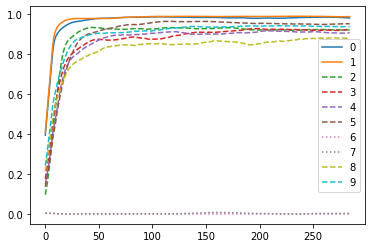

In [374]:
# Share all gradients

with open(os.path.join(fp_local,'simple_add.pickle'), 'rb') as handle:
    history = pickle.load(handle)

line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
    tmp = smooth(history[k],15)[:-15]
    plt.plot(tmp,label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [380]:
%%time
tf.random.set_seed(0)

m = DistMLP('simple_add')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

# with open(os.path.join(fp_local,'simple_add.pickle'), 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
tf.Tensor(
[[[[ 9.03122   6.506774]]

  [[38.729004 17.523489]]

  [[61.98635  34.246696]]]


 [[[27.32518  16.37571 ]]

  [[64.311325 23.7583  ]]

  [[80.98151  38.62506 ]]]


 [[[44.421616  9.03188 ]]

  [[70.47198  20.547045]]

  [[79.49371  29.955559]]]], shape=(3, 3, 1, 2), dtype=float32)
tf.Tensor(
[[[[ 20.669828  69.189415]]

  [[101.71421   97.9725  ]]

  [[166.33669  109.863   ]]]


 [[[ 56.21355   64.85508 ]]

  [[145.26746   81.93154 ]]

  [[179.6493    98.34631 ]]]


 [[[ 81.95468   50.876   ]]

  [[146.81276   64.41208 ]]

  [[156.94997   74.404434]]]], shape=(3, 3, 1, 2), dtype=float32)
  1/115 [..............................] - ETA: 28s - loss: 65.8831 - ca1-cl0: 0.0000e+00 - ca1-cl1: 0.0000e+00 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 1.0000 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.2857 - ca2-cl3: 0.2083 - ca2-cl4: 0.0000

  6/115 [>.............................] - ETA: 10s - loss: 50.7979 - ca1-cl0: 0.0000e+00 - ca1-cl1: 0.0000e+00 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0127 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9359 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.2583 - ca2-cl3: 0.1458 - ca2-cl4: 0.0260 - ca2-cl5: 0.0000e+00 - ca2-cl6: 0.0000e+00 - ca2-cl7: 0.0000e+00 - ca2-cl8: 0.2024 - ca2-cl9: 0.0220 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.0265 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0610 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.0000e+00 - ca4-cl1: 0.2405 - ca4-cl2: 0.0000e+00 - ca4-cl3: 0.1724 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.0000e+00 - ca4-cl7: 0.0000e+00 - ca4-cl8: 0.0779 - ca4-cl9: 0.1250    tf.Tensor(
[[[[ 8.367445  -3.566523 ]]

  [[23.714943   1.1865544]]

  [[34.672955  12.253704 ]]]


 

 11/115 [=>............................] - ETA: 10s - loss: 41.0498 - ca1-cl0: 0.0000e+00 - ca1-cl1: 0.0000e+00 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0154 - ca1-cl5: 0.0076 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7619 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.2542 - ca2-cl3: 0.1727 - ca2-cl4: 0.0276 - ca2-cl5: 0.0000e+00 - ca2-cl6: 0.0076 - ca2-cl7: 0.0068 - ca2-cl8: 0.2045 - ca2-cl9: 0.0252 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0127 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.0211 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0080 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0676 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.0000e+00 - ca4-cl1: 0.3077 - ca4-cl2: 0.0000e+00 - ca4-cl3: 0.2284 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.0000e+00 - ca4-cl7: 0.0077 - ca4-cl8: 0.0741 - ca4-cl9: 0.1667                tf.Tensor(
[[[[ 8.161507   -5.1197443 ]]

  [[19.508392   -5.1737776 ]]

  [[29.343596   -2.9591365 ]]]


 [[[14.

 16/115 [===>..........................] - ETA: 10s - loss: 34.7299 - ca1-cl0: 0.0077 - ca1-cl1: 0.0000e+00 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0796 - ca1-cl5: 0.0781 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6350 - ca1-cl9: 0.0046 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.2315 - ca2-cl3: 0.2363 - ca2-cl4: 0.0385 - ca2-cl5: 0.0000e+00 - ca2-cl6: 0.0249 - ca2-cl7: 0.0369 - ca2-cl8: 0.1946 - ca2-cl9: 0.0365 - ca3-cl0: 0.0498 - ca3-cl1: 0.0591 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.0461 - ca3-cl5: 0.0102 - ca3-cl6: 0.0160 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0758 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.0000e+00 - ca4-cl1: 0.2895 - ca4-cl2: 0.0100 - ca4-cl3: 0.2780 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.0000e+00 - ca4-cl7: 0.0074 - ca4-cl8: 0.1073 - ca4-cl9: 0.2088    tf.Tensor(
[[[[ 6.3511667  -1.4496764 ]]

  [[14.083128    2.2188478 ]]

  [[19.355728    5.2598352 ]]]


 [[[11.673729    0.35969192]]

  [[22.2

KeyboardInterrupt: 

In [365]:
%%time
tf.random.set_seed(0)

m = DistMLP('djgrad')
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'djgrad.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
115/115 [==============================] - 20s 173ms/step - loss: 8.3456 - ca1-cl0: 0.6111 - ca1-cl1: 0.6019 - ca1-cl2: 0.2223 - ca1-cl3: 0.2206 - ca1-cl4: 0.2899 - ca1-cl5: 0.1658 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.1849 - ca1-cl9: 0.2773 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.5024 - ca2-cl3: 0.4742 - ca2-cl4: 0.2131 - ca2-cl5: 0.1130 - ca2-cl6: 0.5584 - ca2-cl7: 0.3928 - ca2-cl8: 0.1144 - ca2-cl9: 0.2876 - ca3-cl0: 0.5356 - ca3-cl1: 0.6645 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.3639 - ca3-cl5: 0.2515 - ca3-cl6: 0.1685 - ca3-cl7: 0.2423 - ca3-cl8: 0.2133 - ca3-cl9: 0.0527 - ca4-cl0: 0.4281 - ca4-cl1: 0.5396 - ca4-cl2: 0.3691 - ca4-cl3: 0.4593 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.4839 - ca4-cl7: 0.6353 - ca4-cl8: 0.4000 - ca4-cl9: 0.4028 - val_loss: 3.9594 - val_ca1-cl0: 0.7845 - val_ca1-cl1: 0.8263 - val_ca1-cl2: 0.4671 - val_ca1-cl3: 0.4361 - val_ca1-cl4: 0.4980 - val_ca1-cl5: 0.2892 - val_ca1-cl6

Epoch 6/10
115/115 [==============================] - 20s 173ms/step - loss: 0.4535 - ca1-cl0: 0.9314 - ca1-cl1: 0.9686 - ca1-cl2: 0.8348 - ca1-cl3: 0.7498 - ca1-cl4: 0.8306 - ca1-cl5: 0.7283 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7674 - ca1-cl9: 0.7815 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9016 - ca2-cl3: 0.8967 - ca2-cl4: 0.8517 - ca2-cl5: 0.8563 - ca2-cl6: 0.9193 - ca2-cl7: 0.8454 - ca2-cl8: 0.7552 - ca2-cl9: 0.8284 - ca3-cl0: 0.8868 - ca3-cl1: 0.9577 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.8525 - ca3-cl5: 0.8062 - ca3-cl6: 0.8571 - ca3-cl7: 0.8427 - ca3-cl8: 0.7257 - ca3-cl9: 0.7198 - ca4-cl0: 0.9222 - ca4-cl1: 0.9530 - ca4-cl2: 0.8808 - ca4-cl3: 0.8442 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9520 - ca4-cl7: 0.9212 - ca4-cl8: 0.8297 - ca4-cl9: 0.8548 - val_loss: 3.1137 - val_ca1-cl0: 0.9519 - val_ca1-cl1: 0.9682 - val_ca1-cl2: 0.8338 - val_ca1-cl3: 0.8147 - val_ca1-cl4: 0.7566 - val_ca1-cl5: 0.7565 - val_ca1-cl6

CPU times: user 5min 15s, sys: 4.16 s, total: 5min 20s
Wall time: 3min 19s


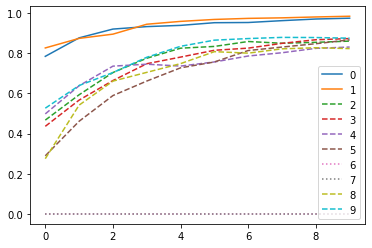

In [366]:
# DJGrad, p=1.0

with open(os.path.join(fp_local,'djgrad.pickle'), 'rb') as handle:
    history = pickle.load(handle)

line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
#     tmp = smooth(history[k],15)[:-15]
    plt.plot(history[k],label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [63]:
tf.random.set_seed(0)

m = DistMLP('djgrad',0.5)
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'djgrad_05.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
115/115 [==============================] - 19s 167ms/step - loss: 3.6722 - ca1-cl0: 0.9584 - ca1-cl1: 0.5947 - ca1-cl2: 0.0116 - ca1-cl3: 0.0113 - ca1-cl4: 0.0092 - ca1-cl5: 0.0182 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0091 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.3990 - ca2-cl3: 0.6932 - ca2-cl4: 0.0097 - ca2-cl5: 0.1858 - ca2-cl6: 0.2405 - ca2-cl7: 0.0000e+00 - ca2-cl8: 0.0028 - ca2-cl9: 0.0862 - ca3-cl0: 0.0163 - ca3-cl1: 0.0202 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9384 - ca3-cl5: 0.0100 - ca3-cl6: 6.7751e-04 - ca3-cl7: 0.0128 - ca3-cl8: 0.0076 - ca3-cl9: 0.0257 - ca4-cl0: 0.2052 - ca4-cl1: 0.3897 - ca4-cl2: 0.3718 - ca4-cl3: 0.0210 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.5994 - ca4-cl7: 0.6427 - ca4-cl8: 0.0107 - ca4-cl9: 0.0354 - val_loss: 2.0597 - val_ca1-cl0: 0.9990 - val_ca1-cl1: 0.9365 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_ca1-

115/115 [==============================] - 19s 165ms/step - loss: 1.5767 - ca1-cl0: 0.9979 - ca1-cl1: 0.6591 - ca1-cl2: 0.0000e+00 - ca1-cl3: 6.6711e-04 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8469 - ca2-cl3: 0.9704 - ca2-cl4: 0.5371 - ca2-cl5: 0.0208 - ca2-cl6: 0.7527 - ca2-cl7: 0.0000e+00 - ca2-cl8: 0.0014 - ca2-cl9: 0.1191 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9979 - ca4-cl1: 0.8108 - ca4-cl2: 0.5725 - ca4-cl3: 0.0671 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8154 - ca4-cl7: 0.5986 - ca4-cl8: 0.0014 - ca4-cl9: 0.0000e+00 - val_loss: 1.9968 - val_ca1-cl0: 1.0000 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 

115/115 [==============================] - 19s 164ms/step - loss: 1.3966 - ca1-cl0: 0.7118 - ca1-cl1: 0.6808 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0631 - ca1-cl9: 0.9424 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8777 - ca2-cl3: 0.7927 - ca2-cl4: 0.6042 - ca2-cl5: 0.0067 - ca2-cl6: 0.8781 - ca2-cl7: 0.9826 - ca2-cl8: 0.0145 - ca2-cl9: 0.3166 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.8507 - ca4-cl2: 0.6265 - ca4-cl3: 0.5600 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8726 - ca4-cl7: 0.6126 - ca4-cl8: 0.0350 - ca4-cl9: 6.9444e-04 - val_loss: 2.0000 - val_ca1-cl0: 0.9479 - val_ca1-cl1: 0.9761 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 9.9108e-04 - val_ca1-cl

115/115 [==============================] - 19s 165ms/step - loss: 1.2618 - ca1-cl0: 0.8753 - ca1-cl1: 0.6677 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0013 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9979 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9139 - ca2-cl3: 0.8455 - ca2-cl4: 0.6574 - ca2-cl5: 0.6357 - ca2-cl6: 0.8793 - ca2-cl7: 0.6319 - ca2-cl8: 0.9257 - ca2-cl9: 0.4739 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9944 - ca4-cl1: 0.8622 - ca4-cl2: 0.6218 - ca4-cl3: 0.6087 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8835 - ca4-cl7: 0.6525 - ca4-cl8: 0.3360 - ca4-cl9: 0.0000e+00 - val_loss: 2.1384 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9075 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 9.9108e-04 - val_ca1-cl

115/115 [==============================] - 19s 165ms/step - loss: 1.1610 - ca1-cl0: 0.8717 - ca1-cl1: 0.6864 - ca1-cl2: 0.0014 - ca1-cl3: 0.1773 - ca1-cl4: 0.0000e+00 - ca1-cl5: 7.5700e-04 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.8068 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9512 - ca2-cl3: 0.8680 - ca2-cl4: 0.8135 - ca2-cl5: 0.8491 - ca2-cl6: 0.9147 - ca2-cl7: 0.7037 - ca2-cl8: 0.9718 - ca2-cl9: 0.6463 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.0000e+00 - ca4-cl1: 0.9072 - ca4-cl2: 0.6488 - ca4-cl3: 0.6569 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8941 - ca4-cl7: 0.6686 - ca4-cl8: 0.5964 - ca4-cl9: 0.9841 - val_loss: 2.3483 - val_ca1-cl0: 0.9795 - val_ca1-cl1: 0.9823 - val_ca1-cl2: 9.7087e-04 - val_ca1-cl3: 1.0000 - val_ca1-cl4: 0.000

115/115 [==============================] - 19s 165ms/step - loss: 1.0955 - ca1-cl0: 0.8587 - ca1-cl1: 0.6770 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.9993 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9478 - ca2-cl3: 0.9051 - ca2-cl4: 0.8276 - ca2-cl5: 0.8599 - ca2-cl6: 0.9306 - ca2-cl7: 0.7043 - ca2-cl8: 0.9684 - ca2-cl9: 0.6295 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.6718 - ca4-cl1: 0.8989 - ca4-cl2: 0.8411 - ca4-cl3: 0.7824 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9020 - ca4-cl7: 0.6884 - ca4-cl8: 0.6902 - ca4-cl9: 0.9764 - val_loss: 2.3983 - val_ca1-cl0: 0.9877 - val_ca1-cl1: 0.9718 - val_ca1-cl2: 0.0029 - val_ca1-cl3: 0.9970 - val_ca1-cl4: 0.000

115/115 [==============================] - 19s 165ms/step - loss: 1.0089 - ca1-cl0: 0.9051 - ca1-cl1: 0.6889 - ca1-cl2: 0.0014 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9756 - ca2-cl3: 0.9374 - ca2-cl4: 0.8850 - ca2-cl5: 0.8416 - ca2-cl6: 0.9401 - ca2-cl7: 0.8711 - ca2-cl8: 0.7975 - ca2-cl9: 0.8647 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8620 - ca4-cl1: 0.9050 - ca4-cl2: 0.8859 - ca4-cl3: 0.7904 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9558 - ca4-cl7: 0.9908 - ca4-cl8: 0.7441 - ca4-cl9: 0.6459 - val_loss: 2.6119 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.0019 - val_ca1-cl3: 0.9980 - val_ca1-cl4: 0.0000e+0

115/115 [==============================] - 19s 166ms/step - loss: 0.9966 - ca1-cl0: 0.8988 - ca1-cl1: 0.6915 - ca1-cl2: 0.0034 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 7.5758e-04 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9668 - ca2-cl3: 0.9279 - ca2-cl4: 0.8911 - ca2-cl5: 0.8438 - ca2-cl6: 0.9421 - ca2-cl7: 0.9942 - ca2-cl8: 0.8519 - ca2-cl9: 0.8709 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8744 - ca4-cl1: 0.9166 - ca4-cl2: 0.8685 - ca4-cl3: 0.8195 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9670 - ca4-cl7: 0.9964 - ca4-cl8: 0.8091 - ca4-cl9: 0.6516 - val_loss: 2.6787 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.0078 - val_ca1-cl3: 0.9980 - val_ca1-cl4: 0.0000e+0

115/115 [==============================] - 19s 166ms/step - loss: 0.9895 - ca1-cl0: 0.8906 - ca1-cl1: 0.6868 - ca1-cl2: 6.8446e-04 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0091 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9708 - ca2-cl3: 0.9403 - ca2-cl4: 0.9224 - ca2-cl5: 0.8832 - ca2-cl6: 0.9373 - ca2-cl7: 0.9942 - ca2-cl8: 0.8770 - ca2-cl9: 0.9361 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9043 - ca4-cl1: 0.8828 - ca4-cl2: 0.8929 - ca4-cl3: 0.8259 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9614 - ca4-cl7: 0.9937 - ca4-cl8: 0.8033 - ca4-cl9: 0.7914 - val_loss: 2.8051 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9858 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 1.0000 - val_ca1-cl4: 0.000

115/115 [==============================] - 19s 166ms/step - loss: 0.9535 - ca1-cl0: 0.9002 - ca1-cl1: 0.6906 - ca1-cl2: 0.0378 - ca1-cl3: 0.9960 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0014 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9735 - ca2-cl3: 0.9415 - ca2-cl4: 0.9474 - ca2-cl5: 0.8766 - ca2-cl6: 0.9530 - ca2-cl7: 0.9968 - ca2-cl8: 0.8760 - ca2-cl9: 0.9411 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8884 - ca4-cl1: 0.9328 - ca4-cl2: 0.8884 - ca4-cl3: 0.8494 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9571 - ca4-cl7: 0.9980 - ca4-cl8: 0.8824 - ca4-cl9: 0.8728 - val_loss: 2.9741 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.0979 - val_ca1-cl3: 0.9881 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 164ms/step - loss: 0.9204 - ca1-cl0: 0.8792 - ca1-cl1: 0.6973 - ca1-cl2: 0.6411 - ca1-cl3: 0.9847 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 7.0225e-04 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9773 - ca2-cl3: 0.9602 - ca2-cl4: 0.9473 - ca2-cl5: 0.9309 - ca2-cl6: 0.9394 - ca2-cl7: 0.9037 - ca2-cl8: 0.9842 - ca2-cl9: 0.9668 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8946 - ca4-cl1: 0.9608 - ca4-cl2: 0.8905 - ca4-cl3: 0.8755 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9687 - ca4-cl7: 0.9980 - ca4-cl8: 0.8504 - ca4-cl9: 0.8787 - val_loss: 3.0293 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9496 - val_ca1-cl3: 0.9603 - val_ca1-cl4: 0.0000e+0

115/115 [==============================] - 19s 165ms/step - loss: 0.9057 - ca1-cl0: 0.8919 - ca1-cl1: 0.6960 - ca1-cl2: 0.6422 - ca1-cl3: 0.9947 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0021 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9715 - ca2-cl3: 0.9549 - ca2-cl4: 0.9598 - ca2-cl5: 0.9643 - ca2-cl6: 0.9645 - ca2-cl7: 0.9000 - ca2-cl8: 0.9945 - ca2-cl9: 0.9838 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8842 - ca4-cl1: 0.9674 - ca4-cl2: 0.8971 - ca4-cl3: 0.8834 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9705 - ca4-cl7: 0.9997 - ca4-cl8: 0.8784 - ca4-cl9: 0.8951 - val_loss: 3.0167 - val_ca1-cl0: 0.8088 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9282 - val_ca1-cl3: 0.9841 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 166ms/step - loss: 0.8885 - ca1-cl0: 0.8874 - ca1-cl1: 0.6965 - ca1-cl2: 0.6671 - ca1-cl3: 0.9933 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9875 - ca2-cl3: 0.9733 - ca2-cl4: 0.9668 - ca2-cl5: 0.9561 - ca2-cl6: 0.9761 - ca2-cl7: 0.9004 - ca2-cl8: 0.9917 - ca2-cl9: 0.9925 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9093 - ca4-cl1: 0.9675 - ca4-cl2: 0.9073 - ca4-cl3: 0.8854 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9737 - ca4-cl7: 0.9993 - ca4-cl8: 0.8705 - ca4-cl9: 0.9203 - val_loss: 3.0564 - val_ca1-cl0: 0.9888 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9543 - val_ca1-cl3: 0.9752 - val_ca1-cl4: 0.0000e+0

115/115 [==============================] - 19s 165ms/step - loss: 0.9122 - ca1-cl0: 0.9174 - ca1-cl1: 0.6806 - ca1-cl2: 0.6820 - ca1-cl3: 0.9853 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0491 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9732 - ca2-cl3: 0.9619 - ca2-cl4: 0.9189 - ca2-cl5: 0.9345 - ca2-cl6: 0.9401 - ca2-cl7: 0.9026 - ca2-cl8: 0.9752 - ca2-cl9: 0.9294 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.8999 - ca4-cl1: 0.9669 - ca4-cl2: 0.9030 - ca4-cl3: 0.8861 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9692 - ca4-cl7: 0.9987 - ca4-cl8: 0.8773 - ca4-cl9: 0.9127 - val_loss: 3.0418 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9291 - val_ca1-cl3: 0.9881 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 166ms/step - loss: 0.8571 - ca1-cl0: 0.9113 - ca1-cl1: 0.7005 - ca1-cl2: 0.6984 - ca1-cl3: 0.9887 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.3155 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9715 - ca2-cl3: 0.9724 - ca2-cl4: 0.9585 - ca2-cl5: 0.9746 - ca2-cl6: 0.9530 - ca2-cl7: 0.9974 - ca2-cl8: 0.9504 - ca2-cl9: 0.9918 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9498 - ca4-cl1: 0.9700 - ca4-cl2: 0.9063 - ca4-cl3: 0.9044 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9712 - ca4-cl7: 0.9967 - ca4-cl8: 0.9430 - ca4-cl9: 0.9285 - val_loss: 3.0394 - val_ca1-cl0: 0.9878 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9273 - val_ca1-cl3: 0.9871 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 164ms/step - loss: 0.8610 - ca1-cl0: 0.8992 - ca1-cl1: 0.6996 - ca1-cl2: 0.6918 - ca1-cl3: 0.9887 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4070 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9783 - ca2-cl3: 0.9697 - ca2-cl4: 0.9576 - ca2-cl5: 0.9546 - ca2-cl6: 0.9680 - ca2-cl7: 0.9974 - ca2-cl8: 0.9518 - ca2-cl9: 0.9803 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9713 - ca4-cl1: 0.9742 - ca4-cl2: 0.9183 - ca4-cl3: 0.9045 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9715 - ca4-cl7: 0.9987 - ca4-cl8: 0.9572 - ca4-cl9: 0.9260 - val_loss: 3.0909 - val_ca1-cl0: 0.9877 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9428 - val_ca1-cl3: 0.9822 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8414 - ca1-cl0: 0.8952 - ca1-cl1: 0.6972 - ca1-cl2: 0.6888 - ca1-cl3: 0.9846 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4483 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9780 - ca2-cl3: 0.9744 - ca2-cl4: 0.9682 - ca2-cl5: 0.9635 - ca2-cl6: 0.9646 - ca2-cl7: 0.9987 - ca2-cl8: 0.9621 - ca2-cl9: 0.9891 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9546 - ca4-cl1: 0.9730 - ca4-cl2: 0.9270 - ca4-cl3: 0.8986 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9695 - ca4-cl7: 0.9970 - ca4-cl8: 0.9550 - ca4-cl9: 0.9431 - val_loss: 3.1584 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9757 - val_ca1-cl3: 0.9643 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8239 - ca1-cl0: 0.9137 - ca1-cl1: 0.6996 - ca1-cl2: 0.6909 - ca1-cl3: 0.9927 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4772 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9864 - ca2-cl3: 0.9783 - ca2-cl4: 0.9653 - ca2-cl5: 0.9718 - ca2-cl6: 0.9681 - ca2-cl7: 0.9974 - ca2-cl8: 0.9628 - ca2-cl9: 0.9864 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9448 - ca4-cl1: 0.9908 - ca4-cl2: 0.9387 - ca4-cl3: 0.9057 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9684 - ca4-cl7: 0.9954 - ca4-cl8: 0.9622 - ca4-cl9: 0.9584 - val_loss: 3.2400 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9437 - val_ca1-cl3: 0.9643 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8226 - ca1-cl0: 0.9092 - ca1-cl1: 0.6900 - ca1-cl2: 0.6953 - ca1-cl3: 0.9927 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4814 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9780 - ca2-cl3: 0.9816 - ca2-cl4: 0.9571 - ca2-cl5: 0.9584 - ca2-cl6: 0.9666 - ca2-cl7: 0.9974 - ca2-cl8: 0.9663 - ca2-cl9: 0.9844 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9644 - ca4-cl1: 0.9896 - ca4-cl2: 0.9615 - ca4-cl3: 0.9343 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9723 - ca4-cl7: 0.9677 - ca4-cl8: 0.9579 - ca4-cl9: 0.9597 - val_loss: 3.2886 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9651 - val_ca1-cl3: 0.9743 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8341 - ca1-cl0: 0.8872 - ca1-cl1: 0.6915 - ca1-cl2: 0.6585 - ca1-cl3: 0.9960 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4105 - ca1-cl9: 6.9348e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9841 - ca2-cl3: 0.9760 - ca2-cl4: 0.9854 - ca2-cl5: 0.9695 - ca2-cl6: 0.9694 - ca2-cl7: 0.9987 - ca2-cl8: 0.9574 - ca2-cl9: 0.9912 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9596 - ca4-cl1: 0.9890 - ca4-cl2: 0.9532 - ca4-cl3: 0.9770 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9730 - ca4-cl7: 0.9651 - ca4-cl8: 0.9579 - ca4-cl9: 0.9597 - val_loss: 3.2294 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9467 - val_ca1-cl3: 0.9812 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8339 - ca1-cl0: 0.8905 - ca1-cl1: 0.6909 - ca1-cl2: 0.6758 - ca1-cl3: 0.9960 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4628 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9803 - ca2-cl3: 0.9783 - ca2-cl4: 0.9709 - ca2-cl5: 0.9657 - ca2-cl6: 0.9735 - ca2-cl7: 0.9981 - ca2-cl8: 0.9553 - ca2-cl9: 0.9837 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9603 - ca4-cl1: 0.9914 - ca4-cl2: 0.9388 - ca4-cl3: 0.9451 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9743 - ca4-cl7: 0.9529 - ca4-cl8: 0.9593 - ca4-cl9: 0.9631 - val_loss: 3.2680 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9670 - val_ca1-cl3: 0.9762 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8245 - ca1-cl0: 0.8801 - ca1-cl1: 0.7003 - ca1-cl2: 0.6911 - ca1-cl3: 0.9927 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4460 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9820 - ca2-cl3: 0.9868 - ca2-cl4: 0.9800 - ca2-cl5: 0.9628 - ca2-cl6: 0.9735 - ca2-cl7: 0.9994 - ca2-cl8: 0.9600 - ca2-cl9: 0.9851 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9574 - ca4-cl1: 0.9969 - ca4-cl2: 0.9684 - ca4-cl3: 0.9716 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9666 - ca4-cl7: 0.9644 - ca4-cl8: 0.9765 - ca4-cl9: 0.9716 - val_loss: 3.2645 - val_ca1-cl0: 0.9816 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9593 - val_ca1-cl3: 0.9713 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8241 - ca1-cl0: 0.9058 - ca1-cl1: 0.7004 - ca1-cl2: 0.5412 - ca1-cl3: 0.9980 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4884 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9888 - ca2-cl3: 0.9776 - ca2-cl4: 0.9834 - ca2-cl5: 0.9777 - ca2-cl6: 0.9686 - ca2-cl7: 1.0000 - ca2-cl8: 0.9676 - ca2-cl9: 0.9919 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9546 - ca4-cl1: 0.9902 - ca4-cl2: 0.9677 - ca4-cl3: 0.9709 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9625 - ca4-cl7: 0.9625 - ca4-cl8: 0.9650 - ca4-cl9: 0.9646 - val_loss: 3.3170 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9956 - val_ca1-cl2: 0.8798 - val_ca1-cl3: 0.9722 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8194 - ca1-cl0: 0.9017 - ca1-cl1: 0.6909 - ca1-cl2: 0.5754 - ca1-cl3: 0.9967 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4828 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9854 - ca2-cl3: 0.9891 - ca2-cl4: 0.9820 - ca2-cl5: 0.9725 - ca2-cl6: 0.9693 - ca2-cl7: 0.9974 - ca2-cl8: 0.9690 - ca2-cl9: 0.9810 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9596 - ca4-cl1: 0.9976 - ca4-cl2: 0.9746 - ca4-cl3: 0.9932 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9758 - ca4-cl7: 0.9664 - ca4-cl8: 0.9756 - ca4-cl9: 0.9612 - val_loss: 3.4161 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9428 - val_ca1-cl3: 0.9851 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8089 - ca1-cl0: 0.9036 - ca1-cl1: 0.6817 - ca1-cl2: 0.6881 - ca1-cl3: 0.9993 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4705 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9895 - ca2-cl3: 0.9914 - ca2-cl4: 0.9834 - ca2-cl5: 0.9777 - ca2-cl6: 0.9796 - ca2-cl7: 0.9994 - ca2-cl8: 0.9711 - ca2-cl9: 0.9885 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9609 - ca4-cl1: 0.9951 - ca4-cl2: 0.9587 - ca4-cl3: 0.9966 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9733 - ca4-cl7: 0.9783 - ca4-cl8: 0.9778 - ca4-cl9: 0.9632 - val_loss: 3.4312 - val_ca1-cl0: 0.9724 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9554 - val_ca1-cl3: 0.9901 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8244 - ca1-cl0: 0.8903 - ca1-cl1: 0.6966 - ca1-cl2: 0.6824 - ca1-cl3: 0.9993 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4747 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9695 - ca2-cl3: 0.9678 - ca2-cl4: 0.9765 - ca2-cl5: 0.9665 - ca2-cl6: 0.9748 - ca2-cl7: 0.9974 - ca2-cl8: 0.9552 - ca2-cl9: 0.9857 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9539 - ca4-cl1: 0.9914 - ca4-cl2: 0.9622 - ca4-cl3: 1.0000 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9723 - ca4-cl7: 0.9881 - ca4-cl8: 0.9737 - ca4-cl9: 0.9736 - val_loss: 3.4662 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9929 - val_ca1-cl2: 0.9661 - val_ca1-cl3: 0.9802 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 166ms/step - loss: 0.8074 - ca1-cl0: 0.8988 - ca1-cl1: 0.6995 - ca1-cl2: 0.6148 - ca1-cl3: 0.9980 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5063 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9922 - ca2-cl3: 0.9868 - ca2-cl4: 0.9827 - ca2-cl5: 0.9732 - ca2-cl6: 0.9857 - ca2-cl7: 0.9987 - ca2-cl8: 0.9738 - ca2-cl9: 0.9891 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9672 - ca4-cl1: 0.9994 - ca4-cl2: 0.9588 - ca4-cl3: 0.9993 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9779 - ca4-cl7: 0.9842 - ca4-cl8: 0.9765 - ca4-cl9: 0.9695 - val_loss: 3.5175 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9757 - val_ca1-cl3: 0.9732 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 166ms/step - loss: 0.8018 - ca1-cl0: 0.9075 - ca1-cl1: 0.6963 - ca1-cl2: 0.6956 - ca1-cl3: 0.9993 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4747 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9888 - ca2-cl3: 0.9891 - ca2-cl4: 0.9861 - ca2-cl5: 0.9784 - ca2-cl6: 0.9741 - ca2-cl7: 1.0000 - ca2-cl8: 0.9717 - ca2-cl9: 0.9919 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9623 - ca4-cl1: 0.9939 - ca4-cl2: 0.9657 - ca4-cl3: 0.9993 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9737 - ca4-cl7: 0.9934 - ca4-cl8: 0.9722 - ca4-cl9: 0.9805 - val_loss: 3.5538 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.9742 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 164ms/step - loss: 0.8248 - ca1-cl0: 0.9110 - ca1-cl1: 0.7019 - ca1-cl2: 0.6895 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4681 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9884 - ca2-cl3: 0.9754 - ca2-cl4: 0.9806 - ca2-cl5: 0.9500 - ca2-cl6: 0.9721 - ca2-cl7: 0.9935 - ca2-cl8: 0.9505 - ca2-cl9: 0.9674 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9618 - ca4-cl1: 0.9969 - ca4-cl2: 0.9711 - ca4-cl3: 1.0000 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9772 - ca4-cl7: 0.9927 - ca4-cl8: 0.9764 - ca4-cl9: 0.9653 - val_loss: 3.5911 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9776 - val_ca1-cl3: 0.9742 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8132 - ca1-cl0: 0.9047 - ca1-cl1: 0.6812 - ca1-cl2: 0.5274 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4786 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9959 - ca2-cl3: 0.9859 - ca2-cl4: 0.9868 - ca2-cl5: 0.9762 - ca2-cl6: 0.9789 - ca2-cl7: 0.9968 - ca2-cl8: 0.9663 - ca2-cl9: 0.9640 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9721 - ca4-cl1: 0.9963 - ca4-cl2: 0.9677 - ca4-cl3: 0.9769 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9754 - ca4-cl7: 0.9881 - ca4-cl8: 0.9843 - ca4-cl9: 0.9993 - val_loss: 3.4997 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9920 - val_ca1-cl2: 0.9573 - val_ca1-cl3: 0.9821 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 164ms/step - loss: 0.8085 - ca1-cl0: 0.8882 - ca1-cl1: 0.6939 - ca1-cl2: 0.6783 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4891 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9919 - ca2-cl3: 0.9895 - ca2-cl4: 0.9903 - ca2-cl5: 0.9829 - ca2-cl6: 0.9850 - ca2-cl7: 0.9994 - ca2-cl8: 0.9711 - ca2-cl9: 0.9959 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9720 - ca4-cl1: 0.9982 - ca4-cl2: 0.9629 - ca4-cl3: 0.9716 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9740 - ca4-cl7: 0.9848 - ca4-cl8: 0.9836 - ca4-cl9: 0.9944 - val_loss: 3.5746 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9956 - val_ca1-cl2: 0.9641 - val_ca1-cl3: 0.9811 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8176 - ca1-cl0: 0.8907 - ca1-cl1: 0.6805 - ca1-cl2: 0.6193 - ca1-cl3: 0.9967 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4312 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9956 - ca2-cl3: 0.9882 - ca2-cl4: 0.9875 - ca2-cl5: 0.9799 - ca2-cl6: 0.9837 - ca2-cl7: 0.9987 - ca2-cl8: 0.9677 - ca2-cl9: 0.9939 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9762 - ca4-cl1: 0.9975 - ca4-cl2: 0.9677 - ca4-cl3: 0.9587 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9691 - ca4-cl7: 0.9898 - ca4-cl8: 0.9700 - ca4-cl9: 0.9979 - val_loss: 3.5736 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.4495 - val_ca1-cl3: 0.9861 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8295 - ca1-cl0: 0.8947 - ca1-cl1: 0.6928 - ca1-cl2: 0.7019 - ca1-cl3: 0.9960 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5158 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9847 - ca2-cl3: 0.9648 - ca2-cl4: 0.9681 - ca2-cl5: 0.9673 - ca2-cl6: 0.9823 - ca2-cl7: 0.9974 - ca2-cl8: 0.9519 - ca2-cl9: 0.9817 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9741 - ca4-cl1: 0.9988 - ca4-cl2: 0.9677 - ca4-cl3: 0.9586 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9740 - ca4-cl7: 0.9881 - ca4-cl8: 0.9858 - ca4-cl9: 1.0000 - val_loss: 3.5969 - val_ca1-cl0: 0.9775 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9563 - val_ca1-cl3: 0.9812 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8156 - ca1-cl0: 0.8993 - ca1-cl1: 0.6966 - ca1-cl2: 0.6527 - ca1-cl3: 1.0000 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4600 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9929 - ca2-cl3: 0.9799 - ca2-cl4: 0.9931 - ca2-cl5: 0.9747 - ca2-cl6: 0.9898 - ca2-cl7: 0.9987 - ca2-cl8: 0.9732 - ca2-cl9: 0.9919 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9491 - ca4-cl1: 0.9951 - ca4-cl2: 0.9649 - ca4-cl3: 0.9729 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9631 - ca4-cl7: 0.9895 - ca4-cl8: 0.9644 - ca4-cl9: 0.9924 - val_loss: 3.6155 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9407 - val_ca1-cl3: 0.9960 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8002 - ca1-cl0: 0.8987 - ca1-cl1: 0.6929 - ca1-cl2: 0.7019 - ca1-cl3: 0.9980 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4972 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9936 - ca2-cl3: 0.9878 - ca2-cl4: 0.9862 - ca2-cl5: 0.9836 - ca2-cl6: 0.9864 - ca2-cl7: 0.9981 - ca2-cl8: 0.9697 - ca2-cl9: 0.9864 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9672 - ca4-cl1: 0.9975 - ca4-cl2: 0.9724 - ca4-cl3: 0.9681 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9688 - ca4-cl7: 0.9898 - ca4-cl8: 0.9929 - ca4-cl9: 0.9993 - val_loss: 3.7402 - val_ca1-cl0: 0.9929 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9864 - val_ca1-cl3: 0.9524 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 167ms/step - loss: 0.8218 - ca1-cl0: 0.9035 - ca1-cl1: 0.6949 - ca1-cl2: 0.6936 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6028 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9871 - ca2-cl3: 0.9786 - ca2-cl4: 0.9854 - ca2-cl5: 0.9762 - ca2-cl6: 0.9884 - ca2-cl7: 0.9968 - ca2-cl8: 0.9684 - ca2-cl9: 0.9952 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9693 - ca4-cl1: 0.9932 - ca4-cl2: 0.9683 - ca4-cl3: 0.9708 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9618 - ca4-cl7: 0.9835 - ca4-cl8: 0.9708 - ca4-cl9: 1.0000 - val_loss: 3.6523 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9447 - val_ca1-cl3: 0.9504 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 166ms/step - loss: 0.8213 - ca1-cl0: 0.8985 - ca1-cl1: 0.6944 - ca1-cl2: 0.6975 - ca1-cl3: 0.9967 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6552 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9895 - ca2-cl3: 0.9852 - ca2-cl4: 0.9840 - ca2-cl5: 0.9755 - ca2-cl6: 0.9925 - ca2-cl7: 0.9961 - ca2-cl8: 0.9669 - ca2-cl9: 0.9646 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9325 - ca4-cl1: 0.9945 - ca4-cl2: 0.9629 - ca4-cl3: 0.9654 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9621 - ca4-cl7: 0.9792 - ca4-cl8: 0.9822 - ca4-cl9: 0.9986 - val_loss: 3.7135 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9680 - val_ca1-cl3: 0.9762 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 19s 165ms/step - loss: 0.8072 - ca1-cl0: 0.8966 - ca1-cl1: 0.7020 - ca1-cl2: 0.6866 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5119 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9888 - ca2-cl3: 0.9885 - ca2-cl4: 0.9869 - ca2-cl5: 0.9806 - ca2-cl6: 0.9932 - ca2-cl7: 0.9987 - ca2-cl8: 0.9669 - ca2-cl9: 0.9646 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.0000e+00 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9637 - ca4-cl1: 0.9969 - ca4-cl2: 0.9588 - ca4-cl3: 0.9628 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9705 - ca4-cl7: 0.9839 - ca4-cl8: 0.9678 - ca4-cl9: 0.9979 - val_loss: 3.6486 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9729 - val_ca1-cl3: 0.9692 - val_ca1-cl4: 0.0000e+00 - 

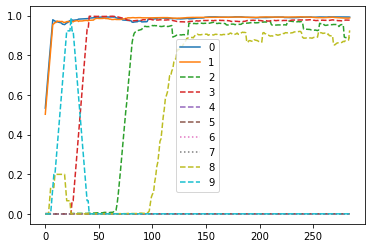

In [102]:
# DJGrad, p=0.5

with open(os.path.join(fp_local,'djgrad_05.pickle'), 'rb') as handle:
    history = pickle.load(handle)

line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
    tmp = smooth(history[k],15)[:-15]
    plt.plot(tmp,label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [65]:
tf.random.set_seed(0)

m = DistMLP('djgrad',0.25)
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'djgrad_025.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
115/115 [==============================] - 21s 179ms/step - loss: 3.8730 - ca1-cl0: 0.9422 - ca1-cl1: 0.6166 - ca1-cl2: 0.0021 - ca1-cl3: 0.0286 - ca1-cl4: 0.0099 - ca1-cl5: 0.0197 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0084 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.5444 - ca2-cl3: 0.4174 - ca2-cl4: 0.0374 - ca2-cl5: 0.2998 - ca2-cl6: 0.0232 - ca2-cl7: 0.4139 - ca2-cl8: 0.3083 - ca2-cl9: 0.4179 - ca3-cl0: 0.1789 - ca3-cl1: 0.0042 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9401 - ca3-cl5: 0.0882 - ca3-cl6: 0.0258 - ca3-cl7: 0.0109 - ca3-cl8: 0.0069 - ca3-cl9: 0.0041 - ca4-cl0: 0.8004 - ca4-cl1: 0.2674 - ca4-cl2: 0.4017 - ca4-cl3: 0.0292 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.4601 - ca4-cl7: 0.5563 - ca4-cl8: 0.0178 - ca4-cl9: 0.0132 - val_loss: 1.9935 - val_ca1-cl0: 1.0000 - val_ca1-cl1: 0.9251 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.0

115/115 [==============================] - 20s 178ms/step - loss: 1.3772 - ca1-cl0: 0.6193 - ca1-cl1: 0.6804 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9979 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.6486 - ca2-cl3: 0.7420 - ca2-cl4: 0.5278 - ca2-cl5: 0.6161 - ca2-cl6: 0.5565 - ca2-cl7: 0.5950 - ca2-cl8: 0.6860 - ca2-cl9: 0.1748 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.6589 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 3.7120e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9916 - ca4-cl1: 0.8440 - ca4-cl2: 0.5575 - ca4-cl3: 0.5817 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8129 - ca4-cl7: 0.7947 - ca4-cl8: 0.0028 - ca4-cl9: 0.2710 - val_loss: 1.8895 - val_ca1-cl0: 0.9643 - val_ca1-cl1: 0.9664 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0

115/115 [==============================] - 20s 178ms/step - loss: 1.2340 - ca1-cl0: 0.7915 - ca1-cl1: 0.6625 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0066 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9979 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.7245 - ca2-cl3: 0.8205 - ca2-cl4: 0.6044 - ca2-cl5: 0.6217 - ca2-cl6: 0.8238 - ca2-cl7: 0.6591 - ca2-cl8: 0.9208 - ca2-cl9: 0.3857 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.7749 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0014 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9937 - ca4-cl1: 0.8705 - ca4-cl2: 0.6201 - ca4-cl3: 0.6023 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8415 - ca4-cl7: 0.8402 - ca4-cl8: 0.0521 - ca4-cl9: 0.4705 - val_loss: 2.2071 - val_ca1-cl0: 0.9755 - val_ca1-cl1: 0.9471 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 9.9108e-04 - val_ca1-cl4: 0.0000e+0

115/115 [==============================] - 21s 179ms/step - loss: 1.1023 - ca1-cl0: 0.8569 - ca1-cl1: 0.6963 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0013 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0015 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8587 - ca2-cl3: 0.8852 - ca2-cl4: 0.6630 - ca2-cl5: 0.6520 - ca2-cl6: 0.9285 - ca2-cl7: 0.7044 - ca2-cl8: 0.9663 - ca2-cl9: 0.6273 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.8803 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0032 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9930 - ca4-cl1: 0.8508 - ca4-cl2: 0.8207 - ca4-cl3: 0.6477 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8835 - ca4-cl7: 0.8698 - ca4-cl8: 0.3638 - ca4-cl9: 0.5907 - val_loss: 2.3030 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9682 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - 

115/115 [==============================] - 21s 179ms/step - loss: 1.0343 - ca1-cl0: 0.8787 - ca1-cl1: 0.6741 - ca1-cl2: 0.0014 - ca1-cl3: 0.0595 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9425 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8976 - ca2-cl3: 0.9128 - ca2-cl4: 0.8779 - ca2-cl5: 0.8497 - ca2-cl6: 0.9488 - ca2-cl7: 0.6871 - ca2-cl8: 0.6924 - ca2-cl9: 0.9471 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9464 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0014 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9895 - ca4-cl1: 0.8620 - ca4-cl2: 0.8676 - ca4-cl3: 0.6545 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8783 - ca4-cl7: 0.8730 - ca4-cl8: 0.6103 - ca4-cl9: 0.6443 - val_loss: 2.4700 - val_ca1-cl0: 0.9837 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.0029 - val_ca1-cl3: 0.9960 - val_ca1-cl4: 0.0000e+00 - val_ca1-

115/115 [==============================] - 21s 179ms/step - loss: 0.9662 - ca1-cl0: 0.8948 - ca1-cl1: 0.6537 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.9987 - ca1-cl4: 0.0000e+00 - ca1-cl5: 7.5873e-04 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9080 - ca2-cl3: 0.9316 - ca2-cl4: 0.8967 - ca2-cl5: 0.9143 - ca2-cl6: 0.9619 - ca2-cl7: 0.6750 - ca2-cl8: 0.8535 - ca2-cl9: 0.9525 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9369 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0013 - ca3-cl8: 0.0048 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9958 - ca4-cl1: 0.8772 - ca4-cl2: 0.8735 - ca4-cl3: 0.8531 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8976 - ca4-cl7: 0.8755 - ca4-cl8: 0.7744 - ca4-cl9: 0.8233 - val_loss: 2.5335 - val_ca1-cl0: 0.9888 - val_ca1-cl1: 0.9814 - val_ca1-cl2: 9.6993e-04 - val_ca1-cl3: 0.9990 - val_ca1-cl4: 0.0000e+00 - 

Epoch 50/300
115/115 [==============================] - 20s 178ms/step - loss: 0.9365 - ca1-cl0: 0.8835 - ca1-cl1: 0.6847 - ca1-cl2: 0.2008 - ca1-cl3: 0.7653 - ca1-cl4: 7.0522e-04 - ca1-cl5: 0.3923 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 7.0373e-04 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8892 - ca2-cl3: 0.9197 - ca2-cl4: 0.9100 - ca2-cl5: 0.9278 - ca2-cl6: 0.9489 - ca2-cl7: 0.6943 - ca2-cl8: 0.8868 - ca2-cl9: 0.9687 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9113 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 6.8871e-04 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9937 - ca4-cl1: 0.9552 - ca4-cl2: 0.8666 - ca4-cl3: 0.8731 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8988 - ca4-cl7: 0.8734 - ca4-cl8: 0.8352 - ca4-cl9: 0.9020 - val_loss: 2.6256 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9559 - val_ca1-cl2: 0.0107 - val_ca1-cl3: 0.9742 - val_ca1-cl4: 0.00

Epoch 55/300
115/115 [==============================] - 20s 178ms/step - loss: 0.9029 - ca1-cl0: 0.8945 - ca1-cl1: 0.6879 - ca1-cl2: 0.8842 - ca1-cl3: 0.0838 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.4342 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0021 - ca1-cl9: 6.9444e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9056 - ca2-cl3: 0.9425 - ca2-cl4: 0.9263 - ca2-cl5: 0.9479 - ca2-cl6: 0.9626 - ca2-cl7: 0.6766 - ca2-cl8: 0.9037 - ca2-cl9: 0.9797 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9499 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 6.4144e-04 - ca3-cl8: 0.0034 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.9754 - ca4-cl2: 0.8658 - ca4-cl3: 0.8708 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8977 - ca4-cl7: 0.8798 - ca4-cl8: 0.8807 - ca4-cl9: 0.8888 - val_loss: 2.6815 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9893 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+

Epoch 60/300
115/115 [==============================] - 21s 181ms/step - loss: 0.8863 - ca1-cl0: 0.9008 - ca1-cl1: 0.6841 - ca1-cl2: 0.9938 - ca1-cl3: 0.0479 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.5502 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9017 - ca2-cl3: 0.9387 - ca2-cl4: 0.9148 - ca2-cl5: 0.9607 - ca2-cl6: 0.9633 - ca2-cl7: 0.9936 - ca2-cl8: 0.8925 - ca2-cl9: 0.6569 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9244 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 6.4144e-04 - ca3-cl8: 0.0034 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9937 - ca4-cl1: 0.9693 - ca4-cl2: 0.8982 - ca4-cl3: 0.8790 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9048 - ca4-cl7: 0.8991 - ca4-cl8: 0.9209 - ca4-cl9: 0.8827 - val_loss: 2.6973 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.9816 - val_ca1-cl3: 0.0763 - val_ca1-cl4: 0.0000e+00 -

Epoch 65/300
115/115 [==============================] - 20s 177ms/step - loss: 0.8550 - ca1-cl0: 0.9051 - ca1-cl1: 0.6824 - ca1-cl2: 0.9959 - ca1-cl3: 0.2224 - ca1-cl4: 0.0014 - ca1-cl5: 0.5553 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0084 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8945 - ca2-cl3: 0.9507 - ca2-cl4: 0.9149 - ca2-cl5: 0.9522 - ca2-cl6: 0.9666 - ca2-cl7: 0.9968 - ca2-cl8: 0.9559 - ca2-cl9: 0.6827 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9452 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 6.4309e-04 - ca3-cl8: 6.8540e-04 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.9761 - ca4-cl2: 0.9107 - ca4-cl3: 0.8908 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9059 - ca4-cl7: 0.9058 - ca4-cl8: 0.9493 - ca4-cl9: 0.9251 - val_loss: 2.7748 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9787 - val_ca1-cl3: 0.7423 - val_ca1-cl4: 0.0020 - val

Epoch 70/300
115/115 [==============================] - 20s 178ms/step - loss: 0.8792 - ca1-cl0: 0.8759 - ca1-cl1: 0.6783 - ca1-cl2: 0.9952 - ca1-cl3: 0.0959 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6220 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0112 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8995 - ca2-cl3: 0.9408 - ca2-cl4: 0.9230 - ca2-cl5: 0.9703 - ca2-cl6: 0.9700 - ca2-cl7: 0.9961 - ca2-cl8: 0.9622 - ca2-cl9: 0.6990 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9295 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0022 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0735 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9937 - ca4-cl1: 0.9462 - ca4-cl2: 0.8934 - ca4-cl3: 0.8816 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8929 - ca4-cl7: 0.8928 - ca4-cl8: 0.9101 - ca4-cl9: 0.9049 - val_loss: 2.7647 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9884 - val_ca1-cl3: 0.5653 - val_ca1-cl4: 0.0000e+00 - val

Epoch 75/300
115/115 [==============================] - 20s 177ms/step - loss: 0.8398 - ca1-cl0: 0.8916 - ca1-cl1: 0.6991 - ca1-cl2: 0.9925 - ca1-cl3: 0.4731 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6417 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0246 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9045 - ca2-cl3: 0.9513 - ca2-cl4: 0.9175 - ca2-cl5: 0.9687 - ca2-cl6: 0.9660 - ca2-cl7: 0.9981 - ca2-cl8: 0.9586 - ca2-cl9: 0.6757 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9440 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0172 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9779 - ca4-cl2: 0.8962 - ca4-cl3: 0.8783 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8979 - ca4-cl7: 0.9037 - ca4-cl8: 0.9357 - ca4-cl9: 0.9237 - val_loss: 2.9228 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.9913 - val_ca1-cl3: 0.8464 - val_ca1-cl4: 0.0000e+00 -

Epoch 80/300
115/115 [==============================] - 21s 179ms/step - loss: 0.8226 - ca1-cl0: 0.9058 - ca1-cl1: 0.7004 - ca1-cl2: 0.9979 - ca1-cl3: 0.5306 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6707 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.1271 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9053 - ca2-cl3: 0.9489 - ca2-cl4: 0.9197 - ca2-cl5: 0.9703 - ca2-cl6: 0.9646 - ca2-cl7: 0.7042 - ca2-cl8: 0.9539 - ca2-cl9: 0.9871 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9363 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 6.8681e-04 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9761 - ca4-cl2: 0.9121 - ca4-cl3: 0.8925 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9136 - ca4-cl7: 0.9163 - ca4-cl8: 0.9408 - ca4-cl9: 0.9208 - val_loss: 2.7474 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9874 - val_ca1-cl3: 0.8442 - val_ca1-cl4: 0.0000e+00 -

Epoch 85/300
115/115 [==============================] - 21s 179ms/step - loss: 0.8072 - ca1-cl0: 0.9055 - ca1-cl1: 0.6902 - ca1-cl2: 0.9959 - ca1-cl3: 0.5539 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6844 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.2890 - ca1-cl9: 0.0021 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9091 - ca2-cl3: 0.9556 - ca2-cl4: 0.9255 - ca2-cl5: 0.9695 - ca2-cl6: 0.9741 - ca2-cl7: 0.9968 - ca2-cl8: 0.9511 - ca2-cl9: 0.6974 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9273 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0089 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9791 - ca4-cl2: 0.9118 - ca4-cl3: 0.8985 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9012 - ca4-cl7: 0.9201 - ca4-cl8: 0.9543 - ca4-cl9: 0.9342 - val_loss: 2.9008 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9825 - val_ca1-cl3: 0.7130 - val_ca1-cl4: 0.0000e+00 - val

Epoch 90/300
115/115 [==============================] - 20s 177ms/step - loss: 0.7962 - ca1-cl0: 0.9065 - ca1-cl1: 0.6955 - ca1-cl2: 0.9959 - ca1-cl3: 0.5913 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6540 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.3315 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9088 - ca2-cl3: 0.9664 - ca2-cl4: 0.9092 - ca2-cl5: 0.9814 - ca2-cl6: 0.9714 - ca2-cl7: 0.9961 - ca2-cl8: 0.9711 - ca2-cl9: 0.8592 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9612 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.9700 - ca4-cl2: 0.9015 - ca4-cl3: 0.9308 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8876 - ca4-cl7: 0.9245 - ca4-cl8: 0.9339 - ca4-cl9: 0.9107 - val_loss: 2.8496 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9806 - val_ca1-cl3: 0.8850 - val_ca1-cl4: 0.0000e+

Epoch 95/300
115/115 [==============================] - 20s 178ms/step - loss: 0.8138 - ca1-cl0: 0.8891 - ca1-cl1: 0.6905 - ca1-cl2: 0.9925 - ca1-cl3: 0.5997 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6722 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.3331 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9132 - ca2-cl3: 0.9569 - ca2-cl4: 0.9100 - ca2-cl5: 0.9814 - ca2-cl6: 0.9646 - ca2-cl7: 0.9974 - ca2-cl8: 0.9670 - ca2-cl9: 0.8770 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9012 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.2431 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.9797 - ca4-cl2: 0.8791 - ca4-cl3: 0.9085 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8560 - ca4-cl7: 0.9232 - ca4-cl8: 0.9173 - ca4-cl9: 0.9145 - val_loss: 2.9437 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.9124 - val_ca1-cl4: 0.0010 - val_ca1

Epoch 100/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7570 - ca1-cl0: 0.9120 - ca1-cl1: 0.6987 - ca1-cl2: 0.9938 - ca1-cl3: 0.6312 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7066 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4000 - ca1-cl9: 6.9493e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9124 - ca2-cl3: 0.9625 - ca2-cl4: 0.9156 - ca2-cl5: 0.9888 - ca2-cl6: 0.9802 - ca2-cl7: 0.9948 - ca2-cl8: 0.9656 - ca2-cl9: 0.8820 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9142 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 7.4184e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.4451 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9822 - ca4-cl2: 0.9120 - ca4-cl3: 0.9580 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9118 - ca4-cl7: 0.9417 - ca4-cl8: 0.9487 - ca4-cl9: 0.9307 - val_loss: 2.9695 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9767 - val_ca1-cl3: 0.9435 - val_ca1-cl4: 0.0000e+00 

Epoch 105/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7797 - ca1-cl0: 0.9055 - ca1-cl1: 0.6795 - ca1-cl2: 0.9952 - ca1-cl3: 0.6489 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7479 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4340 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.8946 - ca2-cl3: 0.9556 - ca2-cl4: 0.8848 - ca2-cl5: 0.9725 - ca2-cl6: 0.9768 - ca2-cl7: 0.9903 - ca2-cl8: 0.9573 - ca2-cl9: 0.8562 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9470 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0535 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9853 - ca4-cl2: 0.9016 - ca4-cl3: 0.9520 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9077 - ca4-cl7: 0.9400 - ca4-cl8: 0.9492 - ca4-cl9: 0.9286 - val_loss: 2.9880 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9767 - val_ca1-cl3: 0.9365 - val_ca1-cl4: 0.0000e+00 

Epoch 110/300
115/115 [==============================] - 21s 180ms/step - loss: 0.7787 - ca1-cl0: 0.8852 - ca1-cl1: 0.6807 - ca1-cl2: 0.9938 - ca1-cl3: 0.6325 - ca1-cl4: 7.0572e-04 - ca1-cl5: 0.7080 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4098 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9150 - ca2-cl3: 0.9612 - ca2-cl4: 0.9098 - ca2-cl5: 0.9821 - ca2-cl6: 0.9775 - ca2-cl7: 0.9974 - ca2-cl8: 0.9683 - ca2-cl9: 0.8918 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9528 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0398 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9979 - ca4-cl1: 0.9810 - ca4-cl2: 0.8942 - ca4-cl3: 0.9492 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9115 - ca4-cl7: 0.9486 - ca4-cl8: 0.9436 - ca4-cl9: 0.9298 - val_loss: 3.0262 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9757 - val_ca1-cl3: 0.9444 - val_ca1-cl4: 0.0000e+00 - va

Epoch 115/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7300 - ca1-cl0: 0.9089 - ca1-cl1: 0.6938 - ca1-cl2: 0.9973 - ca1-cl3: 0.6625 - ca1-cl4: 0.0014 - ca1-cl5: 0.7970 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5215 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9986 - ca2-cl3: 0.9638 - ca2-cl4: 0.9320 - ca2-cl5: 0.9881 - ca2-cl6: 0.9740 - ca2-cl7: 0.8995 - ca2-cl8: 0.9518 - ca2-cl9: 0.8938 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9190 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9976 - ca3-cl5: 0.0011 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.5571 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9951 - ca4-cl1: 0.9835 - ca4-cl2: 0.8872 - ca4-cl3: 0.9513 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9085 - ca4-cl7: 0.9575 - ca4-cl8: 0.9536 - ca4-cl9: 0.9285 - val_loss: 3.0527 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9680 - val_ca1-cl3: 0.8373 - val_ca1-cl4: 0.0051 - val_ca1-cl

Epoch 120/300
115/115 [==============================] - 20s 177ms/step - loss: 0.7776 - ca1-cl0: 0.9066 - ca1-cl1: 0.6923 - ca1-cl2: 0.9918 - ca1-cl3: 0.6199 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7142 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5344 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9513 - ca2-cl4: 0.9238 - ca2-cl5: 0.9858 - ca2-cl6: 0.9748 - ca2-cl7: 0.9016 - ca2-cl8: 0.9579 - ca2-cl9: 0.8952 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9535 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 6.4103e-04 - ca3-cl8: 0.0021 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.9828 - ca4-cl2: 0.9072 - ca4-cl3: 0.9634 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9129 - ca4-cl7: 0.9447 - ca4-cl8: 0.9507 - ca4-cl9: 0.9368 - val_loss: 3.0538 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9826 - val_ca1-cl3: 0.9394 - val_ca1-cl4: 0.0010 - va

Epoch 125/300
115/115 [==============================] - 21s 180ms/step - loss: 0.7414 - ca1-cl0: 0.8915 - ca1-cl1: 0.6796 - ca1-cl2: 0.9966 - ca1-cl3: 0.6472 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7561 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5913 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9983 - ca2-cl3: 0.9628 - ca2-cl4: 0.9307 - ca2-cl5: 0.9844 - ca2-cl6: 0.9877 - ca2-cl7: 0.9052 - ca2-cl8: 0.9663 - ca2-cl9: 0.8912 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9190 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 7.4239e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.4828 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9756 - ca4-cl2: 0.9077 - ca4-cl3: 0.9709 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8971 - ca4-cl7: 0.9548 - ca4-cl8: 0.9529 - ca4-cl9: 0.9355 - val_loss: 3.1304 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.9208 - val_ca1-cl4: 0.0000e+00 

Epoch 130/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7621 - ca1-cl0: 0.9164 - ca1-cl1: 0.7070 - ca1-cl2: 0.9979 - ca1-cl3: 0.6838 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7864 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5961 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9986 - ca2-cl3: 0.9582 - ca2-cl4: 0.9079 - ca2-cl5: 0.9814 - ca2-cl6: 0.9680 - ca2-cl7: 0.8976 - ca2-cl8: 0.9566 - ca2-cl9: 0.8792 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9673 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0689 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.9743 - ca4-cl2: 0.8962 - ca4-cl3: 0.9397 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9030 - ca4-cl7: 0.9473 - ca4-cl8: 0.9352 - ca4-cl9: 0.9263 - val_loss: 3.0754 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9728 - val_ca1-cl3: 0.9465 - val_ca1-cl4: 0.0010 - va

Epoch 135/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7189 - ca1-cl0: 0.9048 - ca1-cl1: 0.6857 - ca1-cl2: 0.9973 - ca1-cl3: 0.6769 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8423 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6399 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9671 - ca2-cl4: 0.9204 - ca2-cl5: 0.9926 - ca2-cl6: 0.9748 - ca2-cl7: 0.9080 - ca2-cl8: 0.9621 - ca2-cl9: 0.8940 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9415 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 3.7092e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6105 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.9871 - ca4-cl2: 0.8749 - ca4-cl3: 0.9451 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9033 - ca4-cl7: 0.9496 - ca4-cl8: 0.9337 - ca4-cl9: 0.9390 - val_loss: 3.2006 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9728 - val_ca1-cl3: 0.9296 - val_ca1-cl4: 0.0010 - va

Epoch 140/300
115/115 [==============================] - 21s 179ms/step - loss: 0.7380 - ca1-cl0: 0.8988 - ca1-cl1: 0.6782 - ca1-cl2: 0.9979 - ca1-cl3: 0.6778 - ca1-cl4: 7.0572e-04 - ca1-cl5: 0.8279 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6371 - ca1-cl9: 6.9348e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9688 - ca2-cl4: 0.9245 - ca2-cl5: 0.9851 - ca2-cl6: 0.9761 - ca2-cl7: 0.8995 - ca2-cl8: 0.9642 - ca2-cl9: 0.9146 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9362 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.2977 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9979 - ca4-cl1: 0.9816 - ca4-cl2: 0.8851 - ca4-cl3: 0.9573 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9004 - ca4-cl7: 0.9568 - ca4-cl8: 0.9365 - ca4-cl9: 0.9356 - val_loss: 3.1152 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9718 - val_ca1-cl3: 0.9523 - val_ca1-cl4: 0.0000e+00 

Epoch 145/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7159 - ca1-cl0: 0.9121 - ca1-cl1: 0.6953 - ca1-cl2: 0.7837 - ca1-cl3: 0.6529 - ca1-cl4: 7.0671e-04 - ca1-cl5: 0.7942 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6275 - ca1-cl9: 0.2069 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9542 - ca2-cl4: 0.9224 - ca2-cl5: 0.9844 - ca2-cl6: 0.9823 - ca2-cl7: 0.8982 - ca2-cl8: 0.9655 - ca2-cl9: 0.8908 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9382 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6216 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9902 - ca4-cl2: 0.8963 - ca4-cl3: 0.9682 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8981 - ca4-cl7: 0.9509 - ca4-cl8: 0.9480 - ca4-cl9: 0.9362 - val_loss: 3.1940 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9777 - val_ca1-cl3: 0.9584 - val_ca1-cl4: 0.0000e+00 - va

Epoch 150/300
115/115 [==============================] - 21s 179ms/step - loss: 0.7059 - ca1-cl0: 0.9148 - ca1-cl1: 0.7034 - ca1-cl2: 0.9918 - ca1-cl3: 0.6975 - ca1-cl4: 7.0472e-04 - ca1-cl5: 0.8405 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6117 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9973 - ca2-cl3: 0.9566 - ca2-cl4: 0.9154 - ca2-cl5: 0.9762 - ca2-cl6: 0.9741 - ca2-cl7: 0.8814 - ca2-cl8: 0.9545 - ca2-cl9: 0.8995 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9393 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6772 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9890 - ca4-cl2: 0.9052 - ca4-cl3: 0.9587 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9011 - ca4-cl7: 0.9835 - ca4-cl8: 0.9485 - ca4-cl9: 0.9335 - val_loss: 3.1643 - val_ca1-cl0: 0.9877 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9855 - val_ca1-cl3: 0.5867 - val_ca1-cl4: 0.0000e+00 

Epoch 155/300
115/115 [==============================] - 20s 177ms/step - loss: 0.6968 - ca1-cl0: 0.8992 - ca1-cl1: 0.6880 - ca1-cl2: 0.9959 - ca1-cl3: 0.6787 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8620 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6105 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9635 - ca2-cl4: 0.9321 - ca2-cl5: 0.9836 - ca2-cl6: 0.9850 - ca2-cl7: 0.9078 - ca2-cl8: 0.9704 - ca2-cl9: 0.8988 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9464 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 7.4184e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6539 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9890 - ca4-cl2: 0.9043 - ca4-cl3: 0.9628 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9153 - ca4-cl7: 0.9734 - ca4-cl8: 0.9548 - ca4-cl9: 0.9292 - val_loss: 3.2296 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9680 - val_ca1-cl3: 0.9415 - val_ca1-cl4: 0.0000e+00 

Epoch 160/300
115/115 [==============================] - 20s 177ms/step - loss: 0.6836 - ca1-cl0: 0.9068 - ca1-cl1: 0.6962 - ca1-cl2: 0.9973 - ca1-cl3: 0.6813 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8492 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6535 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 1.0000 - ca2-cl3: 0.9701 - ca2-cl4: 0.9459 - ca2-cl5: 0.9859 - ca2-cl6: 0.9809 - ca2-cl7: 0.8945 - ca2-cl8: 0.9773 - ca2-cl9: 0.9041 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9595 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6920 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9902 - ca4-cl2: 0.9250 - ca4-cl3: 0.9695 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9057 - ca4-cl7: 0.9693 - ca4-cl8: 0.9492 - ca4-cl9: 0.9528 - val_loss: 3.2329 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9670 - val_ca1-cl3: 0.9325 - val_ca1-cl4: 0.0000e+00 

Epoch 165/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7024 - ca1-cl0: 0.8992 - ca1-cl1: 0.6934 - ca1-cl2: 0.9966 - ca1-cl3: 0.6871 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8179 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5781 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9688 - ca2-cl4: 0.9078 - ca2-cl5: 0.9911 - ca2-cl6: 0.9870 - ca2-cl7: 0.9046 - ca2-cl8: 0.9711 - ca2-cl9: 0.8906 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9606 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6875 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9767 - ca4-cl2: 0.9078 - ca4-cl3: 0.9613 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8924 - ca4-cl7: 0.9539 - ca4-cl8: 0.9352 - ca4-cl9: 0.8890 - val_loss: 3.1907 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9929 - val_ca1-cl2: 0.9786 - val_ca1-cl3: 0.9523 - val_ca1-cl4: 0.0000e+00 

Epoch 170/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6979 - ca1-cl0: 0.8825 - ca1-cl1: 0.6975 - ca1-cl2: 0.9979 - ca1-cl3: 0.6938 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8584 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6182 - ca1-cl9: 6.9348e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9655 - ca2-cl4: 0.9294 - ca2-cl5: 0.9799 - ca2-cl6: 0.9803 - ca2-cl7: 0.9180 - ca2-cl8: 0.9662 - ca2-cl9: 0.8886 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9440 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6893 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9890 - ca4-cl2: 0.8997 - ca4-cl3: 0.9838 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9182 - ca4-cl7: 0.9585 - ca4-cl8: 0.9599 - ca4-cl9: 0.9354 - val_loss: 3.2275 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9602 - val_ca1-cl3: 0.9188 - val_ca1-cl4: 0.0000e+00 

Epoch 175/300
115/115 [==============================] - 20s 178ms/step - loss: 0.7035 - ca1-cl0: 0.9052 - ca1-cl1: 0.6946 - ca1-cl2: 0.9993 - ca1-cl3: 0.6822 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8502 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6377 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9983 - ca2-cl3: 0.9672 - ca2-cl4: 0.9101 - ca2-cl5: 0.9873 - ca2-cl6: 0.9830 - ca2-cl7: 0.8923 - ca2-cl8: 0.9641 - ca2-cl9: 0.8924 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9553 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6653 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9979 - ca4-cl1: 0.9871 - ca4-cl2: 0.9016 - ca4-cl3: 0.9797 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9032 - ca4-cl7: 0.9694 - ca4-cl8: 0.9441 - ca4-cl9: 0.9389 - val_loss: 3.2670 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9641 - val_ca1-cl3: 0.9464 - val_ca1-cl4: 0.0000e+00 

Epoch 180/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6856 - ca1-cl0: 0.9041 - ca1-cl1: 0.7050 - ca1-cl2: 0.9979 - ca1-cl3: 0.6565 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8573 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6390 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 1.0000 - ca2-cl3: 0.9625 - ca2-cl4: 0.9225 - ca2-cl5: 0.9933 - ca2-cl6: 0.9782 - ca2-cl7: 0.9691 - ca2-cl8: 0.9793 - ca2-cl9: 0.9021 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9571 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6756 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9979 - ca4-cl1: 0.9871 - ca4-cl2: 0.9087 - ca4-cl3: 0.9804 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9056 - ca4-cl7: 0.9690 - ca4-cl8: 0.9593 - ca4-cl9: 0.9576 - val_loss: 3.2406 - val_ca1-cl0: 0.9897 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9787 - val_ca1-cl3: 0.9305 - val_ca1-cl4: 0.0000e+00 

Epoch 185/300
115/115 [==============================] - 20s 177ms/step - loss: 0.6832 - ca1-cl0: 0.9068 - ca1-cl1: 0.7008 - ca1-cl2: 0.9959 - ca1-cl3: 0.6662 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8770 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6424 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9648 - ca2-cl4: 0.9300 - ca2-cl5: 0.9948 - ca2-cl6: 0.9789 - ca2-cl7: 0.9608 - ca2-cl8: 0.9711 - ca2-cl9: 0.8995 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9571 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6893 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9890 - ca4-cl2: 0.9107 - ca4-cl3: 0.9871 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8974 - ca4-cl7: 0.9664 - ca4-cl8: 0.9672 - ca4-cl9: 0.9771 - val_loss: 3.3188 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9867 - val_ca1-cl2: 0.9718 - val_ca1-cl3: 0.9238 - val_ca1-cl4: 0.0000e+00 

Epoch 190/300
115/115 [==============================] - 20s 177ms/step - loss: 0.7043 - ca1-cl0: 0.9062 - ca1-cl1: 0.6906 - ca1-cl2: 0.9986 - ca1-cl3: 0.6902 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8452 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6458 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9593 - ca2-cl4: 0.9216 - ca2-cl5: 0.9888 - ca2-cl6: 0.9775 - ca2-cl7: 0.9536 - ca2-cl8: 0.9587 - ca2-cl9: 0.8835 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9583 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.0015 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6632 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9823 - ca4-cl2: 0.8976 - ca4-cl3: 0.9715 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8917 - ca4-cl7: 0.9710 - ca4-cl8: 0.9347 - ca4-cl9: 0.9729 - val_loss: 3.3179 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9748 - val_ca1-cl3: 0.9554 - val_ca1-cl4: 0.0000e+00 - va

Epoch 195/300
115/115 [==============================] - 21s 179ms/step - loss: 0.6885 - ca1-cl0: 0.8959 - ca1-cl1: 0.6977 - ca1-cl2: 0.9979 - ca1-cl3: 0.6911 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8672 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6331 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9980 - ca2-cl3: 0.9651 - ca2-cl4: 0.9294 - ca2-cl5: 0.9903 - ca2-cl6: 0.9680 - ca2-cl7: 0.9717 - ca2-cl8: 0.9717 - ca2-cl9: 0.8899 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9619 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 7.4267e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6891 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9853 - ca4-cl2: 0.8961 - ca4-cl3: 0.9783 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9069 - ca4-cl7: 0.9644 - ca4-cl8: 0.9544 - ca4-cl9: 0.9847 - val_loss: 3.2704 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9796 - val_ca1-cl3: 0.9425 - val_ca1-cl4: 0.0000e+00 

Epoch 200/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6731 - ca1-cl0: 0.9128 - ca1-cl1: 0.7092 - ca1-cl2: 0.8916 - ca1-cl3: 0.6587 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8442 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5815 - ca1-cl9: 0.0932 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 1.0000 - ca2-cl3: 0.9684 - ca2-cl4: 0.9152 - ca2-cl5: 0.9963 - ca2-cl6: 0.9714 - ca2-cl7: 0.9588 - ca2-cl8: 0.9711 - ca2-cl9: 0.9058 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9606 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6759 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9908 - ca4-cl2: 0.9112 - ca4-cl3: 0.9777 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9050 - ca4-cl7: 0.9680 - ca4-cl8: 0.9506 - ca4-cl9: 0.9757 - val_loss: 3.2764 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9947 - val_ca1-cl2: 0.9719 - val_ca1-cl3: 0.9584 - val_ca1-cl4: 0.0000e+00 - va

Epoch 205/300
115/115 [==============================] - 21s 179ms/step - loss: 0.6680 - ca1-cl0: 0.8924 - ca1-cl1: 0.6861 - ca1-cl2: 0.9979 - ca1-cl3: 0.7074 - ca1-cl4: 0.0014 - ca1-cl5: 0.8657 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5067 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9678 - ca2-cl4: 0.9356 - ca2-cl5: 0.9933 - ca2-cl6: 0.9769 - ca2-cl7: 0.9581 - ca2-cl8: 0.9752 - ca2-cl9: 0.9123 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9565 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 7.4156e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6933 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9859 - ca4-cl2: 0.9067 - ca4-cl3: 0.9878 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9066 - ca4-cl7: 0.9605 - ca4-cl8: 0.9594 - ca4-cl9: 0.9743 - val_loss: 3.2763 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9929 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.9524 - val_ca1-cl4: 0.0000e+00 - va

Epoch 210/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6611 - ca1-cl0: 0.9068 - ca1-cl1: 0.7030 - ca1-cl2: 0.9986 - ca1-cl3: 0.7112 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8582 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5236 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 1.0000 - ca2-cl3: 0.9727 - ca2-cl4: 0.9343 - ca2-cl5: 0.9888 - ca2-cl6: 0.9769 - ca2-cl7: 0.9748 - ca2-cl8: 0.9578 - ca2-cl9: 0.9116 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9577 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 3.7064e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6975 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9883 - ca4-cl2: 0.9224 - ca4-cl3: 0.9851 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9179 - ca4-cl7: 0.9700 - ca4-cl8: 0.9644 - ca4-cl9: 0.9854 - val_loss: 3.3231 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9947 - val_ca1-cl2: 0.9805 - val_ca1-cl3: 0.9593 - val_ca1-cl4: 0.0000e+00 

Epoch 215/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6556 - ca1-cl0: 0.9037 - ca1-cl1: 0.6954 - ca1-cl2: 1.0000 - ca1-cl3: 0.6949 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8939 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4887 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9986 - ca2-cl3: 0.9644 - ca2-cl4: 0.9330 - ca2-cl5: 0.9851 - ca2-cl6: 0.9673 - ca2-cl7: 0.9742 - ca2-cl8: 0.9504 - ca2-cl9: 0.9205 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9732 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6843 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9908 - ca4-cl2: 0.9093 - ca4-cl3: 0.9932 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9048 - ca4-cl7: 0.9736 - ca4-cl8: 0.9851 - ca4-cl9: 0.9688 - val_loss: 3.2914 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9806 - val_ca1-cl3: 0.9652 - val_ca1-cl4: 0.0000e+00 

Epoch 220/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6676 - ca1-cl0: 0.9075 - ca1-cl1: 0.6876 - ca1-cl2: 0.9986 - ca1-cl3: 0.6796 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8515 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4891 - ca1-cl9: 6.9348e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9691 - ca2-cl4: 0.9217 - ca2-cl5: 0.9881 - ca2-cl6: 0.9775 - ca2-cl7: 0.9697 - ca2-cl8: 0.9684 - ca2-cl9: 0.9024 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9636 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6892 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9926 - ca4-cl2: 0.9008 - ca4-cl3: 0.9919 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9083 - ca4-cl7: 0.9648 - ca4-cl8: 0.9836 - ca4-cl9: 0.9667 - val_loss: 3.2810 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9893 - val_ca1-cl3: 0.9722 - val_ca1-cl4: 0.0000e+00 

Epoch 225/300
115/115 [==============================] - 21s 180ms/step - loss: 0.6707 - ca1-cl0: 0.9052 - ca1-cl1: 0.6969 - ca1-cl2: 0.9993 - ca1-cl3: 0.7062 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8644 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4526 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9986 - ca2-cl3: 0.9533 - ca2-cl4: 0.9189 - ca2-cl5: 0.9687 - ca2-cl6: 0.9768 - ca2-cl7: 0.9755 - ca2-cl8: 0.9559 - ca2-cl9: 0.8830 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9613 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6887 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9896 - ca4-cl2: 0.9105 - ca4-cl3: 0.9898 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9074 - ca4-cl7: 0.9723 - ca4-cl8: 0.9793 - ca4-cl9: 0.9792 - val_loss: 3.2584 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9787 - val_ca1-cl3: 0.9732 - val_ca1-cl4: 0.0000e+00 

Epoch 230/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6598 - ca1-cl0: 0.9058 - ca1-cl1: 0.6951 - ca1-cl2: 0.9979 - ca1-cl3: 0.6802 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8606 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4659 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9657 - ca2-cl4: 0.9349 - ca2-cl5: 0.9874 - ca2-cl6: 0.9809 - ca2-cl7: 0.9703 - ca2-cl8: 0.9731 - ca2-cl9: 0.8963 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9648 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6802 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9908 - ca4-cl2: 0.9081 - ca4-cl3: 0.9892 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9121 - ca4-cl7: 0.9707 - ca4-cl8: 0.9829 - ca4-cl9: 0.9715 - val_loss: 3.3596 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9947 - val_ca1-cl2: 0.9671 - val_ca1-cl3: 0.9673 - val_ca1-cl4: 0.0000e+00 

Epoch 235/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6690 - ca1-cl0: 0.9100 - ca1-cl1: 0.6888 - ca1-cl2: 0.9986 - ca1-cl3: 0.7216 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8516 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4930 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9959 - ca2-cl3: 0.9421 - ca2-cl4: 0.9257 - ca2-cl5: 0.9806 - ca2-cl6: 0.9816 - ca2-cl7: 0.9768 - ca2-cl8: 0.9408 - ca2-cl9: 0.8898 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9696 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6919 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9932 - ca4-cl2: 0.9155 - ca4-cl3: 0.9898 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9063 - ca4-cl7: 0.9779 - ca4-cl8: 0.9807 - ca4-cl9: 0.9633 - val_loss: 3.2915 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9947 - val_ca1-cl2: 0.9835 - val_ca1-cl3: 0.9643 - val_ca1-cl4: 0.0000e+00 

Epoch 240/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6674 - ca1-cl0: 0.9013 - ca1-cl1: 0.6899 - ca1-cl2: 0.8828 - ca1-cl3: 0.7024 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8636 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4783 - ca1-cl9: 0.1028 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9573 - ca2-cl4: 0.9280 - ca2-cl5: 0.9903 - ca2-cl6: 0.9728 - ca2-cl7: 0.9613 - ca2-cl8: 0.9643 - ca2-cl9: 0.8623 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9666 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6873 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9920 - ca4-cl2: 0.9030 - ca4-cl3: 0.9939 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9077 - ca4-cl7: 0.9700 - ca4-cl8: 0.9879 - ca4-cl9: 0.9757 - val_loss: 3.2670 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9930 - val_ca1-cl2: 0.9767 - val_ca1-cl3: 0.9613 - val_ca1-cl4: 0.0000e+00 - va

Epoch 245/300
115/115 [==============================] - 21s 179ms/step - loss: 0.6780 - ca1-cl0: 0.9128 - ca1-cl1: 0.6924 - ca1-cl2: 0.9986 - ca1-cl3: 0.6935 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8613 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4961 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9990 - ca2-cl3: 0.9589 - ca2-cl4: 0.9349 - ca2-cl5: 0.9851 - ca2-cl6: 0.9639 - ca2-cl7: 0.9703 - ca2-cl8: 0.9560 - ca2-cl9: 0.8808 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9732 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6864 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.9834 - ca4-cl2: 0.8798 - ca4-cl3: 0.9864 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8932 - ca4-cl7: 0.9660 - ca4-cl8: 0.9601 - ca4-cl9: 0.9575 - val_loss: 3.3226 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9883 - val_ca1-cl3: 0.9504 - val_ca1-cl4: 0.0000e+00 

Epoch 250/300
115/115 [==============================] - 20s 176ms/step - loss: 0.6559 - ca1-cl0: 0.9155 - ca1-cl1: 0.7028 - ca1-cl2: 0.9993 - ca1-cl3: 0.6939 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8379 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4529 - ca1-cl9: 6.9348e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9652 - ca2-cl4: 0.9341 - ca2-cl5: 0.9866 - ca2-cl6: 0.9694 - ca2-cl7: 0.9723 - ca2-cl8: 0.9711 - ca2-cl9: 0.8912 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9714 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6837 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9896 - ca4-cl2: 0.9107 - ca4-cl3: 0.9932 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9049 - ca4-cl7: 0.9733 - ca4-cl8: 0.9928 - ca4-cl9: 0.9652 - val_loss: 3.3651 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9921 - val_ca1-cl2: 0.9757 - val_ca1-cl3: 0.9772 - val_ca1-cl4: 0.0000e+00 

Epoch 255/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6541 - ca1-cl0: 0.9117 - ca1-cl1: 0.6918 - ca1-cl2: 1.0000 - ca1-cl3: 0.6933 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8728 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4768 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9717 - ca2-cl4: 0.9279 - ca2-cl5: 0.9926 - ca2-cl6: 0.9775 - ca2-cl7: 0.9717 - ca2-cl8: 0.9717 - ca2-cl9: 0.9100 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9613 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.7032 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9902 - ca4-cl2: 0.9024 - ca4-cl3: 0.9763 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9047 - ca4-cl7: 0.9763 - ca4-cl8: 0.9821 - ca4-cl9: 0.9632 - val_loss: 3.3695 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9747 - val_ca1-cl3: 0.9594 - val_ca1-cl4: 0.0000e+00 

Epoch 260/300
115/115 [==============================] - 20s 177ms/step - loss: 0.6694 - ca1-cl0: 0.9037 - ca1-cl1: 0.6987 - ca1-cl2: 0.9979 - ca1-cl3: 0.6846 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8740 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4120 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9665 - ca2-cl4: 0.9312 - ca2-cl5: 0.9911 - ca2-cl6: 0.9748 - ca2-cl7: 0.9671 - ca2-cl8: 0.9649 - ca2-cl9: 0.8949 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9619 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 7.4239e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6832 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9896 - ca4-cl2: 0.9148 - ca4-cl3: 0.9892 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9105 - ca4-cl7: 0.9717 - ca4-cl8: 0.9886 - ca4-cl9: 0.9688 - val_loss: 3.3536 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9806 - val_ca1-cl2: 0.9786 - val_ca1-cl3: 0.9762 - val_ca1-cl4: 0.0000e+00 

Epoch 265/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6657 - ca1-cl0: 0.9048 - ca1-cl1: 0.7018 - ca1-cl2: 0.9986 - ca1-cl3: 0.6660 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8718 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4972 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9622 - ca2-cl4: 0.9274 - ca2-cl5: 0.9925 - ca2-cl6: 0.9721 - ca2-cl7: 0.9781 - ca2-cl8: 0.9581 - ca2-cl9: 0.9144 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9690 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6772 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9908 - ca4-cl2: 0.8947 - ca4-cl3: 0.9926 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9083 - ca4-cl7: 0.9690 - ca4-cl8: 0.9872 - ca4-cl9: 0.9639 - val_loss: 3.3790 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9777 - val_ca1-cl3: 0.9722 - val_ca1-cl4: 0.0000e+00 

Epoch 270/300
115/115 [==============================] - 20s 179ms/step - loss: 0.6677 - ca1-cl0: 0.9062 - ca1-cl1: 0.6894 - ca1-cl2: 0.9993 - ca1-cl3: 0.6968 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8793 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4604 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 1.0000 - ca2-cl3: 0.9691 - ca2-cl4: 0.9286 - ca2-cl5: 0.9844 - ca2-cl6: 0.9728 - ca2-cl7: 0.9678 - ca2-cl8: 0.9697 - ca2-cl9: 0.9027 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9673 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 3.7120e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6875 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.9914 - ca4-cl2: 0.8976 - ca4-cl3: 0.9926 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9074 - ca4-cl7: 0.9667 - ca4-cl8: 0.9864 - ca4-cl9: 0.9576 - val_loss: 3.3922 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9929 - val_ca1-cl2: 0.9748 - val_ca1-cl3: 0.9603 - val_ca1-cl4: 0.0000e+00 

Epoch 275/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6619 - ca1-cl0: 0.9113 - ca1-cl1: 0.7062 - ca1-cl2: 0.9993 - ca1-cl3: 0.6640 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8726 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4789 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9645 - ca2-cl4: 0.9320 - ca2-cl5: 0.9710 - ca2-cl6: 0.9741 - ca2-cl7: 0.9749 - ca2-cl8: 0.9649 - ca2-cl9: 0.8900 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9666 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6774 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.9926 - ca4-cl2: 0.9038 - ca4-cl3: 0.9939 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9053 - ca4-cl7: 0.9661 - ca4-cl8: 0.9808 - ca4-cl9: 0.9715 - val_loss: 3.3538 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9920 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.9603 - val_ca1-cl4: 0.0000e+00 

Epoch 280/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6520 - ca1-cl0: 0.9068 - ca1-cl1: 0.7012 - ca1-cl2: 0.9458 - ca1-cl3: 0.6833 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8864 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4891 - ca1-cl9: 0.0437 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9997 - ca2-cl3: 0.9697 - ca2-cl4: 0.9377 - ca2-cl5: 0.9777 - ca2-cl6: 0.9755 - ca2-cl7: 0.9749 - ca2-cl8: 0.9627 - ca2-cl9: 0.9043 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9696 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6692 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9993 - ca4-cl1: 0.9963 - ca4-cl2: 0.9153 - ca4-cl3: 0.9939 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9053 - ca4-cl7: 0.9710 - ca4-cl8: 0.9886 - ca4-cl9: 0.9722 - val_loss: 3.4353 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9699 - val_ca1-cl3: 0.9732 - val_ca1-cl4: 0.0000e+00 - va

Epoch 285/300
115/115 [==============================] - 21s 180ms/step - loss: 0.6633 - ca1-cl0: 0.8985 - ca1-cl1: 0.6965 - ca1-cl2: 1.0000 - ca1-cl3: 0.6940 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8917 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4968 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9691 - ca2-cl4: 0.8470 - ca2-cl5: 0.9799 - ca2-cl6: 0.9830 - ca2-cl7: 0.9665 - ca2-cl8: 0.9614 - ca2-cl9: 0.8933 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9642 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.6761 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9986 - ca4-cl1: 0.9877 - ca4-cl2: 0.8955 - ca4-cl3: 0.9932 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9055 - ca4-cl7: 0.9717 - ca4-cl8: 0.9857 - ca4-cl9: 0.9667 - val_loss: 3.4167 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9709 - val_ca1-cl3: 0.9752 - val_ca1-cl4: 0.0000e+00 

Epoch 290/300
115/115 [==============================] - 21s 179ms/step - loss: 0.6522 - ca1-cl0: 0.9109 - ca1-cl1: 0.6921 - ca1-cl2: 1.0000 - ca1-cl3: 0.7059 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8759 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4982 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9605 - ca2-cl4: 0.9411 - ca2-cl5: 0.9792 - ca2-cl6: 0.9775 - ca2-cl7: 0.9729 - ca2-cl8: 0.9608 - ca2-cl9: 0.8893 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9565 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 3.7120e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.7593 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9969 - ca4-cl2: 0.9025 - ca4-cl3: 0.9899 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9207 - ca4-cl7: 0.9690 - ca4-cl8: 0.9807 - ca4-cl9: 0.9659 - val_loss: 3.4111 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9650 - val_ca1-cl3: 0.9623 - val_ca1-cl4: 0.0000e+00 

Epoch 295/300
115/115 [==============================] - 20s 177ms/step - loss: 0.6322 - ca1-cl0: 0.9016 - ca1-cl1: 0.6976 - ca1-cl2: 1.0000 - ca1-cl3: 0.6501 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8881 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4958 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9635 - ca2-cl4: 0.9214 - ca2-cl5: 0.9784 - ca2-cl6: 0.9809 - ca2-cl7: 0.9762 - ca2-cl8: 0.9595 - ca2-cl9: 0.9056 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9642 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.0000e+00 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.9456 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9963 - ca4-cl2: 0.9196 - ca4-cl3: 0.9926 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9150 - ca4-cl7: 0.9865 - ca4-cl8: 0.9907 - ca4-cl9: 0.9695 - val_loss: 3.3891 - val_ca1-cl0: 0.9929 - val_ca1-cl1: 0.9921 - val_ca1-cl2: 0.9787 - val_ca1-cl3: 0.9285 - val_ca1-cl4: 0.0000e+00 

Epoch 300/300
115/115 [==============================] - 20s 178ms/step - loss: 0.6381 - ca1-cl0: 0.9106 - ca1-cl1: 0.7005 - ca1-cl2: 0.9993 - ca1-cl3: 0.7062 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8925 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4765 - ca1-cl9: 6.9444e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9993 - ca2-cl3: 0.9638 - ca2-cl4: 0.9293 - ca2-cl5: 0.9762 - ca2-cl6: 0.9809 - ca2-cl7: 0.9652 - ca2-cl8: 0.9385 - ca2-cl9: 0.8976 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.9589 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 7.4184e-04 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.8655 - ca3-cl9: 0.0000e+00 - ca4-cl0: 1.0000 - ca4-cl1: 0.9938 - ca4-cl2: 0.8971 - ca4-cl3: 0.9946 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9024 - ca4-cl7: 0.9878 - ca4-cl8: 0.9807 - ca4-cl9: 0.9695 - val_loss: 3.4377 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9929 - val_ca1-cl2: 0.9602 - val_ca1-cl3: 0.9742 - val_ca1-cl4: 0.0000e+00 

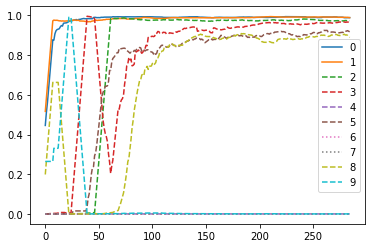

In [103]:
# DJGrad, p=0.25

with open(os.path.join(fp_local,'djgrad_025.pickle'), 'rb') as handle:
    history = pickle.load(handle)

line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
    tmp = smooth(history[k],15)[:-15]
    plt.plot(tmp,label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [67]:
tf.random.set_seed(0)

m = DistMLP('djgrad',0.1)
m.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CWAcc(ca,cl,name=f'ca{ca+1}-cl{cl}') for ca,cl in product(range(4),range(10))],
    run_eagerly=True
)

history = m.fit(
    train_dataset,
    epochs=300,
    validation_data=test_dataset
)

with open(os.path.join(fp_local,'djgrad_01.pickle'), 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/300
115/115 [==============================] - 22s 189ms/step - loss: 3.6927 - ca1-cl0: 0.7183 - ca1-cl1: 0.6097 - ca1-cl2: 6.8587e-04 - ca1-cl3: 0.0200 - ca1-cl4: 0.0176 - ca1-cl5: 0.0136 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0224 - ca1-cl9: 0.4702 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.5053 - ca2-cl3: 0.5667 - ca2-cl4: 0.0076 - ca2-cl5: 0.1593 - ca2-cl6: 0.1559 - ca2-cl7: 0.1703 - ca2-cl8: 0.0069 - ca2-cl9: 0.1886 - ca3-cl0: 0.0482 - ca3-cl1: 0.2713 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.3766 - ca3-cl5: 0.5471 - ca3-cl6: 0.0020 - ca3-cl7: 0.0160 - ca3-cl8: 0.0103 - ca3-cl9: 0.0372 - ca4-cl0: 0.8015 - ca4-cl1: 0.0423 - ca4-cl2: 0.3299 - ca4-cl3: 0.0129 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.5772 - ca4-cl7: 0.6330 - ca4-cl8: 0.0129 - ca4-cl9: 0.0083 - val_loss: 2.0112 - val_ca1-cl0: 0.7722 - val_ca1-cl1: 0.9708 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.0

115/115 [==============================] - 22s 188ms/step - loss: 1.3693 - ca1-cl0: 0.6430 - ca1-cl1: 0.6834 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0166 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0023 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9965 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.6601 - ca2-cl3: 0.6869 - ca2-cl4: 0.6078 - ca2-cl5: 0.6036 - ca2-cl6: 0.5119 - ca2-cl7: 0.5810 - ca2-cl8: 0.7223 - ca2-cl9: 0.1115 - ca3-cl0: 0.3682 - ca3-cl1: 0.8305 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9976 - ca3-cl5: 0.2430 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9951 - ca4-cl1: 0.6499 - ca4-cl2: 0.5817 - ca4-cl3: 0.0115 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8175 - ca4-cl7: 0.8026 - ca4-cl8: 0.0036 - ca4-cl9: 0.2835 - val_loss: 1.9706 - val_ca1-cl0: 0.9785 - val_ca1-cl1: 0.9478 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0218 - val_ca1-cl4: 0.0000e+00 - val_ca1-

115/115 [==============================] - 22s 188ms/step - loss: 1.2301 - ca1-cl0: 0.6580 - ca1-cl1: 0.6776 - ca1-cl2: 0.0000e+00 - ca1-cl3: 6.6667e-04 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0015 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9986 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.7604 - ca2-cl3: 0.7346 - ca2-cl4: 0.6489 - ca2-cl5: 0.6826 - ca2-cl6: 0.8080 - ca2-cl7: 0.6671 - ca2-cl8: 0.8287 - ca2-cl9: 0.4395 - ca3-cl0: 6.7751e-04 - ca3-cl1: 0.8816 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.3065 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0019 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9972 - ca4-cl1: 0.8261 - ca4-cl2: 0.6199 - ca4-cl3: 0.5742 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8532 - ca4-cl7: 0.8142 - ca4-cl8: 0.0064 - ca4-cl9: 0.4799 - val_loss: 2.2618 - val_ca1-cl0: 0.9683 - val_ca1-cl1: 0.9797 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_

Epoch 22/300
115/115 [==============================] - 21s 187ms/step - loss: 1.0996 - ca1-cl0: 0.8487 - ca1-cl1: 0.6731 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.2209 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0030 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9880 - ca1-cl9: 6.9444e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9056 - ca2-cl3: 0.7923 - ca2-cl4: 0.6641 - ca2-cl5: 0.6634 - ca2-cl6: 0.8725 - ca2-cl7: 0.6652 - ca2-cl8: 0.9098 - ca2-cl9: 0.5007 - ca3-cl0: 0.0000e+00 - ca3-cl1: 0.8537 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.7352 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0039 - ca3-cl8: 0.0000e+00 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9958 - ca4-cl1: 0.8705 - ca4-cl2: 0.6405 - ca4-cl3: 0.5862 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8839 - ca4-cl7: 0.8304 - ca4-cl8: 0.0128 - ca4-cl9: 0.5616 - val_loss: 2.3129 - val_ca1-cl0: 0.9888 - val_ca1-cl1: 0.9762 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 9.9305e-04 - val_ca1-cl4: 0.00

Epoch 27/300
115/115 [==============================] - 22s 189ms/step - loss: 1.0346 - ca1-cl0: 0.8704 - ca1-cl1: 0.6598 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0446 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0023 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9958 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9373 - ca2-cl3: 0.9001 - ca2-cl4: 0.6694 - ca2-cl5: 0.6488 - ca2-cl6: 0.8589 - ca2-cl7: 0.8178 - ca2-cl8: 0.9704 - ca2-cl9: 0.5901 - ca3-cl0: 0.0014 - ca3-cl1: 0.8696 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.8677 - ca3-cl6: 0.0000e+00 - ca3-cl7: 6.4103e-04 - ca3-cl8: 0.0110 - ca3-cl9: 6.7659e-04 - ca4-cl0: 0.9972 - ca4-cl1: 0.8389 - ca4-cl2: 0.6527 - ca4-cl3: 0.5896 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8638 - ca4-cl7: 0.8502 - ca4-cl8: 0.0436 - ca4-cl9: 0.6243 - val_loss: 2.5746 - val_ca1-cl0: 0.9888 - val_ca1-cl1: 0.9559 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+

Epoch 32/300
115/115 [==============================] - 22s 189ms/step - loss: 0.9638 - ca1-cl0: 0.8463 - ca1-cl1: 0.6877 - ca1-cl2: 6.8587e-04 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 7.5643e-04 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9972 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9461 - ca2-cl3: 0.9227 - ca2-cl4: 0.6836 - ca2-cl5: 0.6701 - ca2-cl6: 0.8909 - ca2-cl7: 0.8670 - ca2-cl8: 0.9752 - ca2-cl9: 0.6805 - ca3-cl0: 0.3931 - ca3-cl1: 0.8539 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9065 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0000e+00 - ca3-cl8: 0.0310 - ca3-cl9: 6.7385e-04 - ca4-cl0: 0.9944 - ca4-cl1: 0.8852 - ca4-cl2: 0.6825 - ca4-cl3: 0.6538 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8234 - ca4-cl7: 0.8588 - ca4-cl8: 0.4111 - ca4-cl9: 0.7745 - val_loss: 2.5183 - val_ca1-cl0: 0.9459 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 

Epoch 37/300
115/115 [==============================] - 22s 189ms/step - loss: 0.8786 - ca1-cl0: 0.8747 - ca1-cl1: 0.6892 - ca1-cl2: 0.0021 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9958 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9426 - ca2-cl3: 0.9348 - ca2-cl4: 0.7023 - ca2-cl5: 0.7722 - ca2-cl6: 0.9026 - ca2-cl7: 0.8842 - ca2-cl8: 0.9794 - ca2-cl9: 0.7028 - ca3-cl0: 0.4800 - ca3-cl1: 0.8718 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9365 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0019 - ca3-cl8: 0.4298 - ca3-cl9: 0.0000e+00 - ca4-cl0: 0.9965 - ca4-cl1: 0.8675 - ca4-cl2: 0.6697 - ca4-cl3: 0.8096 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8934 - ca4-cl7: 0.8729 - ca4-cl8: 0.6178 - ca4-cl9: 0.8204 - val_loss: 2.6198 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9797 - val_ca1-cl2: 9.7087e-04 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+

Epoch 42/300
115/115 [==============================] - 22s 189ms/step - loss: 0.8135 - ca1-cl0: 0.8895 - ca1-cl1: 0.6894 - ca1-cl2: 0.0027 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0000e+00 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9972 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9470 - ca2-cl3: 0.9599 - ca2-cl4: 0.7247 - ca2-cl5: 0.7865 - ca2-cl6: 0.8855 - ca2-cl7: 0.8913 - ca2-cl8: 0.9862 - ca2-cl9: 0.7146 - ca3-cl0: 0.6417 - ca3-cl1: 0.8593 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9962 - ca3-cl5: 0.9402 - ca3-cl6: 0.0088 - ca3-cl7: 0.0026 - ca3-cl8: 0.7907 - ca3-cl9: 0.0027 - ca4-cl0: 0.9937 - ca4-cl1: 0.8838 - ca4-cl2: 0.6854 - ca4-cl3: 0.8591 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8874 - ca4-cl7: 0.8590 - ca4-cl8: 0.7200 - ca4-cl9: 0.8514 - val_loss: 2.8271 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9921 - val_ca1-cl2: 0.0107 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_ca1

Epoch 47/300
115/115 [==============================] - 22s 189ms/step - loss: 0.7807 - ca1-cl0: 0.8814 - ca1-cl1: 0.6799 - ca1-cl2: 0.0000e+00 - ca1-cl3: 0.0000e+00 - ca1-cl4: 0.0000e+00 - ca1-cl5: 7.5758e-04 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9555 - ca2-cl3: 0.9618 - ca2-cl4: 0.8683 - ca2-cl5: 0.8301 - ca2-cl6: 0.8720 - ca2-cl7: 0.8900 - ca2-cl8: 0.9842 - ca2-cl9: 0.7985 - ca3-cl0: 0.6413 - ca3-cl1: 0.8880 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9273 - ca3-cl6: 0.0000e+00 - ca3-cl7: 0.0013 - ca3-cl8: 0.8093 - ca3-cl9: 0.0203 - ca4-cl0: 0.9923 - ca4-cl1: 0.8957 - ca4-cl2: 0.6852 - ca4-cl3: 0.8865 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.8991 - ca4-cl7: 0.8865 - ca4-cl8: 0.7040 - ca4-cl9: 0.8700 - val_loss: 2.9011 - val_ca1-cl0: 0.9755 - val_ca1-cl1: 0.9806 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+

Epoch 52/300
115/115 [==============================] - 22s 189ms/step - loss: 0.7333 - ca1-cl0: 0.8948 - ca1-cl1: 0.6943 - ca1-cl2: 0.3043 - ca1-cl3: 0.0759 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0053 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0000e+00 - ca1-cl9: 0.6792 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9579 - ca2-cl3: 0.9549 - ca2-cl4: 0.8996 - ca2-cl5: 0.8320 - ca2-cl6: 0.9025 - ca2-cl7: 0.8680 - ca2-cl8: 0.9821 - ca2-cl9: 0.8240 - ca3-cl0: 0.6380 - ca3-cl1: 0.8885 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9907 - ca3-cl5: 0.9355 - ca3-cl6: 0.5452 - ca3-cl7: 0.0051 - ca3-cl8: 0.7601 - ca3-cl9: 0.0014 - ca4-cl0: 0.9972 - ca4-cl1: 0.8958 - ca4-cl2: 0.6880 - ca4-cl3: 0.9012 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9344 - ca4-cl7: 0.9103 - ca4-cl8: 0.8160 - ca4-cl9: 0.8494 - val_loss: 2.8874 - val_ca1-cl0: 0.9898 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 9.6993e-04 - val_ca1-cl3: 0.0000e+00 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5

Epoch 57/300
115/115 [==============================] - 22s 189ms/step - loss: 0.6870 - ca1-cl0: 0.9039 - ca1-cl1: 0.6764 - ca1-cl2: 0.0918 - ca1-cl3: 0.3899 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0061 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 7.0126e-04 - ca1-cl9: 0.8807 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9664 - ca2-cl3: 0.9596 - ca2-cl4: 0.9300 - ca2-cl5: 0.8621 - ca2-cl6: 0.8999 - ca2-cl7: 0.8704 - ca2-cl8: 0.9876 - ca2-cl9: 0.8480 - ca3-cl0: 0.6714 - ca3-cl1: 0.9005 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9955 - ca3-cl5: 0.9525 - ca3-cl6: 0.6845 - ca3-cl7: 0.0045 - ca3-cl8: 0.8095 - ca3-cl9: 6.7568e-04 - ca4-cl0: 0.9923 - ca4-cl1: 0.8736 - ca4-cl2: 0.6600 - ca4-cl3: 0.8945 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9401 - ca4-cl7: 0.9235 - ca4-cl8: 0.8498 - ca4-cl9: 0.8848 - val_loss: 2.8256 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9762 - val_ca1-cl2: 0.0019 - val_ca1-cl3: 0.6789 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.

Epoch 62/300
115/115 [==============================] - 22s 188ms/step - loss: 0.6274 - ca1-cl0: 0.8923 - ca1-cl1: 0.7010 - ca1-cl2: 0.3886 - ca1-cl3: 0.5040 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.0651 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0084 - ca1-cl9: 0.5864 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9596 - ca2-cl3: 0.9668 - ca2-cl4: 0.9432 - ca2-cl5: 0.8839 - ca2-cl6: 0.9014 - ca2-cl7: 0.8789 - ca2-cl8: 0.9910 - ca2-cl9: 0.8879 - ca3-cl0: 0.6660 - ca3-cl1: 0.8968 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9966 - ca3-cl5: 0.9555 - ca3-cl6: 0.6911 - ca3-cl7: 0.6313 - ca3-cl8: 0.8584 - ca3-cl9: 0.0230 - ca4-cl0: 0.9958 - ca4-cl1: 0.8920 - ca4-cl2: 0.6944 - ca4-cl3: 0.9004 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9558 - ca4-cl7: 0.9052 - ca4-cl8: 0.8931 - ca4-cl9: 0.8604 - val_loss: 2.9514 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.0000e+00 - val_ca1-cl3: 0.8175 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.1481

Epoch 67/300
115/115 [==============================] - 22s 188ms/step - loss: 0.5751 - ca1-cl0: 0.8996 - ca1-cl1: 0.6776 - ca1-cl2: 0.9986 - ca1-cl3: 0.5492 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.1813 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0049 - ca1-cl9: 6.9493e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9655 - ca2-cl3: 0.9714 - ca2-cl4: 0.9390 - ca2-cl5: 0.8795 - ca2-cl6: 0.8931 - ca2-cl7: 0.8741 - ca2-cl8: 0.9938 - ca2-cl9: 0.8810 - ca3-cl0: 0.8738 - ca3-cl1: 0.8855 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9948 - ca3-cl5: 0.9389 - ca3-cl6: 0.6893 - ca3-cl7: 0.6782 - ca3-cl8: 0.8594 - ca3-cl9: 0.2255 - ca4-cl0: 0.9979 - ca4-cl1: 0.9043 - ca4-cl2: 0.6852 - ca4-cl3: 0.9173 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9544 - ca4-cl7: 0.9466 - ca4-cl8: 0.9065 - ca4-cl9: 0.8861 - val_loss: 2.8947 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.9855 - val_ca1-cl3: 0.8028 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.3655

Epoch 72/300
115/115 [==============================] - 22s 189ms/step - loss: 0.5593 - ca1-cl0: 0.9110 - ca1-cl1: 0.6929 - ca1-cl2: 0.9973 - ca1-cl3: 0.5985 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.3323 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.0182 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9577 - ca2-cl3: 0.9628 - ca2-cl4: 0.9502 - ca2-cl5: 0.9015 - ca2-cl6: 0.9421 - ca2-cl7: 0.8667 - ca2-cl8: 0.9069 - ca2-cl9: 0.9565 - ca3-cl0: 0.8928 - ca3-cl1: 0.8738 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9952 - ca3-cl5: 0.9361 - ca3-cl6: 0.6944 - ca3-cl7: 0.6835 - ca3-cl8: 0.8607 - ca3-cl9: 0.4517 - ca4-cl0: 0.9986 - ca4-cl1: 0.8989 - ca4-cl2: 0.6862 - ca4-cl3: 0.9202 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9597 - ca4-cl7: 0.9496 - ca4-cl8: 0.8866 - ca4-cl9: 0.8861 - val_loss: 2.9679 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9673 - val_ca1-cl2: 0.9951 - val_ca1-cl3: 0.8040 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.7666

Epoch 77/300
115/115 [==============================] - 22s 187ms/step - loss: 0.5229 - ca1-cl0: 0.8867 - ca1-cl1: 0.6971 - ca1-cl2: 0.9973 - ca1-cl3: 0.6032 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.3585 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.2528 - ca1-cl9: 6.9589e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9654 - ca2-cl3: 0.9776 - ca2-cl4: 0.9653 - ca2-cl5: 0.8830 - ca2-cl6: 0.9633 - ca2-cl7: 0.8830 - ca2-cl8: 0.8874 - ca2-cl9: 0.9925 - ca3-cl0: 0.8875 - ca3-cl1: 0.8903 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9966 - ca3-cl5: 0.9425 - ca3-cl6: 0.7102 - ca3-cl7: 0.6829 - ca3-cl8: 0.9278 - ca3-cl9: 0.6026 - ca4-cl0: 0.9965 - ca4-cl1: 0.9141 - ca4-cl2: 0.6804 - ca4-cl3: 0.9127 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9691 - ca4-cl7: 0.9588 - ca4-cl8: 0.8987 - ca4-cl9: 0.9521 - val_loss: 3.0016 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9864 - val_ca1-cl3: 0.8464 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.7478

Epoch 82/300
115/115 [==============================] - 22s 189ms/step - loss: 0.5015 - ca1-cl0: 0.9016 - ca1-cl1: 0.6784 - ca1-cl2: 0.9966 - ca1-cl3: 0.6039 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.5152 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4233 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9671 - ca2-cl3: 0.9724 - ca2-cl4: 0.9598 - ca2-cl5: 0.8891 - ca2-cl6: 0.9584 - ca2-cl7: 0.8808 - ca2-cl8: 0.8957 - ca2-cl9: 0.9973 - ca3-cl0: 0.8948 - ca3-cl1: 0.9428 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9959 - ca3-cl5: 0.9428 - ca3-cl6: 0.7047 - ca3-cl7: 0.6397 - ca3-cl8: 0.9181 - ca3-cl9: 0.5826 - ca4-cl0: 0.9979 - ca4-cl1: 0.9350 - ca4-cl2: 0.6887 - ca4-cl3: 0.9194 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9656 - ca4-cl7: 0.9615 - ca4-cl8: 0.9046 - ca4-cl9: 0.9618 - val_loss: 2.9639 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9776 - val_ca1-cl3: 0.8056 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.8341 - v

Epoch 87/300
115/115 [==============================] - 22s 189ms/step - loss: 0.4769 - ca1-cl0: 0.9043 - ca1-cl1: 0.6893 - ca1-cl2: 0.9959 - ca1-cl3: 0.5932 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.5486 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.4347 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9617 - ca2-cl3: 0.9766 - ca2-cl4: 0.9640 - ca2-cl5: 0.8832 - ca2-cl6: 0.9524 - ca2-cl7: 0.8930 - ca2-cl8: 0.9118 - ca2-cl9: 0.9952 - ca3-cl0: 0.8772 - ca3-cl1: 0.9601 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9966 - ca3-cl5: 0.9335 - ca3-cl6: 0.7016 - ca3-cl7: 0.6857 - ca3-cl8: 0.9021 - ca3-cl9: 0.7332 - ca4-cl0: 0.9965 - ca4-cl1: 0.9589 - ca4-cl2: 0.6855 - ca4-cl3: 0.9200 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9734 - ca4-cl7: 0.9690 - ca4-cl8: 0.9243 - ca4-cl9: 0.9736 - val_loss: 2.9344 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9699 - val_ca1-cl3: 0.7540 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.8530 - v

Epoch 92/300
115/115 [==============================] - 22s 189ms/step - loss: 0.4641 - ca1-cl0: 0.8978 - ca1-cl1: 0.6762 - ca1-cl2: 0.9979 - ca1-cl3: 0.6178 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6033 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5878 - ca1-cl9: 6.9396e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9685 - ca2-cl3: 0.9760 - ca2-cl4: 0.9515 - ca2-cl5: 0.9144 - ca2-cl6: 0.9374 - ca2-cl7: 0.8912 - ca2-cl8: 0.9552 - ca2-cl9: 0.9973 - ca3-cl0: 0.8922 - ca3-cl1: 0.9594 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9955 - ca3-cl5: 0.9422 - ca3-cl6: 0.6909 - ca3-cl7: 0.6834 - ca3-cl8: 0.9608 - ca3-cl9: 0.6786 - ca4-cl0: 0.9986 - ca4-cl1: 0.9614 - ca4-cl2: 0.6912 - ca4-cl3: 0.9126 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9575 - ca4-cl7: 0.9618 - ca4-cl8: 0.9130 - ca4-cl9: 0.9499 - val_loss: 2.9062 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9832 - val_ca1-cl2: 0.9786 - val_ca1-cl3: 0.8931 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.7798

Epoch 97/300
115/115 [==============================] - 22s 189ms/step - loss: 0.4339 - ca1-cl0: 0.8963 - ca1-cl1: 0.7018 - ca1-cl2: 0.9966 - ca1-cl3: 0.6178 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6354 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5848 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9627 - ca2-cl3: 0.9737 - ca2-cl4: 0.9515 - ca2-cl5: 0.9314 - ca2-cl6: 0.9387 - ca2-cl7: 0.9066 - ca2-cl8: 0.9525 - ca2-cl9: 0.9898 - ca3-cl0: 0.9034 - ca3-cl1: 0.9631 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9924 - ca3-cl5: 0.9321 - ca3-cl6: 0.8229 - ca3-cl7: 0.8815 - ca3-cl8: 0.9581 - ca3-cl9: 0.7573 - ca4-cl0: 0.9972 - ca4-cl1: 0.9755 - ca4-cl2: 0.6900 - ca4-cl3: 0.9175 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9688 - ca4-cl7: 0.9723 - ca4-cl8: 0.9335 - ca4-cl9: 0.9743 - val_loss: 3.1253 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9621 - val_ca1-cl3: 0.8444 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.8943

Epoch 102/300
115/115 [==============================] - 22s 189ms/step - loss: 0.4171 - ca1-cl0: 0.8921 - ca1-cl1: 0.6887 - ca1-cl2: 0.9986 - ca1-cl3: 0.6367 - ca1-cl4: 7.0621e-04 - ca1-cl5: 0.5778 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5536 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9664 - ca2-cl3: 0.9753 - ca2-cl4: 0.9661 - ca2-cl5: 0.9606 - ca2-cl6: 0.9592 - ca2-cl7: 0.9099 - ca2-cl8: 0.9462 - ca2-cl9: 0.9966 - ca3-cl0: 0.9472 - ca3-cl1: 0.9535 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9952 - ca3-cl5: 0.9269 - ca3-cl6: 0.8633 - ca3-cl7: 0.8865 - ca3-cl8: 0.9580 - ca3-cl9: 0.8043 - ca4-cl0: 0.9993 - ca4-cl1: 0.9798 - ca4-cl2: 0.7054 - ca4-cl3: 0.9188 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9666 - ca4-cl7: 0.9730 - ca4-cl8: 0.9643 - ca4-cl9: 0.9702 - val_loss: 2.9894 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.9748 - val_ca1-cl3: 0.8375 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.845

Epoch 107/300
115/115 [==============================] - 22s 188ms/step - loss: 0.4041 - ca1-cl0: 0.9015 - ca1-cl1: 0.6854 - ca1-cl2: 0.9966 - ca1-cl3: 0.6212 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.5736 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.5795 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9634 - ca2-cl3: 0.9703 - ca2-cl4: 0.9605 - ca2-cl5: 0.9480 - ca2-cl6: 0.9557 - ca2-cl7: 0.9083 - ca2-cl8: 0.9527 - ca2-cl9: 0.9898 - ca3-cl0: 0.9640 - ca3-cl1: 0.9607 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9959 - ca3-cl5: 0.9358 - ca3-cl6: 0.8820 - ca3-cl7: 0.9008 - ca3-cl8: 0.9663 - ca3-cl9: 0.8490 - ca4-cl0: 1.0000 - ca4-cl1: 0.9755 - ca4-cl2: 0.6926 - ca4-cl3: 0.9201 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9702 - ca4-cl7: 0.9759 - ca4-cl8: 0.9551 - ca4-cl9: 0.9736 - val_loss: 2.9601 - val_ca1-cl0: 0.9898 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9816 - val_ca1-cl3: 0.8829 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.744

Epoch 112/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3735 - ca1-cl0: 0.9058 - ca1-cl1: 0.6865 - ca1-cl2: 0.9986 - ca1-cl3: 0.6382 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6035 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6544 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9671 - ca2-cl3: 0.9793 - ca2-cl4: 0.9695 - ca2-cl5: 0.9621 - ca2-cl6: 0.9585 - ca2-cl7: 0.9006 - ca2-cl8: 0.9621 - ca2-cl9: 0.9966 - ca3-cl0: 0.9518 - ca3-cl1: 0.9475 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9972 - ca3-cl5: 0.9424 - ca3-cl6: 0.9045 - ca3-cl7: 0.9038 - ca3-cl8: 0.9629 - ca3-cl9: 0.8893 - ca4-cl0: 0.9986 - ca4-cl1: 0.9792 - ca4-cl2: 0.7142 - ca4-cl3: 0.9587 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9698 - ca4-cl7: 0.9809 - ca4-cl8: 0.9779 - ca4-cl9: 0.9868 - val_loss: 2.8910 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9738 - val_ca1-cl3: 0.8792 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.7982 - 

Epoch 117/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3712 - ca1-cl0: 0.9048 - ca1-cl1: 0.6763 - ca1-cl2: 0.9979 - ca1-cl3: 0.6513 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.6298 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6643 - ca1-cl9: 6.9444e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9722 - ca2-cl3: 0.9865 - ca2-cl4: 0.9619 - ca2-cl5: 0.9589 - ca2-cl6: 0.9700 - ca2-cl7: 0.9202 - ca2-cl8: 0.9614 - ca2-cl9: 0.9959 - ca3-cl0: 0.9661 - ca3-cl1: 0.9648 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9966 - ca3-cl5: 0.9436 - ca3-cl6: 0.9058 - ca3-cl7: 0.9069 - ca3-cl8: 0.9752 - ca3-cl9: 0.9203 - ca4-cl0: 0.9979 - ca4-cl1: 0.9816 - ca4-cl2: 0.7044 - ca4-cl3: 0.9587 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9743 - ca4-cl7: 0.9802 - ca4-cl8: 0.9571 - ca4-cl9: 0.9792 - val_loss: 3.0282 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9758 - val_ca1-cl3: 0.9119 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.735

Epoch 122/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3642 - ca1-cl0: 0.8979 - ca1-cl1: 0.6999 - ca1-cl2: 0.9959 - ca1-cl3: 0.6664 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7267 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6834 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9678 - ca2-cl3: 0.9727 - ca2-cl4: 0.9584 - ca2-cl5: 0.9361 - ca2-cl6: 0.9604 - ca2-cl7: 0.9116 - ca2-cl8: 0.9573 - ca2-cl9: 0.9885 - ca3-cl0: 0.9660 - ca3-cl1: 0.9613 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9973 - ca3-cl5: 0.9465 - ca3-cl6: 0.9255 - ca3-cl7: 0.9052 - ca3-cl8: 0.9677 - ca3-cl9: 0.9106 - ca4-cl0: 0.9986 - ca4-cl1: 0.9840 - ca4-cl2: 0.6820 - ca4-cl3: 0.9803 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9747 - ca4-cl7: 0.9881 - ca4-cl8: 0.9736 - ca4-cl9: 0.9855 - val_loss: 3.0199 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9787 - val_ca1-cl3: 0.9000 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.830

Epoch 127/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3697 - ca1-cl0: 0.9142 - ca1-cl1: 0.7001 - ca1-cl2: 0.9993 - ca1-cl3: 0.6513 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7341 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6479 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9661 - ca2-cl3: 0.9766 - ca2-cl4: 0.9605 - ca2-cl5: 0.9412 - ca2-cl6: 0.9605 - ca2-cl7: 0.9252 - ca2-cl8: 0.9663 - ca2-cl9: 0.9953 - ca3-cl0: 0.9531 - ca3-cl1: 0.9558 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9976 - ca3-cl5: 0.9466 - ca3-cl6: 0.8942 - ca3-cl7: 0.9116 - ca3-cl8: 0.9609 - ca3-cl9: 0.9235 - ca4-cl0: 0.9965 - ca4-cl1: 0.9816 - ca4-cl2: 0.6724 - ca4-cl3: 0.9709 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9730 - ca4-cl7: 0.9832 - ca4-cl8: 0.9593 - ca4-cl9: 0.9889 - val_loss: 2.9889 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9796 - val_ca1-cl3: 0.9405 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.833

Epoch 132/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3576 - ca1-cl0: 0.9123 - ca1-cl1: 0.6808 - ca1-cl2: 0.9973 - ca1-cl3: 0.6782 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7104 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6763 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9698 - ca2-cl3: 0.9740 - ca2-cl4: 0.9618 - ca2-cl5: 0.9530 - ca2-cl6: 0.9748 - ca2-cl7: 0.9286 - ca2-cl8: 0.9663 - ca2-cl9: 0.9966 - ca3-cl0: 0.9517 - ca3-cl1: 0.9708 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9461 - ca3-cl6: 0.8990 - ca3-cl7: 0.8962 - ca3-cl8: 0.9753 - ca3-cl9: 0.9479 - ca4-cl0: 0.9972 - ca4-cl1: 0.9810 - ca4-cl2: 0.6820 - ca4-cl3: 0.9769 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9663 - ca4-cl7: 0.9809 - ca4-cl8: 0.9650 - ca4-cl9: 0.9826 - val_loss: 3.0719 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9602 - val_ca1-cl3: 0.8979 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.560

Epoch 137/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3477 - ca1-cl0: 0.9176 - ca1-cl1: 0.6903 - ca1-cl2: 0.9973 - ca1-cl3: 0.6864 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.7261 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6898 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9692 - ca2-cl3: 0.9816 - ca2-cl4: 0.9660 - ca2-cl5: 0.9672 - ca2-cl6: 0.9693 - ca2-cl7: 0.9318 - ca2-cl8: 0.9704 - ca2-cl9: 0.9959 - ca3-cl0: 0.9620 - ca3-cl1: 0.9672 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9480 - ca3-cl6: 0.8992 - ca3-cl7: 0.9001 - ca3-cl8: 0.9773 - ca3-cl9: 0.9316 - ca4-cl0: 0.9986 - ca4-cl1: 0.9822 - ca4-cl2: 0.7001 - ca4-cl3: 0.9689 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9666 - ca4-cl7: 0.9835 - ca4-cl8: 0.9756 - ca4-cl9: 0.9834 - val_loss: 3.0690 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9554 - val_ca1-cl3: 0.9028 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.904

Epoch 142/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3437 - ca1-cl0: 0.9065 - ca1-cl1: 0.6970 - ca1-cl2: 0.9979 - ca1-cl3: 0.8322 - ca1-cl4: 7.0771e-04 - ca1-cl5: 0.7464 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6990 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9688 - ca2-cl3: 0.9786 - ca2-cl4: 0.9488 - ca2-cl5: 0.9486 - ca2-cl6: 0.9694 - ca2-cl7: 0.9219 - ca2-cl8: 0.9566 - ca2-cl9: 0.9959 - ca3-cl0: 0.9695 - ca3-cl1: 0.9631 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9983 - ca3-cl5: 0.9451 - ca3-cl6: 0.9043 - ca3-cl7: 0.8994 - ca3-cl8: 0.9697 - ca3-cl9: 0.9439 - ca4-cl0: 0.9979 - ca4-cl1: 0.9816 - ca4-cl2: 0.6981 - ca4-cl3: 0.9783 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9719 - ca4-cl7: 0.9786 - ca4-cl8: 0.9693 - ca4-cl9: 0.9861 - val_loss: 3.0355 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9921 - val_ca1-cl2: 0.9864 - val_ca1-cl3: 0.8998 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.884

Epoch 147/300
115/115 [==============================] - 21s 187ms/step - loss: 0.3254 - ca1-cl0: 0.9006 - ca1-cl1: 0.7104 - ca1-cl2: 0.9945 - ca1-cl3: 0.8514 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.8311 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6617 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9692 - ca2-cl3: 0.9803 - ca2-cl4: 0.9675 - ca2-cl5: 0.9472 - ca2-cl6: 0.9700 - ca2-cl7: 0.9366 - ca2-cl8: 0.9704 - ca2-cl9: 0.9986 - ca3-cl0: 0.9633 - ca3-cl1: 0.9642 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9507 - ca3-cl6: 0.9045 - ca3-cl7: 0.9635 - ca3-cl8: 0.9641 - ca3-cl9: 0.9479 - ca4-cl0: 0.9986 - ca4-cl1: 0.9859 - ca4-cl2: 0.6793 - ca4-cl3: 0.9804 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9674 - ca4-cl7: 0.9832 - ca4-cl8: 0.9758 - ca4-cl9: 0.9875 - val_loss: 3.1070 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9920 - val_ca1-cl2: 0.9671 - val_ca1-cl3: 0.9306 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.925

Epoch 152/300
115/115 [==============================] - 22s 189ms/step - loss: 0.3223 - ca1-cl0: 0.9058 - ca1-cl1: 0.6966 - ca1-cl2: 0.9986 - ca1-cl3: 0.8319 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9134 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6930 - ca1-cl9: 0.0014 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9722 - ca2-cl3: 0.9826 - ca2-cl4: 0.9556 - ca2-cl5: 0.9605 - ca2-cl6: 0.9714 - ca2-cl7: 0.9253 - ca2-cl8: 0.9482 - ca2-cl9: 0.9932 - ca3-cl0: 0.9674 - ca3-cl1: 0.9541 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9452 - ca3-cl6: 0.9104 - ca3-cl7: 0.9577 - ca3-cl8: 0.9635 - ca3-cl9: 0.9425 - ca4-cl0: 0.9993 - ca4-cl1: 0.9822 - ca4-cl2: 0.7031 - ca4-cl3: 0.9729 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9705 - ca4-cl7: 0.9845 - ca4-cl8: 0.9750 - ca4-cl9: 0.9882 - val_loss: 3.0361 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9689 - val_ca1-cl3: 0.8662 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9169 - 

Epoch 157/300
115/115 [==============================] - 22s 190ms/step - loss: 0.3274 - ca1-cl0: 0.8992 - ca1-cl1: 0.6809 - ca1-cl2: 0.9959 - ca1-cl3: 0.7957 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9211 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6861 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9661 - ca2-cl3: 0.9753 - ca2-cl4: 0.9584 - ca2-cl5: 0.9538 - ca2-cl6: 0.9612 - ca2-cl7: 0.9105 - ca2-cl8: 0.9511 - ca2-cl9: 0.9946 - ca3-cl0: 0.9715 - ca3-cl1: 0.9678 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9976 - ca3-cl5: 0.9388 - ca3-cl6: 0.8786 - ca3-cl7: 0.9551 - ca3-cl8: 0.9710 - ca3-cl9: 0.9628 - ca4-cl0: 1.0000 - ca4-cl1: 0.9865 - ca4-cl2: 0.7058 - ca4-cl3: 0.9864 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9719 - ca4-cl7: 0.9891 - ca4-cl8: 0.9850 - ca4-cl9: 0.9910 - val_loss: 3.0496 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9593 - val_ca1-cl3: 0.8842 - val_ca1-cl4: 0.0010 - val_ca1-cl5: 0.9495 - 

Epoch 162/300
115/115 [==============================] - 22s 188ms/step - loss: 0.3055 - ca1-cl0: 0.9148 - ca1-cl1: 0.6908 - ca1-cl2: 0.9993 - ca1-cl3: 0.8643 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9310 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6845 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9640 - ca2-cl3: 0.9839 - ca2-cl4: 0.9654 - ca2-cl5: 0.9657 - ca2-cl6: 0.9734 - ca2-cl7: 0.9516 - ca2-cl8: 0.9629 - ca2-cl9: 0.9973 - ca3-cl0: 0.9648 - ca3-cl1: 0.9660 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9448 - ca3-cl6: 0.9043 - ca3-cl7: 0.9660 - ca3-cl8: 0.9848 - ca3-cl9: 0.9628 - ca4-cl0: 0.9986 - ca4-cl1: 0.9828 - ca4-cl2: 0.7054 - ca4-cl3: 0.9675 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9751 - ca4-cl7: 0.9914 - ca4-cl8: 0.9778 - ca4-cl9: 0.9854 - val_loss: 3.0336 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9912 - val_ca1-cl2: 0.9631 - val_ca1-cl3: 0.9366 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.952

Epoch 167/300
115/115 [==============================] - 22s 190ms/step - loss: 0.2981 - ca1-cl0: 0.9059 - ca1-cl1: 0.8755 - ca1-cl2: 0.9979 - ca1-cl3: 0.8381 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9234 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.7072 - ca1-cl9: 6.9444e-04 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9614 - ca2-cl3: 0.9783 - ca2-cl4: 0.9433 - ca2-cl5: 0.9590 - ca2-cl6: 0.9714 - ca2-cl7: 0.9154 - ca2-cl8: 0.9711 - ca2-cl9: 0.9946 - ca3-cl0: 0.9675 - ca3-cl1: 0.9678 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.9532 - ca3-cl6: 0.8963 - ca3-cl7: 0.9685 - ca3-cl8: 0.9801 - ca3-cl9: 0.9547 - ca4-cl0: 0.9986 - ca4-cl1: 0.9853 - ca4-cl2: 0.6800 - ca4-cl3: 0.9756 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9673 - ca4-cl7: 0.9872 - ca4-cl8: 0.9765 - ca4-cl9: 0.9868 - val_loss: 3.0082 - val_ca1-cl0: 0.9929 - val_ca1-cl1: 0.9938 - val_ca1-cl2: 0.9748 - val_ca1-cl3: 0.9127 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.907

Epoch 172/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2844 - ca1-cl0: 0.9058 - ca1-cl1: 0.8772 - ca1-cl2: 0.9952 - ca1-cl3: 0.8496 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9348 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6861 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9695 - ca2-cl3: 0.9790 - ca2-cl4: 0.9654 - ca2-cl5: 0.9538 - ca2-cl6: 0.9700 - ca2-cl7: 0.9122 - ca2-cl8: 0.9718 - ca2-cl9: 0.9925 - ca3-cl0: 0.9647 - ca3-cl1: 0.9690 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9733 - ca3-cl6: 0.9050 - ca3-cl7: 0.9609 - ca3-cl8: 0.9711 - ca3-cl9: 0.9614 - ca4-cl0: 0.9986 - ca4-cl1: 0.9939 - ca4-cl2: 0.6848 - ca4-cl3: 0.9871 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9744 - ca4-cl7: 0.9941 - ca4-cl8: 0.9843 - ca4-cl9: 0.9903 - val_loss: 2.9956 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9868 - val_ca1-cl2: 0.9640 - val_ca1-cl3: 0.9255 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.946

Epoch 177/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2787 - ca1-cl0: 0.9006 - ca1-cl1: 0.9002 - ca1-cl2: 0.9897 - ca1-cl3: 0.8622 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9424 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6878 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9736 - ca2-cl3: 0.9842 - ca2-cl4: 0.9626 - ca2-cl5: 0.9501 - ca2-cl6: 0.9694 - ca2-cl7: 0.9296 - ca2-cl8: 0.9690 - ca2-cl9: 0.9953 - ca3-cl0: 0.9443 - ca3-cl1: 0.9696 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9700 - ca3-cl6: 0.8963 - ca3-cl7: 0.9584 - ca3-cl8: 0.9766 - ca3-cl9: 0.9649 - ca4-cl0: 0.9993 - ca4-cl1: 0.9908 - ca4-cl2: 0.7028 - ca4-cl3: 0.9865 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9715 - ca4-cl7: 0.9954 - ca4-cl8: 0.9900 - ca4-cl9: 0.9930 - val_loss: 3.0730 - val_ca1-cl0: 0.9959 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9747 - val_ca1-cl3: 0.9336 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.958

Epoch 182/300
115/115 [==============================] - 22s 190ms/step - loss: 0.2742 - ca1-cl0: 0.9047 - ca1-cl1: 0.8982 - ca1-cl2: 0.9966 - ca1-cl3: 0.8705 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9439 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6982 - ca1-cl9: 0.0000e+00 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9667 - ca2-cl3: 0.9878 - ca2-cl4: 0.9723 - ca2-cl5: 0.9494 - ca2-cl6: 0.9748 - ca2-cl7: 0.9406 - ca2-cl8: 0.9752 - ca2-cl9: 0.9973 - ca3-cl0: 0.9701 - ca3-cl1: 0.9655 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9763 - ca3-cl6: 0.9587 - ca3-cl7: 0.9243 - ca3-cl8: 0.9841 - ca3-cl9: 0.9709 - ca4-cl0: 0.9979 - ca4-cl1: 0.9890 - ca4-cl2: 0.6850 - ca4-cl3: 0.9702 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9709 - ca4-cl7: 0.9815 - ca4-cl8: 0.9701 - ca4-cl9: 0.9847 - val_loss: 3.0904 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9709 - val_ca1-cl3: 0.9366 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.949

Epoch 187/300
115/115 [==============================] - 22s 190ms/step - loss: 0.2795 - ca1-cl0: 0.9030 - ca1-cl1: 0.8998 - ca1-cl2: 0.4034 - ca1-cl3: 0.8748 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9530 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6993 - ca1-cl9: 0.5856 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9695 - ca2-cl3: 0.9819 - ca2-cl4: 0.9501 - ca2-cl5: 0.9457 - ca2-cl6: 0.9598 - ca2-cl7: 0.9072 - ca2-cl8: 0.9683 - ca2-cl9: 0.9925 - ca3-cl0: 0.9776 - ca3-cl1: 0.9708 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9685 - ca3-cl6: 0.9606 - ca3-cl7: 0.9673 - ca3-cl8: 0.9807 - ca3-cl9: 0.9641 - ca4-cl0: 0.9986 - ca4-cl1: 0.9951 - ca4-cl2: 0.7087 - ca4-cl3: 0.9749 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9709 - ca4-cl7: 0.9934 - ca4-cl8: 0.9743 - ca4-cl9: 0.9910 - val_loss: 3.1090 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.0078 - val_ca1-cl3: 0.9554 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9741 - 

Epoch 192/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2721 - ca1-cl0: 0.9052 - ca1-cl1: 0.8959 - ca1-cl2: 0.5250 - ca1-cl3: 0.8354 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9249 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.6958 - ca1-cl9: 0.9951 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9705 - ca2-cl3: 0.9786 - ca2-cl4: 0.9654 - ca2-cl5: 0.9516 - ca2-cl6: 0.9680 - ca2-cl7: 0.9348 - ca2-cl8: 0.9676 - ca2-cl9: 0.9932 - ca3-cl0: 0.9837 - ca3-cl1: 0.9642 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.9741 - ca3-cl6: 0.9641 - ca3-cl7: 0.9621 - ca3-cl8: 0.9773 - ca3-cl9: 0.8974 - ca4-cl0: 0.9986 - ca4-cl1: 0.9945 - ca4-cl2: 0.7376 - ca4-cl3: 0.9770 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9698 - ca4-cl7: 0.9908 - ca4-cl8: 0.9800 - ca4-cl9: 0.9841 - val_loss: 3.1305 - val_ca1-cl0: 0.9898 - val_ca1-cl1: 0.9815 - val_ca1-cl2: 0.8089 - val_ca1-cl3: 0.9227 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9685 - 

Epoch 197/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2408 - ca1-cl0: 0.9044 - ca1-cl1: 0.8851 - ca1-cl2: 0.6099 - ca1-cl3: 0.8720 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9387 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8350 - ca1-cl9: 0.9979 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9709 - ca2-cl3: 0.9819 - ca2-cl4: 0.9653 - ca2-cl5: 0.9582 - ca2-cl6: 0.9639 - ca2-cl7: 0.9600 - ca2-cl8: 0.9677 - ca2-cl9: 0.9980 - ca3-cl0: 0.9891 - ca3-cl1: 0.9619 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9759 - ca3-cl6: 0.9743 - ca3-cl7: 0.9634 - ca3-cl8: 0.9794 - ca3-cl9: 0.9601 - ca4-cl0: 0.9986 - ca4-cl1: 0.9975 - ca4-cl2: 0.8783 - ca4-cl3: 0.9776 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9723 - ca4-cl7: 0.9927 - ca4-cl8: 0.9843 - ca4-cl9: 0.9868 - val_loss: 3.0932 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9612 - val_ca1-cl2: 0.8874 - val_ca1-cl3: 0.9416 - val_ca1-cl4: 0.0041 - val_ca1-cl5: 0.9618 - val_

Epoch 202/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2490 - ca1-cl0: 0.8955 - ca1-cl1: 0.8989 - ca1-cl2: 0.6486 - ca1-cl3: 0.8662 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9386 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8769 - ca1-cl9: 0.9944 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9610 - ca2-cl3: 0.9806 - ca2-cl4: 0.9495 - ca2-cl5: 0.9360 - ca2-cl6: 0.9659 - ca2-cl7: 0.9395 - ca2-cl8: 0.9642 - ca2-cl9: 0.9871 - ca3-cl0: 0.9837 - ca3-cl1: 0.9548 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9740 - ca3-cl6: 0.9512 - ca3-cl7: 0.9629 - ca3-cl8: 0.9738 - ca3-cl9: 0.9451 - ca4-cl0: 1.0000 - ca4-cl1: 0.9957 - ca4-cl2: 0.9059 - ca4-cl3: 0.9898 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9716 - ca4-cl7: 0.9964 - ca4-cl8: 0.9886 - ca4-cl9: 0.9882 - val_loss: 3.0255 - val_ca1-cl0: 0.9847 - val_ca1-cl1: 0.9824 - val_ca1-cl2: 0.9163 - val_ca1-cl3: 0.9494 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9552 - 

Epoch 207/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2142 - ca1-cl0: 0.9078 - ca1-cl1: 0.8965 - ca1-cl2: 0.6831 - ca1-cl3: 0.8880 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9652 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8973 - ca1-cl9: 0.9979 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9685 - ca2-cl3: 0.9859 - ca2-cl4: 0.9640 - ca2-cl5: 0.9688 - ca2-cl6: 0.9652 - ca2-cl7: 0.9402 - ca2-cl8: 0.9642 - ca2-cl9: 0.9993 - ca3-cl0: 0.9701 - ca3-cl1: 0.9678 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9972 - ca3-cl5: 0.9696 - ca3-cl6: 0.9688 - ca3-cl7: 0.9616 - ca3-cl8: 0.9663 - ca3-cl9: 0.9433 - ca4-cl0: 0.9993 - ca4-cl1: 0.9963 - ca4-cl2: 0.9141 - ca4-cl3: 0.9912 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9726 - ca4-cl7: 0.9974 - ca4-cl8: 0.9807 - ca4-cl9: 0.9965 - val_loss: 3.0355 - val_ca1-cl0: 0.9918 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9020 - val_ca1-cl3: 0.9515 - val_ca1-cl4: 0.0010 - val_ca1-cl5: 0.9393 - val_

Epoch 212/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2282 - ca1-cl0: 0.9133 - ca1-cl1: 0.8845 - ca1-cl2: 0.6648 - ca1-cl3: 0.8845 - ca1-cl4: 0.0014 - ca1-cl5: 0.9145 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8741 - ca1-cl9: 0.9930 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9694 - ca2-cl3: 0.9846 - ca2-cl4: 0.9569 - ca2-cl5: 0.9628 - ca2-cl6: 0.9673 - ca2-cl7: 0.9568 - ca2-cl8: 0.9746 - ca2-cl9: 0.9980 - ca3-cl0: 0.9878 - ca3-cl1: 0.9618 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.9689 - ca3-cl6: 0.9647 - ca3-cl7: 0.9570 - ca3-cl8: 0.9856 - ca3-cl9: 0.9541 - ca4-cl0: 1.0000 - ca4-cl1: 0.9945 - ca4-cl2: 0.9045 - ca4-cl3: 0.9810 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9677 - ca4-cl7: 0.9944 - ca4-cl8: 0.9843 - ca4-cl9: 0.9896 - val_loss: 3.0546 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9762 - val_ca1-cl2: 0.9203 - val_ca1-cl3: 0.9485 - val_ca1-cl4: 0.0020 - val_ca1-cl5: 0.9506 - val_ca1-

Epoch 217/300
115/115 [==============================] - 22s 190ms/step - loss: 0.2044 - ca1-cl0: 0.9606 - ca1-cl1: 0.8987 - ca1-cl2: 0.6884 - ca1-cl3: 0.8873 - ca1-cl4: 0.3602 - ca1-cl5: 0.9576 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9106 - ca1-cl9: 0.6199 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9613 - ca2-cl3: 0.9829 - ca2-cl4: 0.9640 - ca2-cl5: 0.9635 - ca2-cl6: 0.9666 - ca2-cl7: 0.9454 - ca2-cl8: 0.9655 - ca2-cl9: 0.9966 - ca3-cl0: 0.9919 - ca3-cl1: 0.9678 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 1.0000 - ca3-cl5: 0.9703 - ca3-cl6: 0.9695 - ca3-cl7: 0.9705 - ca3-cl8: 0.9745 - ca3-cl9: 0.9649 - ca4-cl0: 0.9986 - ca4-cl1: 0.9939 - ca4-cl2: 0.9051 - ca4-cl3: 0.9830 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9748 - ca4-cl7: 0.9964 - ca4-cl8: 0.9850 - ca4-cl9: 0.9951 - val_loss: 3.0579 - val_ca1-cl0: 0.9744 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9339 - val_ca1-cl3: 0.9544 - val_ca1-cl4: 0.9888 - val_ca1-cl5: 0.9360 - val_ca1-

Epoch 222/300
115/115 [==============================] - 22s 190ms/step - loss: 0.2010 - ca1-cl0: 0.9712 - ca1-cl1: 0.8981 - ca1-cl2: 0.6858 - ca1-cl3: 0.8854 - ca1-cl4: 7.0522e-04 - ca1-cl5: 0.9614 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8901 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9732 - ca2-cl3: 0.9826 - ca2-cl4: 0.9694 - ca2-cl5: 0.9605 - ca2-cl6: 0.9673 - ca2-cl7: 0.9646 - ca2-cl8: 0.9725 - ca2-cl9: 0.9966 - ca3-cl0: 0.9919 - ca3-cl1: 0.9708 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9983 - ca3-cl5: 0.9740 - ca3-cl6: 0.9430 - ca3-cl7: 0.9589 - ca3-cl8: 0.9718 - ca3-cl9: 0.9695 - ca4-cl0: 0.9979 - ca4-cl1: 0.9951 - ca4-cl2: 0.8998 - ca4-cl3: 0.9776 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9733 - ca4-cl7: 0.9957 - ca4-cl8: 0.9850 - ca4-cl9: 0.9882 - val_loss: 3.0991 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9903 - val_ca1-cl2: 0.9427 - val_ca1-cl3: 0.9315 - val_ca1-cl4: 0.0031 - val_ca1-cl5: 0.9685 - val_

Epoch 227/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2289 - ca1-cl0: 0.9719 - ca1-cl1: 0.8974 - ca1-cl2: 0.6571 - ca1-cl3: 0.8913 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9637 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8953 - ca1-cl9: 1.0000 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9705 - ca2-cl3: 0.9747 - ca2-cl4: 0.9556 - ca2-cl5: 0.9583 - ca2-cl6: 0.9578 - ca2-cl7: 0.9620 - ca2-cl8: 0.9629 - ca2-cl9: 0.9980 - ca3-cl0: 0.9667 - ca3-cl1: 0.9565 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.9711 - ca3-cl6: 0.9661 - ca3-cl7: 0.9692 - ca3-cl8: 0.9835 - ca3-cl9: 0.8906 - ca4-cl0: 0.9979 - ca4-cl1: 0.9963 - ca4-cl2: 0.9045 - ca4-cl3: 0.9851 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9722 - ca4-cl7: 0.9944 - ca4-cl8: 0.9836 - ca4-cl9: 0.9903 - val_loss: 3.1253 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9379 - val_ca1-cl3: 0.9484 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9708 - 

Epoch 232/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2125 - ca1-cl0: 0.9733 - ca1-cl1: 0.9005 - ca1-cl2: 0.5371 - ca1-cl3: 0.9033 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9697 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8512 - ca1-cl9: 1.0000 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9637 - ca2-cl3: 0.9806 - ca2-cl4: 0.9648 - ca2-cl5: 0.9583 - ca2-cl6: 0.9660 - ca2-cl7: 0.9472 - ca2-cl8: 0.9655 - ca2-cl9: 0.9946 - ca3-cl0: 0.9667 - ca3-cl1: 0.9720 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9979 - ca3-cl5: 0.9718 - ca3-cl6: 0.9606 - ca3-cl7: 0.9718 - ca3-cl8: 0.9787 - ca3-cl9: 0.8995 - ca4-cl0: 1.0000 - ca4-cl1: 0.9963 - ca4-cl2: 0.9133 - ca4-cl3: 0.9871 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9778 - ca4-cl7: 0.9967 - ca4-cl8: 0.9843 - ca4-cl9: 0.9882 - val_loss: 3.1392 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9224 - val_ca1-cl3: 0.9494 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9764 - 

Epoch 237/300
115/115 [==============================] - 22s 188ms/step - loss: 0.2035 - ca1-cl0: 0.9668 - ca1-cl1: 0.8972 - ca1-cl2: 0.6763 - ca1-cl3: 0.8881 - ca1-cl4: 0.4940 - ca1-cl5: 0.9668 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9059 - ca1-cl9: 0.4892 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9698 - ca2-cl3: 0.9852 - ca2-cl4: 0.9708 - ca2-cl5: 0.9635 - ca2-cl6: 0.9639 - ca2-cl7: 0.9704 - ca2-cl8: 0.9669 - ca2-cl9: 0.9980 - ca3-cl0: 0.9817 - ca3-cl1: 0.9749 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9803 - ca3-cl6: 0.9756 - ca3-cl7: 0.9245 - ca3-cl8: 0.9897 - ca3-cl9: 0.9629 - ca4-cl0: 0.9979 - ca4-cl1: 0.9951 - ca4-cl2: 0.8810 - ca4-cl3: 0.9702 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9674 - ca4-cl7: 0.9901 - ca4-cl8: 0.9743 - ca4-cl9: 0.9875 - val_loss: 3.0971 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9486 - val_ca1-cl3: 0.9534 - val_ca1-cl4: 0.9806 - val_ca1-cl5: 0.9640 - val_ca1-

Epoch 242/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2046 - ca1-cl0: 0.9747 - ca1-cl1: 0.9011 - ca1-cl2: 0.6911 - ca1-cl3: 0.8981 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9621 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8917 - ca1-cl9: 0.9993 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9498 - ca2-cl3: 0.9773 - ca2-cl4: 0.9563 - ca2-cl5: 0.9642 - ca2-cl6: 0.9714 - ca2-cl7: 0.9334 - ca2-cl8: 0.9622 - ca2-cl9: 0.9966 - ca3-cl0: 0.9817 - ca3-cl1: 0.9786 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9744 - ca3-cl6: 0.9586 - ca3-cl7: 0.9706 - ca3-cl8: 0.9848 - ca3-cl9: 0.9600 - ca4-cl0: 1.0000 - ca4-cl1: 0.9951 - ca4-cl2: 0.9183 - ca4-cl3: 0.9878 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9716 - ca4-cl7: 0.9970 - ca4-cl8: 0.9793 - ca4-cl9: 0.9965 - val_loss: 3.1159 - val_ca1-cl0: 0.9949 - val_ca1-cl1: 0.9806 - val_ca1-cl2: 0.9350 - val_ca1-cl3: 0.9504 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9674 - 

Epoch 247/300
115/115 [==============================] - 22s 188ms/step - loss: 0.1988 - ca1-cl0: 0.9678 - ca1-cl1: 0.9025 - ca1-cl2: 0.6767 - ca1-cl3: 0.8955 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9583 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8717 - ca1-cl9: 0.9993 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9705 - ca2-cl3: 0.9845 - ca2-cl4: 0.9730 - ca2-cl5: 0.9680 - ca2-cl6: 0.9748 - ca2-cl7: 0.9619 - ca2-cl8: 0.9731 - ca2-cl9: 0.9993 - ca3-cl0: 0.9844 - ca3-cl1: 0.9697 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9774 - ca3-cl6: 0.9586 - ca3-cl7: 0.9667 - ca3-cl8: 0.9801 - ca3-cl9: 0.9683 - ca4-cl0: 0.9979 - ca4-cl1: 0.9957 - ca4-cl2: 0.8933 - ca4-cl3: 0.9770 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9674 - ca4-cl7: 0.9944 - ca4-cl8: 0.9864 - ca4-cl9: 0.9910 - val_loss: 3.1334 - val_ca1-cl0: 0.9857 - val_ca1-cl1: 0.9859 - val_ca1-cl2: 0.9456 - val_ca1-cl3: 0.9495 - val_ca1-cl4: 0.0020 - val_ca1-cl5: 0.9596 - val_

Epoch 252/300
115/115 [==============================] - 22s 189ms/step - loss: 0.1988 - ca1-cl0: 0.9716 - ca1-cl1: 0.9044 - ca1-cl2: 0.7009 - ca1-cl3: 0.8995 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9599 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8973 - ca1-cl9: 1.0000 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9695 - ca2-cl3: 0.9855 - ca2-cl4: 0.9660 - ca2-cl5: 0.9560 - ca2-cl6: 0.9741 - ca2-cl7: 0.9151 - ca2-cl8: 0.9648 - ca2-cl9: 0.9980 - ca3-cl0: 0.9817 - ca3-cl1: 0.9756 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9993 - ca3-cl5: 0.9766 - ca3-cl6: 0.9613 - ca3-cl7: 0.9551 - ca3-cl8: 0.9890 - ca3-cl9: 0.9513 - ca4-cl0: 0.9979 - ca4-cl1: 0.9957 - ca4-cl2: 0.9058 - ca4-cl3: 0.9871 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9719 - ca4-cl7: 0.9987 - ca4-cl8: 0.9736 - ca4-cl9: 0.9944 - val_loss: 3.2460 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9397 - val_ca1-cl3: 0.9445 - val_ca1-cl4: 0.0031 - val_ca1-cl5: 0.9619 - val_

Epoch 257/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2070 - ca1-cl0: 0.9647 - ca1-cl1: 0.9041 - ca1-cl2: 0.7112 - ca1-cl3: 0.8925 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9629 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9206 - ca1-cl9: 0.9972 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9701 - ca2-cl3: 0.9845 - ca2-cl4: 0.9584 - ca2-cl5: 0.9658 - ca2-cl6: 0.9687 - ca2-cl7: 0.9684 - ca2-cl8: 0.9704 - ca2-cl9: 0.9966 - ca3-cl0: 0.9817 - ca3-cl1: 0.9559 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9983 - ca3-cl5: 0.9696 - ca3-cl6: 0.9321 - ca3-cl7: 0.9609 - ca3-cl8: 0.9786 - ca3-cl9: 0.9567 - ca4-cl0: 1.0000 - ca4-cl1: 0.9975 - ca4-cl2: 0.9043 - ca4-cl3: 0.9804 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9674 - ca4-cl7: 0.9964 - ca4-cl8: 0.9864 - ca4-cl9: 0.9945 - val_loss: 3.1437 - val_ca1-cl0: 0.9837 - val_ca1-cl1: 0.9877 - val_ca1-cl2: 0.9583 - val_ca1-cl3: 0.9534 - val_ca1-cl4: 0.0010 - val_ca1-cl5: 0.9383 - val_

Epoch 262/300
115/115 [==============================] - 22s 188ms/step - loss: 0.1904 - ca1-cl0: 0.9782 - ca1-cl1: 0.8918 - ca1-cl2: 0.6947 - ca1-cl3: 0.8822 - ca1-cl4: 7.0721e-04 - ca1-cl5: 0.9689 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9010 - ca1-cl9: 0.9993 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9701 - ca2-cl3: 0.9836 - ca2-cl4: 0.9702 - ca2-cl5: 0.9686 - ca2-cl6: 0.9735 - ca2-cl7: 0.9569 - ca2-cl8: 0.9663 - ca2-cl9: 0.9986 - ca3-cl0: 0.9817 - ca3-cl1: 0.9768 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9983 - ca3-cl5: 0.9788 - ca3-cl6: 0.9756 - ca3-cl7: 0.9608 - ca3-cl8: 0.9876 - ca3-cl9: 0.9669 - ca4-cl0: 1.0000 - ca4-cl1: 0.9957 - ca4-cl2: 0.9079 - ca4-cl3: 0.9939 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9712 - ca4-cl7: 0.9931 - ca4-cl8: 0.9864 - ca4-cl9: 0.9965 - val_loss: 3.1792 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9876 - val_ca1-cl2: 0.9630 - val_ca1-cl3: 0.9594 - val_ca1-cl4: 0.0010 - val_ca1-cl5: 0.9483 - val_

Epoch 267/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2100 - ca1-cl0: 0.9661 - ca1-cl1: 0.9051 - ca1-cl2: 0.6662 - ca1-cl3: 0.9461 - ca1-cl4: 0.0785 - ca1-cl5: 0.9567 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8805 - ca1-cl9: 0.9104 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9576 - ca2-cl3: 0.9829 - ca2-cl4: 0.9598 - ca2-cl5: 0.9561 - ca2-cl6: 0.9673 - ca2-cl7: 0.9441 - ca2-cl8: 0.9489 - ca2-cl9: 0.9946 - ca3-cl0: 0.9844 - ca3-cl1: 0.9905 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9766 - ca3-cl6: 0.9613 - ca3-cl7: 0.9602 - ca3-cl8: 0.9800 - ca3-cl9: 0.9872 - ca4-cl0: 0.9993 - ca4-cl1: 0.9976 - ca4-cl2: 0.9040 - ca4-cl3: 0.9851 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9642 - ca4-cl7: 0.9964 - ca4-cl8: 0.9829 - ca4-cl9: 0.9944 - val_loss: 3.2128 - val_ca1-cl0: 0.9939 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9174 - val_ca1-cl3: 0.9504 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9573 - val_

Epoch 272/300
115/115 [==============================] - 22s 189ms/step - loss: 0.2112 - ca1-cl0: 0.9740 - ca1-cl1: 0.9050 - ca1-cl2: 0.6815 - ca1-cl3: 0.9361 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9727 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9031 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9667 - ca2-cl3: 0.9826 - ca2-cl4: 0.9660 - ca2-cl5: 0.9420 - ca2-cl6: 0.9522 - ca2-cl7: 0.9306 - ca2-cl8: 0.9635 - ca2-cl9: 0.9925 - ca3-cl0: 0.9552 - ca3-cl1: 0.9851 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9696 - ca3-cl6: 0.9688 - ca3-cl7: 0.9622 - ca3-cl8: 0.9849 - ca3-cl9: 0.9729 - ca4-cl0: 1.0000 - ca4-cl1: 0.9975 - ca4-cl2: 0.9051 - ca4-cl3: 0.9932 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9666 - ca4-cl7: 0.9960 - ca4-cl8: 0.9922 - ca4-cl9: 0.9931 - val_loss: 3.1614 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9850 - val_ca1-cl2: 0.9419 - val_ca1-cl3: 0.9494 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9439 - 

Epoch 277/300
115/115 [==============================] - 22s 189ms/step - loss: 0.1989 - ca1-cl0: 0.9685 - ca1-cl1: 0.8962 - ca1-cl2: 0.6575 - ca1-cl3: 0.9573 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9425 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9037 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9616 - ca2-cl3: 0.9845 - ca2-cl4: 0.9647 - ca2-cl5: 0.9606 - ca2-cl6: 0.9606 - ca2-cl7: 0.9510 - ca2-cl8: 0.9669 - ca2-cl9: 0.9986 - ca3-cl0: 0.9688 - ca3-cl1: 0.9851 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9986 - ca3-cl5: 0.9752 - ca3-cl6: 0.9830 - ca3-cl7: 0.9590 - ca3-cl8: 0.9904 - ca3-cl9: 0.9655 - ca4-cl0: 0.9979 - ca4-cl1: 0.9951 - ca4-cl2: 0.9043 - ca4-cl3: 0.9831 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9617 - ca4-cl7: 0.9947 - ca4-cl8: 0.9629 - ca4-cl9: 0.9889 - val_loss: 3.1419 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9378 - val_ca1-cl3: 0.9772 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9529 - 

Epoch 282/300
115/115 [==============================] - 22s 188ms/step - loss: 0.1780 - ca1-cl0: 0.9709 - ca1-cl1: 0.9032 - ca1-cl2: 0.6961 - ca1-cl3: 0.9520 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9734 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9091 - ca1-cl9: 0.9993 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9613 - ca2-cl3: 0.9869 - ca2-cl4: 0.9647 - ca2-cl5: 0.9545 - ca2-cl6: 0.9755 - ca2-cl7: 0.9350 - ca2-cl8: 0.9738 - ca2-cl9: 0.9993 - ca3-cl0: 0.9810 - ca3-cl1: 0.9881 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9990 - ca3-cl5: 0.9807 - ca3-cl6: 0.9885 - ca3-cl7: 0.9711 - ca3-cl8: 0.9924 - ca3-cl9: 0.9872 - ca4-cl0: 1.0000 - ca4-cl1: 0.9920 - ca4-cl2: 0.9005 - ca4-cl3: 0.9959 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9761 - ca4-cl7: 0.9964 - ca4-cl8: 0.9921 - ca4-cl9: 0.9944 - val_loss: 3.1360 - val_ca1-cl0: 0.9928 - val_ca1-cl1: 0.9885 - val_ca1-cl2: 0.9428 - val_ca1-cl3: 0.9010 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9596 - 

Epoch 287/300
115/115 [==============================] - 22s 190ms/step - loss: 0.1941 - ca1-cl0: 0.9719 - ca1-cl1: 0.8919 - ca1-cl2: 0.6836 - ca1-cl3: 0.9561 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9697 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8994 - ca1-cl9: 0.9993 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9569 - ca2-cl3: 0.9796 - ca2-cl4: 0.9336 - ca2-cl5: 0.9553 - ca2-cl6: 0.9700 - ca2-cl7: 0.9080 - ca2-cl8: 0.9614 - ca2-cl9: 0.9925 - ca3-cl0: 0.9667 - ca3-cl1: 0.9881 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9829 - ca3-cl6: 0.9912 - ca3-cl7: 0.9660 - ca3-cl8: 0.9910 - ca3-cl9: 0.9879 - ca4-cl0: 0.9979 - ca4-cl1: 0.9859 - ca4-cl2: 0.9121 - ca4-cl3: 0.9878 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9677 - ca4-cl7: 0.9977 - ca4-cl8: 0.9822 - ca4-cl9: 0.9965 - val_loss: 3.1441 - val_ca1-cl0: 0.9867 - val_ca1-cl1: 0.9841 - val_ca1-cl2: 0.9718 - val_ca1-cl3: 0.9584 - val_ca1-cl4: 0.0010 - val_ca1-cl5: 0.9640 - val_

Epoch 292/300
115/115 [==============================] - 22s 189ms/step - loss: 0.1990 - ca1-cl0: 0.9692 - ca1-cl1: 0.8811 - ca1-cl2: 0.7027 - ca1-cl3: 0.9567 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9727 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.8994 - ca1-cl9: 0.9986 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9664 - ca2-cl3: 0.9816 - ca2-cl4: 0.9639 - ca2-cl5: 0.9635 - ca2-cl6: 0.9707 - ca2-cl7: 0.9318 - ca2-cl8: 0.9649 - ca2-cl9: 0.9973 - ca3-cl0: 0.9871 - ca3-cl1: 0.9893 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9755 - ca3-cl6: 0.9878 - ca3-cl7: 0.9686 - ca3-cl8: 0.9849 - ca3-cl9: 0.9615 - ca4-cl0: 0.9958 - ca4-cl1: 0.9926 - ca4-cl2: 0.9009 - ca4-cl3: 0.9851 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9729 - ca4-cl7: 0.9924 - ca4-cl8: 0.9743 - ca4-cl9: 0.9882 - val_loss: 3.2000 - val_ca1-cl0: 0.9908 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9457 - val_ca1-cl3: 0.9584 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9315 - 

Epoch 297/300
115/115 [==============================] - 22s 188ms/step - loss: 0.1860 - ca1-cl0: 0.9661 - ca1-cl1: 0.9065 - ca1-cl2: 0.6772 - ca1-cl3: 0.9647 - ca1-cl4: 0.0000e+00 - ca1-cl5: 0.9751 - ca1-cl6: 0.0000e+00 - ca1-cl7: 0.0000e+00 - ca1-cl8: 0.9038 - ca1-cl9: 0.9972 - ca2-cl0: 0.0000e+00 - ca2-cl1: 0.0000e+00 - ca2-cl2: 0.9660 - ca2-cl3: 0.9846 - ca2-cl4: 0.9717 - ca2-cl5: 0.9493 - ca2-cl6: 0.9700 - ca2-cl7: 0.9401 - ca2-cl8: 0.9648 - ca2-cl9: 1.0000 - ca3-cl0: 0.9831 - ca3-cl1: 0.9887 - ca3-cl2: 0.0000e+00 - ca3-cl3: 0.0000e+00 - ca3-cl4: 0.9997 - ca3-cl5: 0.9837 - ca3-cl6: 0.9824 - ca3-cl7: 0.9679 - ca3-cl8: 0.9938 - ca3-cl9: 0.9899 - ca4-cl0: 0.9993 - ca4-cl1: 0.9939 - ca4-cl2: 0.9078 - ca4-cl3: 0.9919 - ca4-cl4: 0.0000e+00 - ca4-cl5: 0.0000e+00 - ca4-cl6: 0.9706 - ca4-cl7: 0.9898 - ca4-cl8: 0.9907 - ca4-cl9: 0.9889 - val_loss: 3.2301 - val_ca1-cl0: 0.9888 - val_ca1-cl1: 0.9894 - val_ca1-cl2: 0.9419 - val_ca1-cl3: 0.9812 - val_ca1-cl4: 0.0000e+00 - val_ca1-cl5: 0.9574 - 

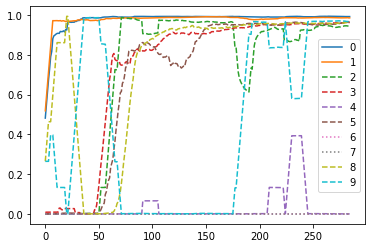

In [104]:
# DJGrad, p=0.1

with open(os.path.join(fp_local,'djgrad_01.pickle'), 'rb') as handle:
    history = pickle.load(handle)
    
line_style = ['-','-','--','--','--','--',':',':','--','--']

for k,l in zip([k for k in history if 'val_ca1' in k],line_style):
    tmp = smooth(history[k],15)[:-15]
    plt.plot(tmp,label=k[-1],linestyle=l)
        
plt.legend()

plt.show()

In [76]:
[x for x in history.keys() if 'ca1' in x[:3]]

['ca1-cl0',
 'ca1-cl1',
 'ca1-cl2',
 'ca1-cl3',
 'ca1-cl4',
 'ca1-cl5',
 'ca1-cl6',
 'ca1-cl7',
 'ca1-cl8',
 'ca1-cl9']

---

In [157]:
import pandas as pd
wine_df = pd.read_csv(os.path.join(fp_data,'winequality-red.csv'),delimiter=';')
wine_df = wine_df.append(pd.read_csv(os.path.join(fp_data,'winequality-white.csv'),delimiter=';'))
wine_df = wine_df.sample(frac=1)

In [158]:
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4715,6.7,0.15,0.32,7.9,0.034,17.0,81.0,0.99512,3.29,0.31,10.0,6
1511,7.1,0.69,0.04,2.1,0.068,19.0,27.0,0.99712,3.44,0.67,9.8,5
592,6.9,0.41,0.33,10.1,0.043,28.0,152.0,0.99680,3.20,0.52,9.4,5
1525,6.7,0.48,0.08,2.1,0.064,18.0,34.0,0.99552,3.33,0.64,9.7,5
1405,7.7,0.28,0.30,2.0,0.062,18.0,34.0,0.99520,3.28,0.90,11.3,7
...,...,...,...,...,...,...,...,...,...,...,...,...
233,6.9,0.52,0.25,2.6,0.081,10.0,37.0,0.99685,3.46,0.50,11.0,5
2893,6.2,0.16,0.34,1.7,0.038,85.0,153.0,0.99090,3.33,0.86,12.0,7
19,7.9,0.32,0.51,1.8,0.341,17.0,56.0,0.99690,3.04,1.08,9.2,6
540,9.2,0.59,0.24,3.3,0.101,20.0,47.0,0.99880,3.26,0.67,9.6,5


In [187]:
fp_datamodel = Sequential([
    layers.Dense(64, activation='sigmoid', input_shape=(11,)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1, 'linear')
])

fp_datamodel.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(
    ),
#     metrics=[CWAcc1(n,name=f'cl{n}') for n in range(10)]
)

In [188]:
wine_df.drop('quality',axis=1).to_numpy().shape,wine_df['quality'].to_numpy().shape,

((6497, 11), (6497,))

In [189]:
%%time

history = fp_datamodel.fit(
    wine_df.drop('quality',axis=1).to_numpy(),
    wine_df['quality'].to_numpy(),
    epochs=400,
    validation_split=0.2,
)

Epoch 1/400
163/163 [==============================] - 0s 814us/step - loss: 18.6278 - val_loss: 9.6332
Epoch 2/400
163/163 [==============================] - 0s 479us/step - loss: 6.3775 - val_loss: 4.1582
Epoch 3/400
163/163 [==============================] - 0s 477us/step - loss: 2.6343 - val_loss: 1.7426
Epoch 4/400
163/163 [==============================] - 0s 474us/step - loss: 1.2396 - val_loss: 0.9596
Epoch 5/400
163/163 [==============================] - 0s 478us/step - loss: 0.8395 - val_loss: 0.7692
Epoch 6/400
163/163 [==============================] - 0s 480us/step - loss: 0.7741 - val_loss: 0.7432
Epoch 7/400
163/163 [==============================] - 0s 473us/step - loss: 0.7690 - val_loss: 0.7389
Epoch 8/400
163/163 [==============================] - 0s 481us/step - loss: 0.7687 - val_loss: 0.7402
Epoch 9/400
163/163 [==============================] - 0s 511us/step - loss: 0.7687 - val_loss: 0.7407
Epoch 10/400
163/163 [==============================] - 0s 527us/step - 

Epoch 80/400
163/163 [==============================] - 0s 502us/step - loss: 0.5173 - val_loss: 0.4962
Epoch 81/400
163/163 [==============================] - 0s 489us/step - loss: 0.5227 - val_loss: 0.5041
Epoch 82/400
163/163 [==============================] - 0s 495us/step - loss: 0.5141 - val_loss: 0.5033
Epoch 83/400
163/163 [==============================] - 0s 496us/step - loss: 0.5163 - val_loss: 0.5119
Epoch 84/400
163/163 [==============================] - 0s 494us/step - loss: 0.5142 - val_loss: 0.5443
Epoch 85/400
163/163 [==============================] - 0s 497us/step - loss: 0.5210 - val_loss: 0.5023
Epoch 86/400
163/163 [==============================] - 0s 484us/step - loss: 0.5167 - val_loss: 0.5194
Epoch 87/400
163/163 [==============================] - 0s 489us/step - loss: 0.5182 - val_loss: 0.5066
Epoch 88/400
163/163 [==============================] - 0s 490us/step - loss: 0.5144 - val_loss: 0.5055
Epoch 89/400
163/163 [==============================] - 0s 491us

163/163 [==============================] - 0s 502us/step - loss: 0.5032 - val_loss: 0.4884
Epoch 159/400
163/163 [==============================] - 0s 506us/step - loss: 0.5045 - val_loss: 0.4893
Epoch 160/400
163/163 [==============================] - 0s 500us/step - loss: 0.5091 - val_loss: 0.5006
Epoch 161/400
163/163 [==============================] - 0s 493us/step - loss: 0.5045 - val_loss: 0.5037
Epoch 162/400
163/163 [==============================] - 0s 506us/step - loss: 0.5026 - val_loss: 0.4909
Epoch 163/400
163/163 [==============================] - 0s 491us/step - loss: 0.5018 - val_loss: 0.4898
Epoch 164/400
163/163 [==============================] - 0s 495us/step - loss: 0.5004 - val_loss: 0.4884
Epoch 165/400
163/163 [==============================] - 0s 496us/step - loss: 0.5019 - val_loss: 0.5045
Epoch 166/400
163/163 [==============================] - 0s 492us/step - loss: 0.5026 - val_loss: 0.5081
Epoch 167/400
163/163 [==============================] - 0s 499us/ste

163/163 [==============================] - 0s 537us/step - loss: 0.4921 - val_loss: 0.4864
Epoch 237/400
163/163 [==============================] - 0s 489us/step - loss: 0.4950 - val_loss: 0.5197
Epoch 238/400
163/163 [==============================] - 0s 484us/step - loss: 0.4940 - val_loss: 0.5028
Epoch 239/400
163/163 [==============================] - 0s 485us/step - loss: 0.4943 - val_loss: 0.4927
Epoch 240/400
163/163 [==============================] - 0s 481us/step - loss: 0.4901 - val_loss: 0.4901
Epoch 241/400
163/163 [==============================] - 0s 475us/step - loss: 0.4923 - val_loss: 0.4881
Epoch 242/400
163/163 [==============================] - 0s 472us/step - loss: 0.4906 - val_loss: 0.5301
Epoch 243/400
163/163 [==============================] - 0s 484us/step - loss: 0.4909 - val_loss: 0.4839
Epoch 244/400
163/163 [==============================] - 0s 476us/step - loss: 0.4904 - val_loss: 0.4838
Epoch 245/400
163/163 [==============================] - 0s 482us/ste

163/163 [==============================] - 0s 498us/step - loss: 0.4838 - val_loss: 0.4880
Epoch 315/400
163/163 [==============================] - 0s 500us/step - loss: 0.4823 - val_loss: 0.4779
Epoch 316/400
163/163 [==============================] - 0s 499us/step - loss: 0.4786 - val_loss: 0.4773
Epoch 317/400
163/163 [==============================] - 0s 512us/step - loss: 0.4801 - val_loss: 0.4823
Epoch 318/400
163/163 [==============================] - 0s 506us/step - loss: 0.4870 - val_loss: 0.4807
Epoch 319/400
163/163 [==============================] - 0s 626us/step - loss: 0.4814 - val_loss: 0.5042
Epoch 320/400
163/163 [==============================] - 0s 634us/step - loss: 0.4815 - val_loss: 0.4814
Epoch 321/400
163/163 [==============================] - 0s 633us/step - loss: 0.4807 - val_loss: 0.4893
Epoch 322/400
163/163 [==============================] - 0s 728us/step - loss: 0.4787 - val_loss: 0.4822
Epoch 323/400
163/163 [==============================] - 0s 555us/ste

163/163 [==============================] - 0s 493us/step - loss: 0.4695 - val_loss: 0.4931
Epoch 393/400
163/163 [==============================] - 0s 509us/step - loss: 0.4674 - val_loss: 0.4820
Epoch 394/400
163/163 [==============================] - 0s 502us/step - loss: 0.4745 - val_loss: 0.4808
Epoch 395/400
163/163 [==============================] - 0s 483us/step - loss: 0.4710 - val_loss: 0.4856
Epoch 396/400
163/163 [==============================] - 0s 487us/step - loss: 0.4717 - val_loss: 0.5007
Epoch 397/400
163/163 [==============================] - 0s 480us/step - loss: 0.4729 - val_loss: 0.4795
Epoch 398/400
163/163 [==============================] - 0s 588us/step - loss: 0.4675 - val_loss: 0.4875
Epoch 399/400
163/163 [==============================] - 0s 589us/step - loss: 0.4695 - val_loss: 0.4790
Epoch 400/400
163/163 [==============================] - 0s 612us/step - loss: 0.4679 - val_loss: 0.4908
CPU times: user 54.7 s, sys: 9.75 s, total: 1min 4s
Wall time: 34.3 s

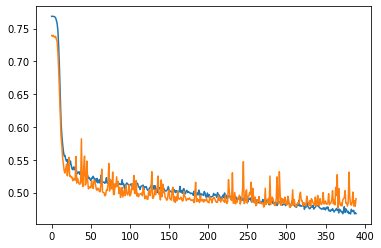

In [190]:
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])

plt.show()

In [192]:
np.mean(np.square(wine_df['quality'] - wine_df['quality'].mean()))

0.7624573958892861

# References
## Asynch Distributed Learning
- https://dl.acm.org/doi/pdf/10.1145/3368474.3368498
- https://www.ijcai.org/Proceedings/16/Papers/335.pdf
- https://github.com/nttcslab/edge-consensus-learning
- https://dl-acm-org.proxy.lib.umich.edu/doi/pdf/10.1145/3368474.3368498
- 

## Consensus in Asynchronous Communication
- http://www.cse.msu.edu/~sandeep/cse812Spring2019/Slides/consensus-impossibility.pdf
- https://link-springer-com.proxy.lib.umich.edu/referenceworkentry/10.1007/978-0-387-30162-4_36
- 

## Unreliable Networks
- https://arxiv.org/pdf/1810.07766.pdf
- 

## Assisted Learning
- https://papers.nips.cc/paper/2020/file/a7b23e6eefbe6cf04b8e62a6f0915550-Paper.pdf
- 